# Importamos Librerias y Datasets

In [2]:
import pandas as pd
import numpy as np
import sklearn as skl

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import time
import random

# python core library for machine learning and data science
import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

import networkx as nx
from scipy.stats import linregress

In [3]:
path = '/content/weekly_data_for_python.csv'
path_events = '/content/daily_calendar_with_expanded_events.csv'

In [4]:
df = pd.read_csv(path)
df_events = pd.read_csv(path_events)

In [5]:
df_calendar = df_events.groupby('yearweek').agg({'date': 'min'}).reset_index()

In [6]:
#(6721786, 11)
df.shape

(6721786, 11)

In [7]:
df_events.shape

(1913, 8)

In [8]:
df_calendar.shape

(279, 2)

In [9]:
df_calendar['Year'] = pd.to_datetime(df_calendar['date']).dt.year
df_calendar['Quarter'] = pd.to_datetime(df_calendar['date']).dt.quarter

In [10]:
df.head()

item store_code  category_x    department        region  \
0  ACCESORIES_1_004      BOS_1  ACCESORIES  ACCESORIES_1        Boston   
1  ACCESORIES_1_004      BOS_2  ACCESORIES  ACCESORIES_1        Boston   
2  ACCESORIES_1_004      NYC_2  ACCESORIES  ACCESORIES_1      New York   
3  ACCESORIES_1_004      NYC_4  ACCESORIES  ACCESORIES_1      New York   
4  ACCESORIES_1_004      PHI_1  ACCESORIES  ACCESORIES_1  Philadelphia   

             store  yearweek  sale  daily_revenue  sell_price  week_number  
0        South_End  201105.0    10        57.7220      5.7722            1  
1          Roxbury  201105.0    15        86.5830      5.7722            1  
2           Harlem  201105.0    33       190.4826      5.7722            1  
3         Brooklyn  201105.0     8        46.1776      5.7722            1  
4  Midtown_Village  201105.0     6        34.6332      5.7722            1

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6721786 entries, 0 to 6721785
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   item           object 
 1   store_code     object 
 2   category_x     object 
 3   department     object 
 4   region         object 
 5   store          object 
 6   yearweek       float64
 7   sale           int64  
 8   daily_revenue  float64
 9   sell_price     float64
 10  week_number    int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 564.1+ MB


In [12]:
df_events.head()

date    weekday  weekday_int    d event  yearweek Event_Name  \
0  2011-01-29   Saturday            1  d_1   NaN  201105.0   No Event   
1  2011-01-30     Sunday            2  d_2   NaN  201105.0   No Event   
2  2011-01-31     Monday            3  d_3   NaN  201105.0   No Event   
3  2011-02-01    Tuesday            4  d_4   NaN  201105.0   No Event   
4  2011-02-02  Wednesday            5  d_5   NaN  201105.0   No Event   

  Weekly_Event  
0     No Event  
1     No Event  
2     No Event  
3     No Event  
4     No Event

In [13]:
df.columns

Index(['item', 'store_code', 'category_x', 'department', 'region', 'store',
       'yearweek', 'sale', 'daily_revenue', 'sell_price', 'week_number'],
      dtype='object')

In [14]:
df_events.columns

Index(['date', 'weekday', 'weekday_int', 'd', 'event', 'yearweek',
       'Event_Name', 'Weekly_Event'],
      dtype='object')

## Features para clustering

In [15]:
# shape = (articulos, features)

In [16]:
# Posibles Features

# Precio
  # Precio                                 * # Precio medio
  # Variabilidad general                   * # DESVIO_STANDAR/PROM
  # Variabilidad asociada a eventos         # PRECIO_PROM_DIAS_FESTIVOS/PRECIO_PROM_DIAS_NO_FESTIVOS
  # Clasificacion ABC Global                # ABC ITEM // PRECIO_ITEM / PRECIO_PROM_GENERAL
  # Clasificacion ABC por categoria         # ABC ITEM EN SU CATEGORY // PRECIO_ITEM / PRECIO_PROM_CATEGORY
  # Clasificacion ABC por department        # ABC ITEM EN SU DEPARTMENT // PRECIO_ITEM / PRECIO_PROM_DEPARTMENT [precio_relativo_al_departamento]

  # Elasticidad de precio                   # ln(Q) = B0 + B1*ln(P) + sum(Bn * OHEfn)

# Ventas
  # Cantidad                                                           * # Cantidad ventas promedio
  # Estables / Erraticos                                               * # DESVIO_STANDAR/PROM
  # Estacionalidad de año por item                                     * # Periodo Qmax - periodo Qmin

  # Ventas conjuntas                                                   * #  integrantes de cluster

  # Estacionalidad de año por categoria
  # Estacionalidad de año por departamento

  # Ventas relacionadas a fechas de eventos festivos por item           # PROM_DIARIO_FESTIVO/PROM_DIARIO_NO_FESTIVO

  # Ventas relacionadas a fechas de eventos festivos por categoria
  # Ventas relacionadas a fechas de eventos festivos por departamento

  # Ventas regionales                  * NY/TOT, BOS/TOT, PHI/TOT   [# Region Qmax - Region Qmin]

  # Ventas por eventos regionales

  # Ventas por incidencias climaticas         PROM_DIARIO_EVENTOS_CLIMATICOS/PROM_DIARIO_NO_FESTIVO

# Presencia de producto
    # Antiguedad de producto        ** #release_week
    # Presencia en tiendas           * #total_supply


# Preparamos las features

## Data set items

In [17]:
df.columns



Index(['item', 'store_code', 'category_x', 'department', 'region', 'store',
       'yearweek', 'sale', 'daily_revenue', 'sell_price', 'week_number'],
      dtype='object')

### Features de nivel de demanda

In [18]:
df_total_demand = df.groupby(['item','yearweek']).agg({'store': 'count', 'sale': 'sum', 'sell_price': 'mean'}).reset_index()

In [19]:
df_total_demand['sales_ratio'] = df_total_demand['sale'] / df_total_demand['store']

In [20]:
df_total_demand

item  yearweek  store  sale  sell_price  sales_ratio
0        ACCESORIES_1_001  201328.0      4     8    12.74140     2.000000
1        ACCESORIES_1_001  201329.0      5     7    12.03916     1.400000
2        ACCESORIES_1_001  201330.0      9    17    11.67740     1.888889
3        ACCESORIES_1_001  201331.0     10    16    11.25712     1.600000
4        ACCESORIES_1_001  201332.0     10    21    11.25712     2.100000
...                   ...       ...    ...   ...         ...          ...
701110  SUPERMARKET_3_827  201613.0     10   167     1.20000    16.700000
701111  SUPERMARKET_3_827  201614.0     10   205     1.20000    20.500000
701112  SUPERMARKET_3_827  201615.0     10   167     1.20000    16.700000
701113  SUPERMARKET_3_827  201616.0     10   186     1.20000    18.600000
701114  SUPERMARKET_3_827  201617.0     10    60     1.20000     6.000000

[701115 rows x 6 columns]

In [21]:
df_sales = (df_total_demand.groupby('item')
            .agg({'sales_ratio': ['mean', 'std'], 'sell_price': ['mean', 'std']})
            .reset_index()
            .set_axis(['item','sales_ratio_mean', 'sales_ratio_std', 'sell_price_mean', 'sell_price_std'], axis=1)
)

In [22]:
df_sales

item  sales_ratio_mean  sales_ratio_std  sell_price_mean  \
0      ACCESORIES_1_001          2.760999         0.800985        11.043445   
1      ACCESORIES_1_002          1.855793         1.081860         5.275790   
2      ACCESORIES_1_003          1.252894         0.707983         3.943779   
3      ACCESORIES_1_004         14.145769         3.234176         5.981574   
4      ACCESORIES_1_005          5.570844         2.352677         3.832410   
...                 ...               ...              ...              ...   
3044  SUPERMARKET_3_823          5.954361         5.302125         3.343141   
3045  SUPERMARKET_3_824          2.983871         2.076190         3.026692   
3046  SUPERMARKET_3_825          4.858045         3.274274         4.934241   
3047  SUPERMARKET_3_826          7.721777         2.386453         1.535795   
3048  SUPERMARKET_3_827         11.564945         5.682142         1.199478   

      sell_price_std  
0           0.181601  
1           0.032435  
2           0.068217  
3           0.235091  
4           0.170571  
...              ...  
3044        0.205971  
3045        0.071883  
3046        0.213154  
3047        0.002624  
3048        0.005595  

[3049 rows x 5 columns]

<Axes: >

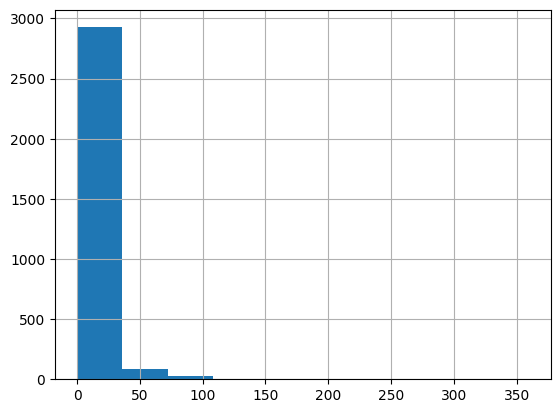

In [23]:
df_sales['sales_ratio_mean'].hist()

<Axes: >

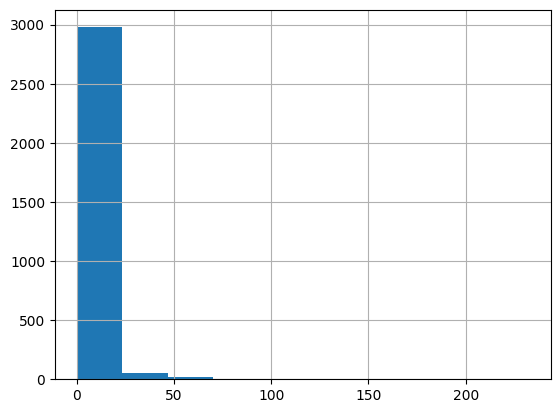

In [24]:
df_sales['sales_ratio_std'].hist()

<Axes: >

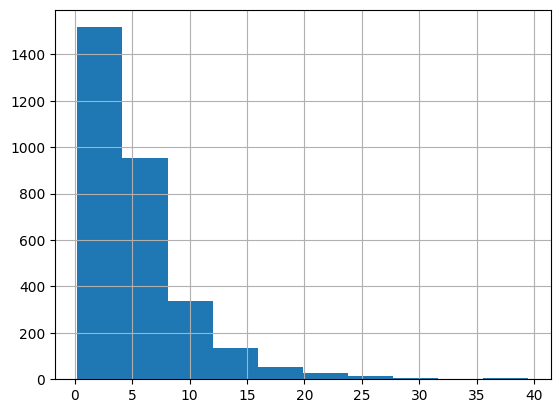

In [25]:
df_sales['sell_price_mean'].hist()

<Axes: >

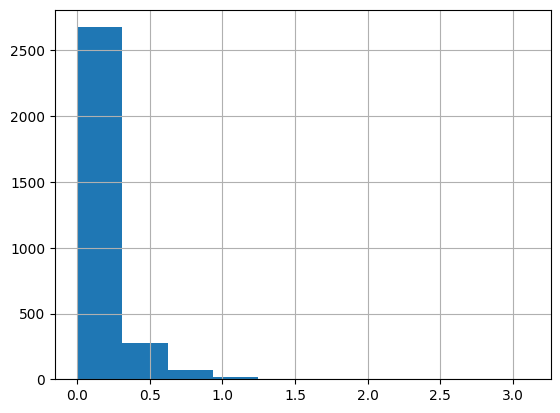

In [26]:
df_sales['sell_price_std'].hist()

In [27]:
df_sales['sales_ratio_relative_std'] = df_sales['sales_ratio_std'] / df_sales['sales_ratio_mean']

In [28]:
df_sales['sell_price_relative_std'] = df_sales['sell_price_std'] / df_sales['sell_price_mean']

In [29]:
df_sales.sort_values(by='sales_ratio_relative_std', ascending=False)

item  sales_ratio_mean  sales_ratio_std  sell_price_mean  \
2081    SUPERMARKET_2_255         11.475802        24.006156         2.858615   
1258  HOME_&_GARDEN_2_162          0.466627         0.929615         4.962214   
1067  HOME_&_GARDEN_1_512          0.752220         1.466547         2.337500   
326      ACCESORIES_1_335          2.471762         4.788061        16.785456   
2520    SUPERMARKET_3_296          1.983089         3.465637         2.046528   
...                   ...               ...              ...              ...   
143      ACCESORIES_1_148          9.262224         1.718899         6.490400   
641   HOME_&_GARDEN_1_079          9.871592         1.831654         6.084768   
2918    SUPERMARKET_3_694        139.785305        25.625977         1.924344   
2267    SUPERMARKET_3_042         33.894873         5.985416         1.917204   
2601    SUPERMARKET_3_377         97.953047        16.876832         1.909806   

      sell_price_std  sales_ratio_relative_std  sell_price_relative_std  
2081    9.400793e-02                  2.091894             3.288583e-02  
1258    3.270108e-03                  1.992201             6.590018e-04  
1067    8.833731e-17                  1.949624             3.779136e-17  
326     2.341764e-01                  1.937105             1.395115e-02  
2520    2.278484e-01                  1.747595             1.113341e-01  
...              ...                       ...                      ...  
143     8.827127e-16                  0.185582             1.360028e-16  
641     8.349006e-02                  0.185548             1.372116e-02  
2918    9.162260e-02                  0.183324             4.761238e-02  
2267    9.060904e-02                  0.176588             4.726102e-02  
2601    8.270015e-02                  0.172295             4.330290e-02  

[3049 rows x 7 columns]

<Axes: >

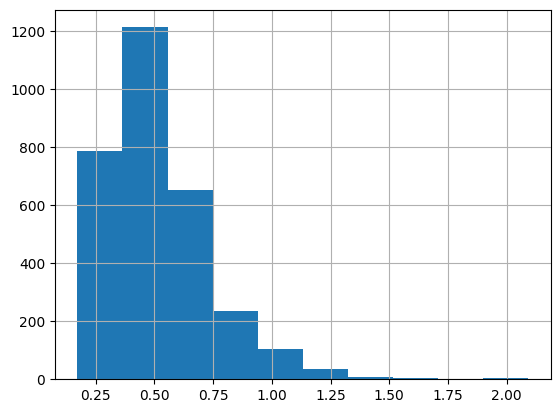

In [30]:
df_sales['sales_ratio_relative_std'].hist()

<Axes: >

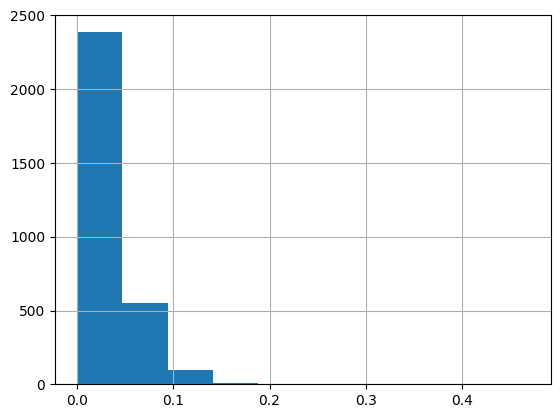

In [31]:
df_sales['sell_price_relative_std'].hist()

In [32]:
df_items = df_sales.copy()

### Features de madurez de articulos

In [33]:
df_supply_items = (
    df.groupby('item')
.agg({'store': 'count','week_number': 'min' })
.reset_index()
.set_axis(['item', 'total_supply', 'release_week'], axis=1)
)


In [34]:
df_supply_items.head()

item  total_supply  release_week
0  ACCESORIES_1_001          1478           131
1  ACCESORIES_1_002          2689             6
2  ACCESORIES_1_003          1133           161
3  ACCESORIES_1_004          2768             1
4  ACCESORIES_1_005          2630            14

In [35]:
df_items = df_items.merge(df_supply_items, on='item', how='left')

In [36]:
df_items

item  sales_ratio_mean  sales_ratio_std  sell_price_mean  \
0      ACCESORIES_1_001          2.760999         0.800985        11.043445   
1      ACCESORIES_1_002          1.855793         1.081860         5.275790   
2      ACCESORIES_1_003          1.252894         0.707983         3.943779   
3      ACCESORIES_1_004         14.145769         3.234176         5.981574   
4      ACCESORIES_1_005          5.570844         2.352677         3.832410   
...                 ...               ...              ...              ...   
3044  SUPERMARKET_3_823          5.954361         5.302125         3.343141   
3045  SUPERMARKET_3_824          2.983871         2.076190         3.026692   
3046  SUPERMARKET_3_825          4.858045         3.274274         4.934241   
3047  SUPERMARKET_3_826          7.721777         2.386453         1.535795   
3048  SUPERMARKET_3_827         11.564945         5.682142         1.199478   

      sell_price_std  sales_ratio_relative_std  sell_price_relative_std  \
0           0.181601                  0.290107                 0.016444   
1           0.032435                  0.582964                 0.006148   
2           0.068217                  0.565078                 0.017297   
3           0.235091                  0.228632                 0.039302   
4           0.170571                  0.422320                 0.044507   
...              ...                       ...                      ...   
3044        0.205971                  0.890461                 0.061610   
3045        0.071883                  0.695804                 0.023750   
3046        0.213154                  0.673990                 0.043199   
3047        0.002624                  0.309055                 0.001708   
3048        0.005595                  0.491325                 0.004665   

      total_supply  release_week  
0             1478           131  
1             2689             6  
2             1133           161  
3             2768             1  
4             2630            14  
...            ...           ...  
3044          2668             1  
3045          2790             1  
3046          2787             1  
3047          1601           116  
3048           991           165  

[3049 rows x 9 columns]

In [37]:
df_items.columns

Index(['item', 'sales_ratio_mean', 'sales_ratio_std', 'sell_price_mean',
       'sell_price_std', 'sales_ratio_relative_std', 'sell_price_relative_std',
       'total_supply', 'release_week'],
      dtype='object')

### Features de dispersion de demanda

#### Dispersion por region (Regionality)

In [38]:
df_region_sales = (
    df
 .pivot_table(index='item', columns='region', values='daily_revenue', aggfunc='sum')
)
df_region_sales['New York'] *= 0.75 #Normalizamos por cantidad de stores
df_region_sales_normalized = df_region_sales.div(df_region_sales.sum(axis=1), axis=0)
df_region_sales_normalized = df_region_sales_normalized.reset_index()

In [39]:
df_region_sales_normalized

region               item    Boston  New York  Philadelphia
0        ACCESORIES_1_001  0.302943  0.548978      0.148079
1        ACCESORIES_1_002  0.188383  0.256821      0.554795
2        ACCESORIES_1_003  0.300438  0.438881      0.260681
3        ACCESORIES_1_004  0.286276  0.514809      0.198915
4        ACCESORIES_1_005  0.310560  0.450841      0.238599
...                   ...       ...       ...           ...
3044    SUPERMARKET_3_823  0.176659  0.602843      0.220499
3045    SUPERMARKET_3_824  0.221786  0.477101      0.301114
3046    SUPERMARKET_3_825  0.313512  0.386961      0.299527
3047    SUPERMARKET_3_826  0.281754  0.410520      0.307726
3048    SUPERMARKET_3_827  0.123644  0.386945      0.489411

[3049 rows x 4 columns]

In [40]:
df_region_sales_normalized['Regionality'] = df_region_sales_normalized[['Boston', 'New York', 'Philadelphia']].max(axis=1) - df_region_sales_normalized[['Boston', 'New York', 'Philadelphia']].min(axis=1)

In [41]:
df_region_sales_normalized

region               item    Boston  New York  Philadelphia  Regionality
0        ACCESORIES_1_001  0.302943  0.548978      0.148079     0.400899
1        ACCESORIES_1_002  0.188383  0.256821      0.554795     0.366412
2        ACCESORIES_1_003  0.300438  0.438881      0.260681     0.178200
3        ACCESORIES_1_004  0.286276  0.514809      0.198915     0.315894
4        ACCESORIES_1_005  0.310560  0.450841      0.238599     0.212243
...                   ...       ...       ...           ...          ...
3044    SUPERMARKET_3_823  0.176659  0.602843      0.220499     0.426184
3045    SUPERMARKET_3_824  0.221786  0.477101      0.301114     0.255315
3046    SUPERMARKET_3_825  0.313512  0.386961      0.299527     0.087434
3047    SUPERMARKET_3_826  0.281754  0.410520      0.307726     0.128765
3048    SUPERMARKET_3_827  0.123644  0.386945      0.489411     0.365767

[3049 rows x 5 columns]

In [42]:
df_region_sales_normalized.sort_values(by='Regionality', ascending=True)

region                 item    Boston  New York  Philadelphia  Regionality
1810      SUPERMARKET_1_202  0.335177  0.332375      0.332448     0.002801
69         ACCESORIES_1_072  0.338188  0.331496      0.330316     0.007872
1748      SUPERMARKET_1_139  0.329756  0.332293      0.337951     0.008194
1582    HOME_&_GARDEN_2_487  0.330647  0.330013      0.339340     0.009327
727     HOME_&_GARDEN_1_167  0.327386  0.336862      0.335751     0.009476
...                     ...       ...       ...           ...          ...
1812      SUPERMARKET_1_204  0.051521  0.132031      0.816448     0.764927
2224      SUPERMARKET_2_398  0.083406  0.066299      0.850295     0.783996
2035      SUPERMARKET_2_209  0.061047  0.042796      0.896157     0.853361
2082      SUPERMARKET_2_256  0.059187  0.038162      0.902651     0.864489
1943      SUPERMARKET_2_117  0.059824  0.034078      0.906098     0.872020

[3049 rows x 5 columns]

In [43]:
df_region_sales_normalized.sort_values(by='New York', ascending=True)

region                 item    Boston  New York  Philadelphia  Regionality
1943      SUPERMARKET_2_117  0.059824  0.034078      0.906098     0.872020
2082      SUPERMARKET_2_256  0.059187  0.038162      0.902651     0.864489
2035      SUPERMARKET_2_209  0.061047  0.042796      0.896157     0.853361
1706      SUPERMARKET_1_096  0.322386  0.043685      0.633929     0.590244
1859      SUPERMARKET_2_032  0.332510  0.053777      0.613713     0.559935
...                     ...       ...       ...           ...          ...
2366      SUPERMARKET_3_142  0.105559  0.697227      0.197214     0.591668
1248    HOME_&_GARDEN_2_152  0.185915  0.705621      0.108464     0.597157
764     HOME_&_GARDEN_1_204  0.204359  0.739339      0.056302     0.683037
2401      SUPERMARKET_3_177  0.145424  0.749984      0.104592     0.645392
2675      SUPERMARKET_3_451  0.157378  0.756201      0.086421     0.669780

[3049 rows x 5 columns]

<Axes: >

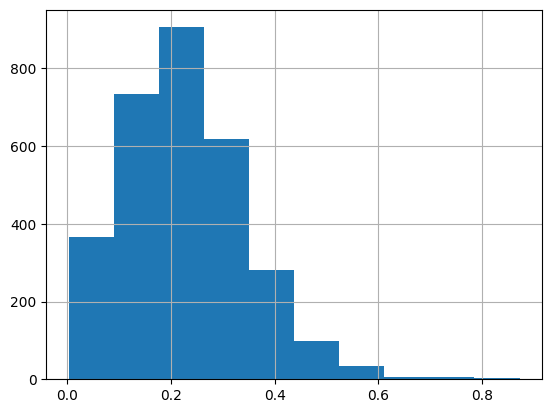

In [44]:
df_region_sales_normalized['Regionality'].hist()

In [45]:
df.head()

item store_code  category_x    department        region  \
0  ACCESORIES_1_004      BOS_1  ACCESORIES  ACCESORIES_1        Boston   
1  ACCESORIES_1_004      BOS_2  ACCESORIES  ACCESORIES_1        Boston   
2  ACCESORIES_1_004      NYC_2  ACCESORIES  ACCESORIES_1      New York   
3  ACCESORIES_1_004      NYC_4  ACCESORIES  ACCESORIES_1      New York   
4  ACCESORIES_1_004      PHI_1  ACCESORIES  ACCESORIES_1  Philadelphia   

             store  yearweek  sale  daily_revenue  sell_price  week_number  
0        South_End  201105.0    10        57.7220      5.7722            1  
1          Roxbury  201105.0    15        86.5830      5.7722            1  
2           Harlem  201105.0    33       190.4826      5.7722            1  
3         Brooklyn  201105.0     8        46.1776      5.7722            1  
4  Midtown_Village  201105.0     6        34.6332      5.7722            1

In [46]:
df_events.head()

date    weekday  weekday_int    d event  yearweek Event_Name  \
0  2011-01-29   Saturday            1  d_1   NaN  201105.0   No Event   
1  2011-01-30     Sunday            2  d_2   NaN  201105.0   No Event   
2  2011-01-31     Monday            3  d_3   NaN  201105.0   No Event   
3  2011-02-01    Tuesday            4  d_4   NaN  201105.0   No Event   
4  2011-02-02  Wednesday            5  d_5   NaN  201105.0   No Event   

  Weekly_Event  
0     No Event  
1     No Event  
2     No Event  
3     No Event  
4     No Event

In [47]:
df_calendar.columns

Index(['yearweek', 'date', 'Year', 'Quarter'], dtype='object')

#### Dispersion por trimestre (Seasonality)

In [48]:
df_seasson_sales = df.merge(df_calendar[['yearweek','Year','Quarter']], on='yearweek', how='left')

In [49]:
df_seasson_sales.head()

item store_code  category_x    department        region  \
0  ACCESORIES_1_004      BOS_1  ACCESORIES  ACCESORIES_1        Boston   
1  ACCESORIES_1_004      BOS_2  ACCESORIES  ACCESORIES_1        Boston   
2  ACCESORIES_1_004      NYC_2  ACCESORIES  ACCESORIES_1      New York   
3  ACCESORIES_1_004      NYC_4  ACCESORIES  ACCESORIES_1      New York   
4  ACCESORIES_1_004      PHI_1  ACCESORIES  ACCESORIES_1  Philadelphia   

             store  yearweek  sale  daily_revenue  sell_price  week_number  \
0        South_End  201105.0    10        57.7220      5.7722            1   
1          Roxbury  201105.0    15        86.5830      5.7722            1   
2           Harlem  201105.0    33       190.4826      5.7722            1   
3         Brooklyn  201105.0     8        46.1776      5.7722            1   
4  Midtown_Village  201105.0     6        34.6332      5.7722            1   

   Year  Quarter  
0  2011        1  
1  2011        1  
2  2011        1  
3  2011        1  
4  2011        1

In [50]:
df_calendar['Year'].unique()

array([2011, 2012, 2013, 2014, 2015, 2016], dtype=int32)

In [51]:
df_seasson_sales = (
    df_seasson_sales
    [(df_seasson_sales['Year'] > 2011) & (df_seasson_sales['Year'] < 2016)]  #Retenemos años completos
 .pivot_table(index='item', columns='Quarter', values='daily_revenue', aggfunc='sum')
 .fillna(0)
)


In [52]:
df_seasson_sales_normalized = df_seasson_sales.div(df_seasson_sales.sum(axis=1), axis=0)
df_seasson_sales_normalized = df_seasson_sales_normalized.reset_index()

In [53]:
df_seasson_sales_normalized

Quarter               item         1         2         3         4
0         ACCESORIES_1_001  0.192323  0.195178  0.269890  0.342609
1         ACCESORIES_1_002  0.197202  0.217097  0.261050  0.324651
2         ACCESORIES_1_003  0.193798  0.240921  0.267175  0.298107
3         ACCESORIES_1_004  0.262926  0.252666  0.232330  0.252078
4         ACCESORIES_1_005  0.231958  0.211545  0.247695  0.308801
...                    ...       ...       ...       ...       ...
3044     SUPERMARKET_3_823  0.266627  0.156674  0.241350  0.335348
3045     SUPERMARKET_3_824  0.247879  0.337521  0.258779  0.155821
3046     SUPERMARKET_3_825  0.269116  0.233945  0.299630  0.197309
3047     SUPERMARKET_3_826  0.173373  0.314959  0.269672  0.241996
3048     SUPERMARKET_3_827  0.160313  0.258309  0.275660  0.305718

[3049 rows x 5 columns]

In [54]:
quarters = df_calendar['Quarter'].unique()
df_seasson_sales_normalized['Seasonality'] = df_seasson_sales_normalized[quarters].max(axis=1) - df_seasson_sales_normalized[quarters].min(axis=1)

In [55]:
df_seasson_sales_normalized.sort_values(by='Seasonality', ascending=True)

Quarter                 item         1         2         3         4  \
1270     HOME_&_GARDEN_2_174  0.249108  0.250297  0.250297  0.250297   
67          ACCESORIES_1_069  0.249041  0.250398  0.250051  0.250510   
2602       SUPERMARKET_3_378  0.252060  0.246911  0.250569  0.250459   
105         ACCESORIES_1_110  0.252029  0.251127  0.250676  0.246168   
269         ACCESORIES_1_277  0.252160  0.251012  0.250806  0.246022   
...                      ...       ...       ...       ...       ...   
2163       SUPERMARKET_2_337  0.321472  0.005867  0.597927  0.074735   
3017       SUPERMARKET_3_796  0.147886  0.000000  0.252373  0.599741   
2080       SUPERMARKET_2_254  0.301953  0.000988  0.612779  0.084279   
1904       SUPERMARKET_2_077  0.300245  0.006963  0.621273  0.071519   
1435     HOME_&_GARDEN_2_340  0.049525  0.655171  0.268267  0.027037   

Quarter  Seasonality  
1270        0.001189  
67          0.001469  
2602        0.005149  
105         0.005861  
269         0.006138  
...              ...  
2163        0.592060  
3017        0.599741  
2080        0.611791  
1904        0.614309  
1435        0.628134  

[3049 rows x 6 columns]

<Axes: >

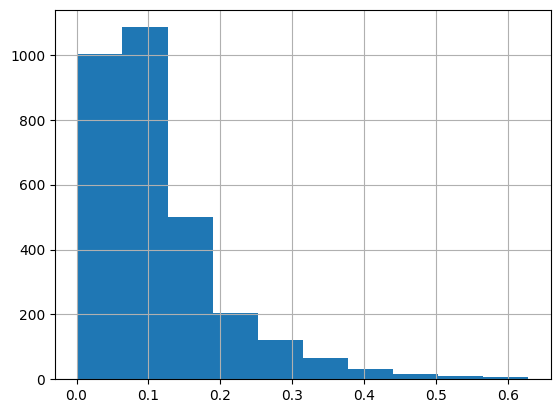

In [56]:
df_seasson_sales_normalized['Seasonality'].hist()

### Features de comportamiento de demanda

#### Analisis de ventas conjuntas

In [57]:



df_historial_sales = (

  df.pivot_table(index='item', columns='week_number', values='daily_revenue', aggfunc='sum')
  .dropna()
  .transpose()



)

<Axes: xlabel='item', ylabel='item'>

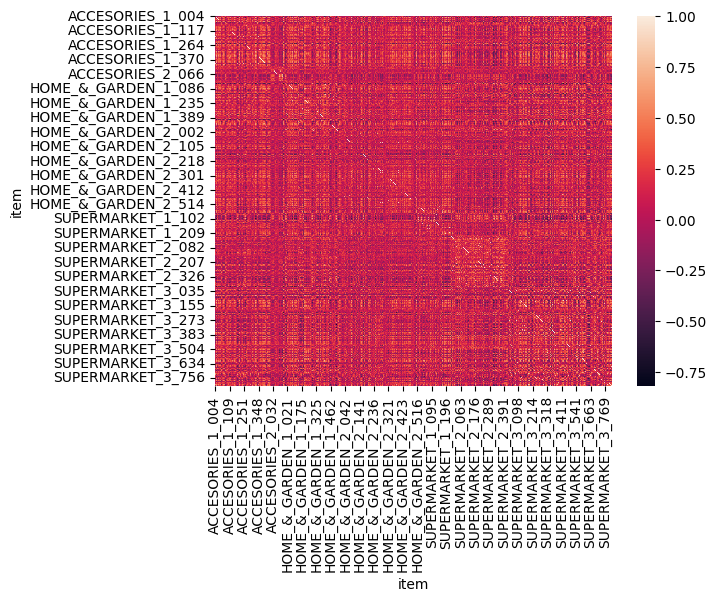

In [58]:
sns.heatmap(df_historial_sales.corr())

Observamos existencias de fuertes correlaciones positivas

In [59]:
corr_matrix_historial_sales = df_historial_sales.corr()

In [60]:
# 1457 filas, 2122849 registros

corr_matrix_historial_sales.shape

(1457, 1457)

In [61]:
corr_matrix_historial_sales_complete = corr_matrix_historial_sales.copy()

In [62]:
#fijamos a na la diagonal inferior
for i in range(corr_matrix_historial_sales.shape[0]):
  for j in range(i):
    corr_matrix_historial_sales.iloc[i, j] = np.nan

In [63]:
#pasamos a data frame con formato (art_1, art_2, corr)
df_matrix_historial_sales = corr_matrix_historial_sales_complete.stack()
df_matrix_historial_sales.index.names = ['item_1', 'item_2']
df_matrix_historial_sales = df_matrix_historial_sales.reset_index()
df_matrix_historial_sales.rename(columns={0: 'corr'}, inplace=True)


In [64]:
df_matrix_historial_sales

item_1             item_2      corr
0         ACCESORIES_1_004   ACCESORIES_1_004  1.000000
1         ACCESORIES_1_004   ACCESORIES_1_008  0.166780
2         ACCESORIES_1_004   ACCESORIES_1_009  0.037860
3         ACCESORIES_1_004   ACCESORIES_1_010  0.083446
4         ACCESORIES_1_004   ACCESORIES_1_012 -0.186870
...                    ...                ...       ...
2122844  SUPERMARKET_3_825  SUPERMARKET_3_820  0.110960
2122845  SUPERMARKET_3_825  SUPERMARKET_3_822 -0.268492
2122846  SUPERMARKET_3_825  SUPERMARKET_3_823  0.038882
2122847  SUPERMARKET_3_825  SUPERMARKET_3_824 -0.128118
2122848  SUPERMARKET_3_825  SUPERMARKET_3_825  1.000000

[2122849 rows x 3 columns]

In [65]:
df_matrix_historial_sales = df_matrix_historial_sales[df_matrix_historial_sales['item_1'] != df_matrix_historial_sales['item_2']]

In [66]:
df_matrix_historial_sales.sort_values(by='corr', ascending=False)

item_1             item_2      corr
1909877    SUPERMARKET_3_501  SUPERMARKET_3_295  0.981192
1759909    SUPERMARKET_3_295  SUPERMARKET_3_501  0.981192
1736626    SUPERMARKET_3_263  SUPERMARKET_3_572  0.979120
1952114    SUPERMARKET_3_572  SUPERMARKET_3_263  0.979120
1901034    SUPERMARKET_3_491  SUPERMARKET_3_090  0.975845
...                      ...                ...       ...
649579   HOME_&_GARDEN_1_512  SUPERMARKET_3_305 -0.774712
1161185    SUPERMARKET_1_096  SUPERMARKET_3_732 -0.804581
2059537    SUPERMARKET_3_732  SUPERMARKET_1_096 -0.804581
164597      ACCESORIES_1_261  SUPERMARKET_3_732 -0.819267
2058853    SUPERMARKET_3_732   ACCESORIES_1_261 -0.819267

[2121392 rows x 3 columns]

In [67]:
df_matrix_historial_sales['category_1'] = df_matrix_historial_sales['item_1'].apply(lambda x: x.split('_')[0])
df_matrix_historial_sales['department_1'] = df_matrix_historial_sales['item_1'].apply(lambda x: x.split('_')[-2])
df_matrix_historial_sales['article_1'] = df_matrix_historial_sales['item_1'].apply(lambda x: x.split('_')[-1])



/tmp/ipython-input-574247291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matrix_historial_sales['category_1'] = df_matrix_historial_sales['item_1'].apply(lambda x: x.split('_')[0])
/tmp/ipython-input-574247291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matrix_historial_sales['department_1'] = df_matrix_historial_sales['item_1'].apply(lambda x: x.split('_')[-2])
/tmp/ipython-input-574247291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [68]:
df_matrix_historial_sales['category_2'] = df_matrix_historial_sales['item_2'].apply(lambda x: x.split('_')[0])
df_matrix_historial_sales['department_2'] = df_matrix_historial_sales['item_2'].apply(lambda x: x.split('_')[-2])
df_matrix_historial_sales['article_2'] = df_matrix_historial_sales['item_2'].apply(lambda x: x.split('_')[-1])


/tmp/ipython-input-3646389388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matrix_historial_sales['category_2'] = df_matrix_historial_sales['item_2'].apply(lambda x: x.split('_')[0])
/tmp/ipython-input-3646389388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matrix_historial_sales['department_2'] = df_matrix_historial_sales['item_2'].apply(lambda x: x.split('_')[-2])
/tmp/ipython-input-3646389388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [69]:
df_matrix_historial_sales

item_1             item_2      corr   category_1  \
1         ACCESORIES_1_004   ACCESORIES_1_008  0.166780   ACCESORIES   
2         ACCESORIES_1_004   ACCESORIES_1_009  0.037860   ACCESORIES   
3         ACCESORIES_1_004   ACCESORIES_1_010  0.083446   ACCESORIES   
4         ACCESORIES_1_004   ACCESORIES_1_012 -0.186870   ACCESORIES   
5         ACCESORIES_1_004   ACCESORIES_1_015  0.284478   ACCESORIES   
...                    ...                ...       ...          ...   
2122843  SUPERMARKET_3_825  SUPERMARKET_3_819  0.462053  SUPERMARKET   
2122844  SUPERMARKET_3_825  SUPERMARKET_3_820  0.110960  SUPERMARKET   
2122845  SUPERMARKET_3_825  SUPERMARKET_3_822 -0.268492  SUPERMARKET   
2122846  SUPERMARKET_3_825  SUPERMARKET_3_823  0.038882  SUPERMARKET   
2122847  SUPERMARKET_3_825  SUPERMARKET_3_824 -0.128118  SUPERMARKET   

        department_1 article_1   category_2 department_2 article_2  
1                  1       004   ACCESORIES            1       008  
2                  1       004   ACCESORIES            1       009  
3                  1       004   ACCESORIES            1       010  
4                  1       004   ACCESORIES            1       012  
5                  1       004   ACCESORIES            1       015  
...              ...       ...          ...          ...       ...  
2122843            3       825  SUPERMARKET            3       819  
2122844            3       825  SUPERMARKET            3       820  
2122845            3       825  SUPERMARKET            3       822  
2122846            3       825  SUPERMARKET            3       823  
2122847            3       825  SUPERMARKET            3       824  

[2121392 rows x 9 columns]

In [70]:
df_matrix_historial_sales.pivot_table(index=['category_1', 'department_1'], columns=['category_2', 'department_2'], values='corr', aggfunc='mean')

category_2               ACCESORIES                HOME           SUPERMARKET  \
department_2                      1         2         1         2           1   
category_1  department_1                                                        
ACCESORIES  1              0.156941  0.072688  0.139563  0.118581    0.118036   
            2              0.072688  0.166147  0.074342  0.062552    0.087793   
HOME        1              0.139563  0.074342  0.152685  0.112537    0.120262   
            2              0.118581  0.062552  0.112537  0.100576    0.100498   
SUPERMARKET 1              0.118036  0.087793  0.120262  0.100498    0.144541   
            2              0.071236  0.068262  0.087346  0.059805    0.092658   
            3              0.117284  0.062853  0.120512  0.097970    0.108213   

category_2                                    
department_2                     2         3  
category_1  department_1                      
ACCESORIES  1             0.071236  0.117284  
            2             0.068262  0.062853  
HOME        1             0.087346  0.120512  
            2             0.059805  0.097970  
SUPERMARKET 1             0.092658  0.108213  
            2             0.173298  0.087131  
            3             0.087131  0.130384

In [71]:
df_matrix_historial_sales.pivot_table(index=['category_1', 'department_1'], columns=['category_2', 'department_2'], values='corr', aggfunc='min')

category_2               ACCESORIES                HOME           SUPERMARKET  \
department_2                      1         2         1         2           1   
category_1  department_1                                                        
ACCESORIES  1             -0.730331 -0.624950 -0.719512 -0.724898   -0.650483   
            2             -0.624950 -0.463502 -0.683885 -0.666259   -0.596334   
HOME        1             -0.719512 -0.683885 -0.739163 -0.688923   -0.702010   
            2             -0.724898 -0.666259 -0.688923 -0.708390   -0.689705   
SUPERMARKET 1             -0.650483 -0.596334 -0.702010 -0.689705   -0.496282   
            2             -0.697579 -0.601338 -0.662855 -0.700487   -0.581190   
            3             -0.819267 -0.603302 -0.774712 -0.645700   -0.804581   

category_2                                    
department_2                     2         3  
category_1  department_1                      
ACCESORIES  1            -0.697579 -0.819267  
            2            -0.601338 -0.603302  
HOME        1            -0.662855 -0.774712  
            2            -0.700487 -0.645700  
SUPERMARKET 1            -0.581190 -0.804581  
            2            -0.482605 -0.769102  
            3            -0.769102 -0.700676

In [72]:
df_matrix_historial_sales.pivot_table(index=['category_1', 'department_1'], columns=['category_2', 'department_2'], values='corr', aggfunc='max')

category_2               ACCESORIES                HOME           SUPERMARKET  \
department_2                      1         2         1         2           1   
category_1  department_1                                                        
ACCESORIES  1              0.941596  0.717755  0.779275  0.807966    0.854167   
            2              0.717755  0.805184  0.772900  0.719896    0.683818   
HOME        1              0.779275  0.772900  0.931763  0.781919    0.788553   
            2              0.807966  0.719896  0.781919  0.926938    0.774778   
SUPERMARKET 1              0.854167  0.683818  0.788553  0.774778    0.952418   
            2              0.830444  0.696260  0.766873  0.697963    0.853033   
            3              0.811169  0.751986  0.795478  0.771287    0.796945   

category_2                                    
department_2                     2         3  
category_1  department_1                      
ACCESORIES  1             0.830444  0.811169  
            2             0.696260  0.751986  
HOME        1             0.766873  0.795478  
            2             0.697963  0.771287  
SUPERMARKET 1             0.853033  0.796945  
            2             0.967353  0.772043  
            3             0.772043  0.981192

In [73]:
df_matrix_historial_sales.groupby('item_1').agg({'corr':['mean','min','max']}).reset_index().sort_values(by=('corr', 'max'), ascending=False).head(50)

item_1      corr                    
                             mean       min       max
1310  SUPERMARKET_3_501  0.101480 -0.384123  0.981192
1207  SUPERMARKET_3_295  0.096451 -0.408158  0.981192
1191  SUPERMARKET_3_263  0.076654 -0.529190  0.979120
1339  SUPERMARKET_3_572  0.065025 -0.542648  0.979120
1106  SUPERMARKET_3_090  0.059093 -0.501626  0.975845
1304  SUPERMARKET_3_491  0.066588 -0.541438  0.975845
1416  SUPERMARKET_3_738  0.068387 -0.540012  0.971215
1424  SUPERMARKET_3_755  0.118425 -0.550653  0.968951
1236  SUPERMARKET_3_351  0.113174 -0.543666  0.968951
1325  SUPERMARKET_3_541  0.089952 -0.626142  0.968296
1369  SUPERMARKET_3_635  0.088578 -0.619994  0.968296
949   SUPERMARKET_2_166  0.115058 -0.503451  0.967353
985   SUPERMARKET_2_240  0.103621 -0.503745  0.967353
1418  SUPERMARKET_3_742  0.056259 -0.498195  0.966690
1202  SUPERMARKET_3_285  0.054017 -0.498777  0.966690
1277  SUPERMARKET_3_432  0.023008 -0.390308  0.966174
1453  SUPERMARKET_3_822  0.016077 -0.430688  0.966174
1350  SUPERMARKET_3_590  0.090841 -0.382623  0.964913
1372  SUPERMARKET_3_646  0.097972 -0.390763  0.964913
1268  SUPERMARKET_3_406  0.090748 -0.416871  0.964911
1196  SUPERMARKET_3_271  0.057748 -0.485370  0.963704
1199  SUPERMARKET_3_276  0.053973 -0.501879  0.963704
1165  SUPERMARKET_3_213  0.085921 -0.594290  0.963461
1241  SUPERMARKET_3_360  0.092005 -0.599446  0.963461
1186  SUPERMARKET_3_249  0.088626 -0.403542  0.962149
1426  SUPERMARKET_3_757  0.079063 -0.393474  0.960384
1256  SUPERMARKET_3_387  0.075976 -0.374406  0.954919
1238  SUPERMARKET_3_355  0.110825 -0.493157  0.954162
782   SUPERMARKET_1_074  0.072374 -0.372939  0.952418
764   SUPERMARKET_1_041  0.082530 -0.354355  0.952418
1129  SUPERMARKET_3_136  0.117820 -0.233720  0.952212
1159  SUPERMARKET_3_202  0.098382 -0.244963  0.952212
1201  SUPERMARKET_3_281  0.038945 -0.494214  0.951293
1431  SUPERMARKET_3_769  0.053255 -0.482691  0.951293
927   SUPERMARKET_2_128  0.142642 -0.500876  0.951127
873   SUPERMARKET_2_021  0.146900 -0.533480  0.951127
1170  SUPERMARKET_3_224  0.034357 -0.455413  0.949795
1122  SUPERMARKET_3_118  0.144227 -0.638191  0.948762
1120  SUPERMARKET_3_116  0.148466 -0.668984  0.948762
832   SUPERMARKET_1_166  0.132192 -0.423866  0.948369
851   SUPERMARKET_1_201  0.126437 -0.431902  0.948369
1198  SUPERMARKET_3_274  0.068154 -0.523128  0.948318
1247  SUPERMARKET_3_373  0.085697 -0.404701  0.947410
1288  SUPERMARKET_3_465  0.085188 -0.446562  0.947410
1219  SUPERMARKET_3_318  0.078375 -0.372409  0.946317
1169  SUPERMARKET_3_219  0.087253 -0.425759  0.946317
1448  SUPERMARKET_3_808  0.078602 -0.553925  0.945847
1378  SUPERMARKET_3_663  0.079952 -0.404916  0.943909
1292  SUPERMARKET_3_470  0.074244 -0.425381  0.943909
1406  SUPERMARKET_3_718  0.077823 -0.428614  0.943851

In [74]:
#Generamos clustering basado en similitud de correlacion de items


In [75]:
df_matrix_historial_sales[df_matrix_historial_sales['item_1'] == 'SUPERMARKET_1_074'].sort_values(by='corr', ascending=False)

item_1               item_2      corr   category_1  \
1140138  SUPERMARKET_1_074    SUPERMARKET_1_041  0.952418  SUPERMARKET   
1140221  SUPERMARKET_1_074    SUPERMARKET_1_195  0.930470  SUPERMARKET   
1140200  SUPERMARKET_1_074    SUPERMARKET_1_146  0.926836  SUPERMARKET   
1140382  SUPERMARKET_1_074    SUPERMARKET_2_291  0.453200  SUPERMARKET   
1139632  SUPERMARKET_1_074  HOME_&_GARDEN_1_004  0.436052  SUPERMARKET   
...                    ...                  ...       ...          ...   
1140155  SUPERMARKET_1_074    SUPERMARKET_1_073 -0.328033  SUPERMARKET   
1139733  SUPERMARKET_1_074  HOME_&_GARDEN_1_297 -0.334527  SUPERMARKET   
1139648  SUPERMARKET_1_074  HOME_&_GARDEN_1_048 -0.340395  SUPERMARKET   
1139459  SUPERMARKET_1_074     ACCESORIES_1_194 -0.343778  SUPERMARKET   
1140186  SUPERMARKET_1_074    SUPERMARKET_1_127 -0.372939  SUPERMARKET   

        department_1 article_1   category_2 department_2 article_2  
1140138            1       074  SUPERMARKET            1       041  
1140221            1       074  SUPERMARKET            1       195  
1140200            1       074  SUPERMARKET            1       146  
1140382            1       074  SUPERMARKET            2       291  
1139632            1       074         HOME            1       004  
...              ...       ...          ...          ...       ...  
1140155            1       074  SUPERMARKET            1       073  
1139733            1       074         HOME            1       297  
1139648            1       074         HOME            1       048  
1139459            1       074   ACCESORIES            1       194  
1140186            1       074  SUPERMARKET            1       127  

[1456 rows x 9 columns]

In [76]:
df_matrix_historial_sales[df_matrix_historial_sales['item_1'] == 'SUPERMARKET_1_041'].sort_values(by='corr', ascending=False)

item_1               item_2      corr   category_1  \
1113930  SUPERMARKET_1_041    SUPERMARKET_1_074  0.952418  SUPERMARKET   
1113974  SUPERMARKET_1_041    SUPERMARKET_1_146  0.934818  SUPERMARKET   
1113995  SUPERMARKET_1_041    SUPERMARKET_1_195  0.932229  SUPERMARKET   
1114156  SUPERMARKET_1_041    SUPERMARKET_2_291  0.449453  SUPERMARKET   
1113406  SUPERMARKET_1_041  HOME_&_GARDEN_1_004  0.447001  SUPERMARKET   
...                    ...                  ...       ...          ...   
1113213  SUPERMARKET_1_041     ACCESORIES_1_143 -0.318579  SUPERMARKET   
1113422  SUPERMARKET_1_041  HOME_&_GARDEN_1_048 -0.325800  SUPERMARKET   
1113507  SUPERMARKET_1_041  HOME_&_GARDEN_1_297 -0.326146  SUPERMARKET   
1113233  SUPERMARKET_1_041     ACCESORIES_1_194 -0.351144  SUPERMARKET   
1113960  SUPERMARKET_1_041    SUPERMARKET_1_127 -0.354355  SUPERMARKET   

        department_1 article_1   category_2 department_2 article_2  
1113930            1       041  SUPERMARKET            1       074  
1113974            1       041  SUPERMARKET            1       146  
1113995            1       041  SUPERMARKET            1       195  
1114156            1       041  SUPERMARKET            2       291  
1113406            1       041         HOME            1       004  
...              ...       ...          ...          ...       ...  
1113213            1       041   ACCESORIES            1       143  
1113422            1       041         HOME            1       048  
1113507            1       041         HOME            1       297  
1113233            1       041   ACCESORIES            1       194  
1113960            1       041  SUPERMARKET            1       127  

[1456 rows x 9 columns]

In [77]:
df_matrix_historial_sales[df_matrix_historial_sales['item_1'] == 'SUPERMARKET_1_146'].sort_values(by='corr', ascending=False)

item_1               item_2      corr   category_1  \
1204246  SUPERMARKET_1_146    SUPERMARKET_1_041  0.934818  SUPERMARKET   
1204264  SUPERMARKET_1_146    SUPERMARKET_1_074  0.926836  SUPERMARKET   
1204329  SUPERMARKET_1_146    SUPERMARKET_1_195  0.924701  SUPERMARKET   
1204421  SUPERMARKET_1_146    SUPERMARKET_2_149  0.471160  SUPERMARKET   
1203740  SUPERMARKET_1_146  HOME_&_GARDEN_1_004  0.459290  SUPERMARKET   
...                    ...                  ...       ...          ...   
1203547  SUPERMARKET_1_146     ACCESORIES_1_143 -0.315468  SUPERMARKET   
1203841  SUPERMARKET_1_146  HOME_&_GARDEN_1_297 -0.318063  SUPERMARKET   
1204263  SUPERMARKET_1_146    SUPERMARKET_1_073 -0.318393  SUPERMARKET   
1203756  SUPERMARKET_1_146  HOME_&_GARDEN_1_048 -0.333769  SUPERMARKET   
1204294  SUPERMARKET_1_146    SUPERMARKET_1_127 -0.381037  SUPERMARKET   

        department_1 article_1   category_2 department_2 article_2  
1204246            1       146  SUPERMARKET            1       041  
1204264            1       146  SUPERMARKET            1       074  
1204329            1       146  SUPERMARKET            1       195  
1204421            1       146  SUPERMARKET            2       149  
1203740            1       146         HOME            1       004  
...              ...       ...          ...          ...       ...  
1203547            1       146   ACCESORIES            1       143  
1203841            1       146         HOME            1       297  
1204263            1       146  SUPERMARKET            1       073  
1203756            1       146         HOME            1       048  
1204294            1       146  SUPERMARKET            1       127  

[1456 rows x 9 columns]

In [78]:
df_matrix_historial_sales[df_matrix_historial_sales['item_1'] == 'SUPERMARKET_1_195'].sort_values(by='corr', ascending=False)

item_1               item_2      corr   category_1  \
1234843  SUPERMARKET_1_195    SUPERMARKET_1_041  0.932229  SUPERMARKET   
1234861  SUPERMARKET_1_195    SUPERMARKET_1_074  0.930470  SUPERMARKET   
1234905  SUPERMARKET_1_195    SUPERMARKET_1_146  0.924701  SUPERMARKET   
1235087  SUPERMARKET_1_195    SUPERMARKET_2_291  0.466941  SUPERMARKET   
1234848  SUPERMARKET_1_195    SUPERMARKET_1_049  0.440892  SUPERMARKET   
...                    ...                  ...       ...          ...   
1234164  SUPERMARKET_1_195     ACCESORIES_1_194 -0.326052  SUPERMARKET   
1234860  SUPERMARKET_1_195    SUPERMARKET_1_073 -0.334271  SUPERMARKET   
1234444  SUPERMARKET_1_195  HOME_&_GARDEN_1_313 -0.345740  SUPERMARKET   
1234353  SUPERMARKET_1_195  HOME_&_GARDEN_1_048 -0.350334  SUPERMARKET   
1234891  SUPERMARKET_1_195    SUPERMARKET_1_127 -0.385692  SUPERMARKET   

        department_1 article_1   category_2 department_2 article_2  
1234843            1       195  SUPERMARKET            1       041  
1234861            1       195  SUPERMARKET            1       074  
1234905            1       195  SUPERMARKET            1       146  
1235087            1       195  SUPERMARKET            2       291  
1234848            1       195  SUPERMARKET            1       049  
...              ...       ...          ...          ...       ...  
1234164            1       195   ACCESORIES            1       194  
1234860            1       195  SUPERMARKET            1       073  
1234444            1       195         HOME            1       313  
1234353            1       195         HOME            1       048  
1234891            1       195  SUPERMARKET            1       127  

[1456 rows x 9 columns]

#### Feature de ventas conjuntas (Sociability)

In [79]:
# 1. Filtramos primero DF original
# Solo nos quedamos con las relaciones fuertes que te interesan
# Corr > 0.8
df_filtrado = df_matrix_historial_sales[df_matrix_historial_sales['corr'] > 0.8]

# 2. Crear el Grafo
G = nx.from_pandas_edgelist(df_filtrado, 'item_1', 'item_2')

# 3. Encontrar "Articulos Conectados"
# Esto busca islas de productos conectados entre sí
componentes = list(nx.connected_components(G))

# 4. Convertir a un formato legible
cluster_list = []
for i, nodes in enumerate(componentes):
    for node in nodes:
        cluster_list.append({'Item': node, 'Cluster_ID': i})

df_clusters_grafo = pd.DataFrame(cluster_list)

# 5. Identificar items "Solitarios" (Outliers)
# Los items que no están en df_clusters_grafo son los que no tenían ninguna corr > 0.9
all_items = set(df_matrix_historial_sales['item_1'].unique())
clustered_items = set(df_clusters_grafo['Item'].unique())
outliers = all_items - clustered_items

print(f"Items agrupados: {len(clustered_items)}")
print(f"Items sin grupo fuerte: {len(outliers)}")
print(df_clusters_grafo.head())

Items agrupados: 417
Items sin grupo fuerte: 1040
               Item  Cluster_ID
0  ACCESORIES_1_341           0
1  ACCESORIES_1_404           0
2  ACCESORIES_1_256           0
3  ACCESORIES_1_008           0
4  ACCESORIES_1_370           0


In [80]:
df_clusters_grafo

Item  Cluster_ID
0     ACCESORIES_1_341           0
1     ACCESORIES_1_404           0
2     ACCESORIES_1_256           0
3     ACCESORIES_1_008           0
4     ACCESORIES_1_370           0
..                 ...         ...
412  SUPERMARKET_3_729         112
413  SUPERMARKET_3_594         113
414  SUPERMARKET_3_614         113
415  SUPERMARKET_3_634         114
416  SUPERMARKET_3_628         114

[417 rows x 2 columns]

In [81]:
df_clusters_grafo['Cluster_ID'].max()

114

array([[<Axes: title={'center': 'Item'}>]], dtype=object)

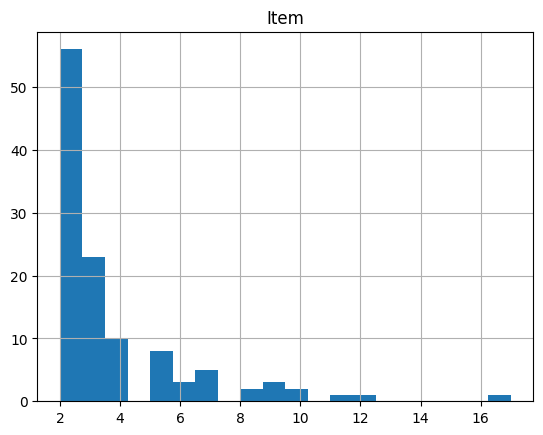

In [82]:
df_clusters_grafo.groupby('Cluster_ID').agg({'Item': 'count'}).hist(bins=20)

In [83]:
df_clusters_grafo.shape

(417, 2)

In [84]:
df_clusters_grafo.groupby('Cluster_ID').agg({'Item': 'count'}).sort_values(by='Item', ascending=False)

Item
Cluster_ID      
64            17
70            12
0             11
3             10
42            10
...          ...
107            2
110            2
111            2
113            2
114            2

[115 rows x 1 columns]

In [85]:
df_clusters_grafo[df_clusters_grafo['Cluster_ID'] == 64]

Item  Cluster_ID
219  SUPERMARKET_3_102          64
220  SUPERMARKET_3_388          64
221  SUPERMARKET_3_352          64
222  SUPERMARKET_3_182          64
223  SUPERMARKET_3_207          64
224  SUPERMARKET_3_655          64
225  SUPERMARKET_3_786          64
226  SUPERMARKET_3_357          64
227  SUPERMARKET_3_721          64
228  SUPERMARKET_3_825          64
229  SUPERMARKET_3_162          64
230  SUPERMARKET_3_819          64
231  SUPERMARKET_3_014          64
232  SUPERMARKET_3_569          64
233  SUPERMARKET_3_155          64
234  SUPERMARKET_3_293          64
235  SUPERMARKET_3_082          64

In [86]:
df_clusters_grafo[df_clusters_grafo['Cluster_ID'] == 70]

Item  Cluster_ID
256  SUPERMARKET_3_056          70
257  SUPERMARKET_3_478          70
258  SUPERMARKET_3_749          70
259  SUPERMARKET_3_736          70
260  SUPERMARKET_3_153          70
261  SUPERMARKET_3_567          70
262  SUPERMARKET_3_564          70
263  SUPERMARKET_3_663          70
264  SUPERMARKET_3_375          70
265  SUPERMARKET_3_465          70
266  SUPERMARKET_3_470          70
267  SUPERMARKET_3_373          70

In [87]:
df_clusters_grafo[df_clusters_grafo['Cluster_ID'] == 0]

Item  Cluster_ID
0   ACCESORIES_1_341           0
1   ACCESORIES_1_404           0
2   ACCESORIES_1_256           0
3   ACCESORIES_1_008           0
4   ACCESORIES_1_370           0
5   ACCESORIES_1_268           0
6   ACCESORIES_1_295           0
7   ACCESORIES_1_178           0
8   ACCESORIES_1_348           0
9   ACCESORIES_1_371           0
10  ACCESORIES_1_244           0

In [88]:
df_clusters_grafo_size = df_clusters_grafo.groupby('Cluster_ID').agg({'Item': 'count'}).sort_values(by='Item', ascending=False).reset_index().rename(columns={'Item': 'size'})

In [89]:
df_clusters_grafo = df_clusters_grafo.merge(df_clusters_grafo_size, on='Cluster_ID', how='left')

In [90]:
df_clusters_grafo.rename(columns={'Item': 'item'}, inplace=True)

In [91]:
df_items = df_items.merge(df_clusters_grafo, on='item', how='left')
df_items.rename(columns={'size': 'Sociability'}, inplace=True)              # Tamaño del grupo de articulos relacionados

In [92]:
df_items.loc[df_items['item'].isin(outliers), 'Sociability'] = 1   # Articulos que se venden solos

In [93]:
df_items['Sociability'].fillna(0, inplace=True)                     # Articulos descartados por no tener suficiente historial (por defecto 0)

/tmp/ipython-input-2494462569.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_items['Sociability'].fillna(0, inplace=True)                     # Articulos descartados por no tener suficiente historial (por defecto 0)


In [94]:
df_items.drop(columns=['Cluster_ID'], inplace=True)

In [95]:
df_items

item  sales_ratio_mean  sales_ratio_std  sell_price_mean  \
0      ACCESORIES_1_001          2.760999         0.800985        11.043445   
1      ACCESORIES_1_002          1.855793         1.081860         5.275790   
2      ACCESORIES_1_003          1.252894         0.707983         3.943779   
3      ACCESORIES_1_004         14.145769         3.234176         5.981574   
4      ACCESORIES_1_005          5.570844         2.352677         3.832410   
...                 ...               ...              ...              ...   
3044  SUPERMARKET_3_823          5.954361         5.302125         3.343141   
3045  SUPERMARKET_3_824          2.983871         2.076190         3.026692   
3046  SUPERMARKET_3_825          4.858045         3.274274         4.934241   
3047  SUPERMARKET_3_826          7.721777         2.386453         1.535795   
3048  SUPERMARKET_3_827         11.564945         5.682142         1.199478   

      sell_price_std  sales_ratio_relative_std  sell_price_relative_std  \
0           0.181601                  0.290107                 0.016444   
1           0.032435                  0.582964                 0.006148   
2           0.068217                  0.565078                 0.017297   
3           0.235091                  0.228632                 0.039302   
4           0.170571                  0.422320                 0.044507   
...              ...                       ...                      ...   
3044        0.205971                  0.890461                 0.061610   
3045        0.071883                  0.695804                 0.023750   
3046        0.213154                  0.673990                 0.043199   
3047        0.002624                  0.309055                 0.001708   
3048        0.005595                  0.491325                 0.004665   

      total_supply  release_week  Sociability  
0             1478           131          0.0  
1             2689             6          0.0  
2             1133           161          0.0  
3             2768             1          1.0  
4             2630            14          0.0  
...            ...           ...          ...  
3044          2668             1          1.0  
3045          2790             1          9.0  
3046          2787             1         17.0  
3047          1601           116          0.0  
3048           991           165          0.0  

[3049 rows x 10 columns]

#### Feature de tendencia lineal

In [96]:

def calculate_trend_slope(df):
    # 1. Agrupar por Item y Semana (Sumando ventas de todas las tiendas)
    # Esto crea una serie temporal única para cada producto
    weekly_sales = df.groupby(['item', 'yearweek'])['sale'].sum().reset_index()

    # 2. Asegurarnos de que el orden temporal es correcto
    weekly_sales = weekly_sales.sort_values(['item', 'yearweek'])

    # Lista para guardar resultados
    items = []
    slopes = []
    r_squared_values = []

    # 3. Iterar por cada item (es rápido para 3049 items)
    for item_id, group in weekly_sales.groupby('item'):
        y = group['sale'].values

        # Si el producto tiene muy pocos datos (< 4 semanas), la tendencia es ruido.
        # Le asignamos 0 (estable) o lo descartamos.
        if len(y) < 4:
            items.append(item_id)
            slopes.append(0)
            r_squared_values.append(0)
            continue

        # x es simplemente una secuencia [0, 1, 2, ... n]
        x = np.arange(len(y))

        # Calculamos la regresión lineal
        # slope = cuánto cambia la venta por cada semana que pasa
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        # 4. NORMALIZACIÓN CRÍTICA
        # Dividimos la pendiente por la media de ventas.
        # Esto convierte el valor en "% de cambio relativo"
        mean_sale = np.mean(y)

        # Evitar división por cero si la media es 0 (casos raros)
        if mean_sale == 0:
            normalized_slope = 0
        else:
            normalized_slope = slope / mean_sale *100

        items.append(item_id)
        slopes.append(normalized_slope)
        r_squared_values.append(r_value**2)

    # Crear el DataFrame final
    trend_df = pd.DataFrame({
        'item': items,
        '%trend_slope': slopes,
        'r_squared_value': r_squared_values
    })

    return trend_df

# Uso:
df_trends = calculate_trend_slope(df)
print(df_trends.head())

               item  %trend_slope  r_squared_value
0  ACCESORIES_1_001      0.364498         0.273747
1  ACCESORIES_1_002      0.046532         0.003950
2  ACCESORIES_1_003      0.978326         0.330432
3  ACCESORIES_1_004      0.030561         0.010902
4  ACCESORIES_1_005     -0.037274         0.004670


In [97]:
df_trends.shape

(3049, 3)

In [98]:
df_trends.sort_values('%trend_slope', ascending=False)

item  %trend_slope  r_squared_value
2520    SUPERMARKET_3_296      2.994023         0.166759
832   HOME_&_GARDEN_1_274      2.596979         0.566226
801   HOME_&_GARDEN_1_242      2.509866         0.499106
180      ACCESORIES_1_186      2.314906         0.497282
2079    SUPERMARKET_2_253      2.290955         0.617445
...                   ...           ...              ...
611   HOME_&_GARDEN_1_049     -1.988171         0.267233
1787    SUPERMARKET_1_179     -2.066782         0.364606
2871    SUPERMARKET_3_647     -2.140383         0.432458
2228    SUPERMARKET_3_003     -2.214350         0.288554
326      ACCESORIES_1_335     -2.267604         0.478991

[3049 rows x 3 columns]

In [99]:
df_trends.sort_values('r_squared_value', ascending=False)

item  %trend_slope  r_squared_value
2545    SUPERMARKET_3_321      1.278250     8.222859e-01
2954    SUPERMARKET_3_732     -0.711837     8.219418e-01
841   HOME_&_GARDEN_1_283      1.294331     8.059749e-01
253      ACCESORIES_1_261      1.008906     7.810416e-01
582   HOME_&_GARDEN_1_018      0.702461     7.715390e-01
...                   ...           ...              ...
505      ACCESORIES_2_090      0.001323     3.366758e-07
1940    SUPERMARKET_2_114     -0.000736     1.079001e-07
965   HOME_&_GARDEN_1_410     -0.000164     1.847334e-08
3022    SUPERMARKET_3_801      0.000049     7.067640e-09
688   HOME_&_GARDEN_1_128     -0.000024     1.811799e-09

[3049 rows x 3 columns]

Text(0.5, 1.0, 'Scatter Plot of %trend_slope vs r_squared_value')

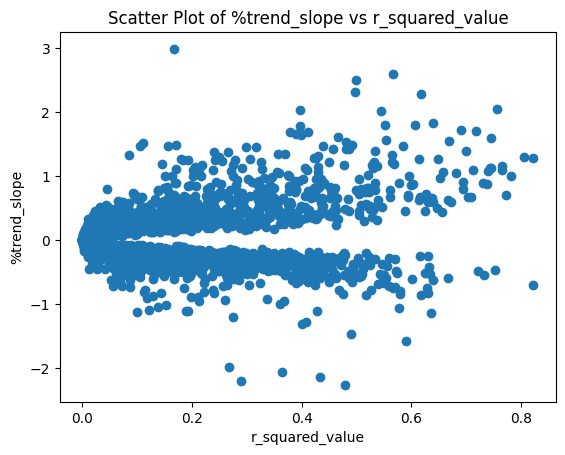

In [100]:
#Realizamos scatter plot %trend_slope vs r_squared_value

plt.scatter(df_trends['r_squared_value'], df_trends['%trend_slope'])
plt.xlabel('r_squared_value')
plt.ylabel('%trend_slope')
plt.title('Scatter Plot of %trend_slope vs r_squared_value')

<Axes: >

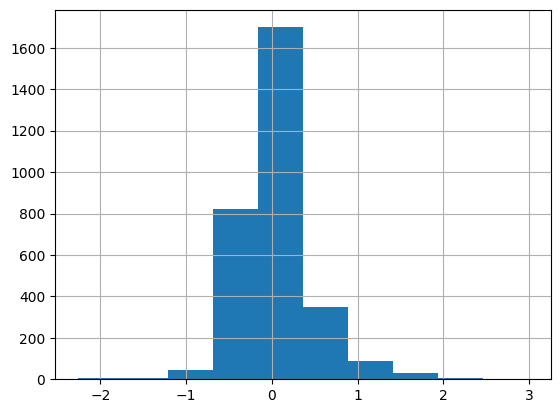

In [101]:
df_trends['%trend_slope'].hist()

In [102]:
confidence_umbral_r_squared = 0.3
df_trends[df_trends['r_squared_value'] >= confidence_umbral_r_squared].shape

(490, 3)

In [103]:
df_trends.loc[df_trends['r_squared_value'] < confidence_umbral_r_squared, '%trend_slope'] = 0
df_trends.loc[df_trends['r_squared_value'] < confidence_umbral_r_squared, 'r_squared_value'] = 0

Text(0.5, 1.0, 'Scatter Plot of %trend_slope vs r_squared_value')

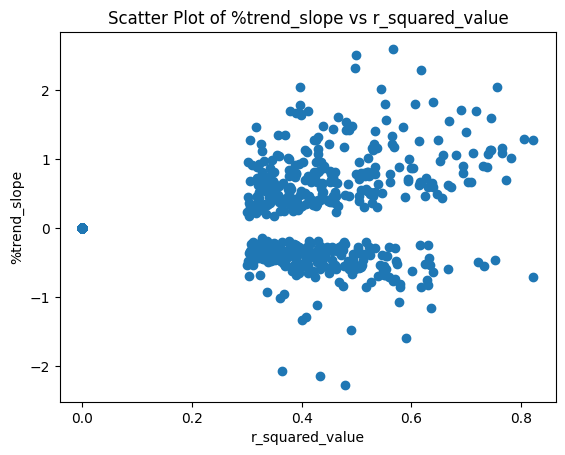

In [104]:
#Realizamos scatter plot %trend_slope vs r_squared_value

plt.scatter(df_trends['r_squared_value'], df_trends['%trend_slope'])
plt.xlabel('r_squared_value')
plt.ylabel('%trend_slope')
plt.title('Scatter Plot of %trend_slope vs r_squared_value')

<Axes: >

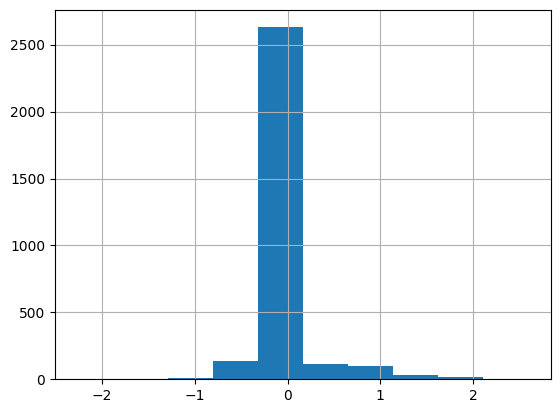

In [105]:
df_trends['%trend_slope'].hist()

#### Feature de elasticidad de demanda

In [106]:
def calculate_price_elasticity_proxy(df):
    items = []
    elasticities = []

    # Agrupamos por item
    for item_id, group in df.groupby('item'):
        # Validación crítica: ¿El precio cambió alguna vez?
        if group['sell_price'].std() == 0:
            # Si el precio es fijo, la elasticidad es "neutral" (0) para fines prácticos
            # o podrías marcarlo como un valor aparte. Usaremos 0 por simplicidad.
            elasticity = 0
        else:
            # Usamos Spearman porque captura relaciones no lineales mejor
            elasticity = group['sale'].corr(group['sell_price'], method='spearman')

            # Si da NaN por alguna razón matemática rara, lo volvemos 0
            if pd.isna(elasticity):
                elasticity = 0

        items.append(item_id)
        elasticities.append(elasticity)

    return pd.DataFrame({'item': items, 'price_elasticity': elasticities})

In [107]:
df_elasticity = calculate_price_elasticity_proxy(df_total_demand)

/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


In [108]:
df_elasticity.sort_values('price_elasticity', ascending=False)

item  price_elasticity
473      ACCESORIES_2_058          0.965284
875   HOME_&_GARDEN_1_317          0.883453
2754    SUPERMARKET_3_530          0.882939
2545    SUPERMARKET_3_321          0.857852
1084  HOME_&_GARDEN_1_529          0.851429
...                   ...               ...
146      ACCESORIES_1_151         -0.769889
345      ACCESORIES_1_354         -0.775453
391      ACCESORIES_1_400         -0.781003
129      ACCESORIES_1_134         -0.795500
582   HOME_&_GARDEN_1_018         -0.871323

[3049 rows x 2 columns]

<Axes: >

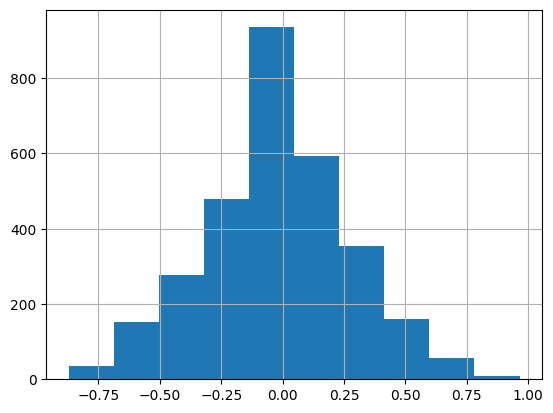

In [109]:
df_elasticity['price_elasticity'].hist()

## Anexamos features en data set de clustering

### Generamos df_cluster

In [143]:
df_items.columns

Index(['item', 'sales_ratio_mean', 'sales_ratio_std', 'sell_price_mean',
       'sell_price_std', 'sales_ratio_relative_std', 'sell_price_relative_std',
       'total_supply', 'release_week', 'Sociability'],
      dtype='object')

In [144]:
df_cluster = df_items.copy()

In [145]:
df_cluster = df_cluster.merge(df_region_sales_normalized[['item', 'Regionality']], on='item', how='left')

In [146]:
df_cluster = df_cluster.merge(df_seasson_sales_normalized[['item', 'Seasonality']], on='item', how='left')

In [147]:
df_cluster = df_cluster.merge(df_trends[['item', '%trend_slope']], on='item', how='left')

In [148]:
df_cluster = df_cluster.merge(df_elasticity[['item', 'price_elasticity']], on='item', how='left')

In [149]:
df_cluster

item  sales_ratio_mean  sales_ratio_std  sell_price_mean  \
0      ACCESORIES_1_001          2.760999         0.800985        11.043445   
1      ACCESORIES_1_002          1.855793         1.081860         5.275790   
2      ACCESORIES_1_003          1.252894         0.707983         3.943779   
3      ACCESORIES_1_004         14.145769         3.234176         5.981574   
4      ACCESORIES_1_005          5.570844         2.352677         3.832410   
...                 ...               ...              ...              ...   
3044  SUPERMARKET_3_823          5.954361         5.302125         3.343141   
3045  SUPERMARKET_3_824          2.983871         2.076190         3.026692   
3046  SUPERMARKET_3_825          4.858045         3.274274         4.934241   
3047  SUPERMARKET_3_826          7.721777         2.386453         1.535795   
3048  SUPERMARKET_3_827         11.564945         5.682142         1.199478   

      sell_price_std  sales_ratio_relative_std  sell_price_relative_std  \
0           0.181601                  0.290107                 0.016444   
1           0.032435                  0.582964                 0.006148   
2           0.068217                  0.565078                 0.017297   
3           0.235091                  0.228632                 0.039302   
4           0.170571                  0.422320                 0.044507   
...              ...                       ...                      ...   
3044        0.205971                  0.890461                 0.061610   
3045        0.071883                  0.695804                 0.023750   
3046        0.213154                  0.673990                 0.043199   
3047        0.002624                  0.309055                 0.001708   
3048        0.005595                  0.491325                 0.004665   

      total_supply  release_week  Sociability  Regionality  Seasonality  \
0             1478           131          0.0     0.400899     0.150287   
1             2689             6          0.0     0.366412     0.127449   
2             1133           161          0.0     0.178200     0.104309   
3             2768             1          1.0     0.315894     0.030596   
4             2630            14          0.0     0.212243     0.097256   
...            ...           ...          ...          ...          ...   
3044          2668             1          1.0     0.426184     0.178674   
3045          2790             1          9.0     0.255315     0.181700   
3046          2787             1         17.0     0.087434     0.102321   
3047          1601           116          0.0     0.128765     0.141586   
3048           991           165          0.0     0.365767     0.145406   

      %trend_slope  price_elasticity  
0         0.000000         -0.330625  
1         0.000000         -0.059177  
2         0.978326          0.029035  
3         0.000000          0.308701  
4         0.000000         -0.369176  
...            ...               ...  
3044      0.000000         -0.267991  
3045     -0.582225          0.133880  
3046      0.000000         -0.338183  
3047      0.000000         -0.088758  
3048      1.168236         -0.141081  

[3049 rows x 14 columns]

In [150]:
df_cluster.shape

(3049, 14)

In [154]:
df_cluster.columns

Index(['item', 'sales_ratio_mean', 'sales_ratio_std', 'sell_price_mean',
       'sell_price_std', 'sales_ratio_relative_std', 'sell_price_relative_std',
       'total_supply', 'release_week', 'Sociability', 'Regionality',
       'Seasonality', '%trend_slope', 'price_elasticity'],
      dtype='object')

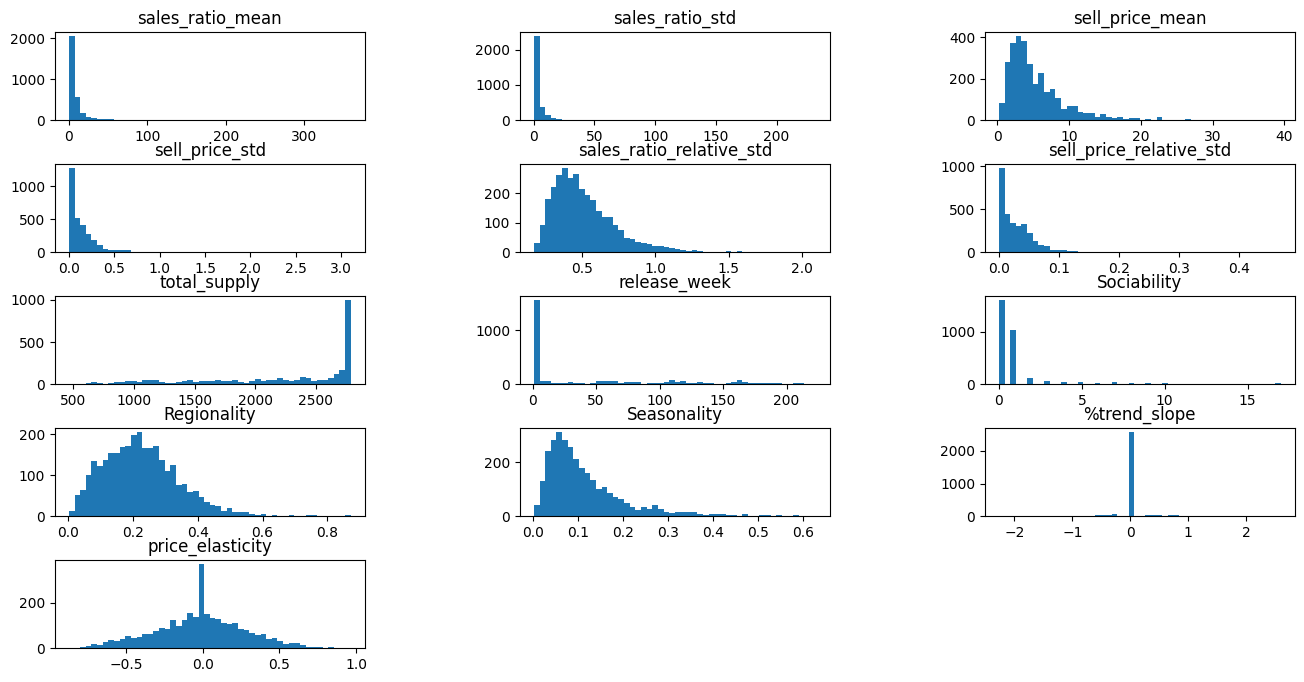

In [151]:
## Graficamos los histogramas de las columnas de tipo no object

fig = plt.figure(figsize= (16,8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

j = 0
for i in df_cluster.columns:
  if df_cluster[i].dtype != 'object':
    j += 1
    fig.add_subplot(5, 3, j)
    plt.hist(df_cluster[i], bins = 50)
    plt.title(i)

<Axes: >

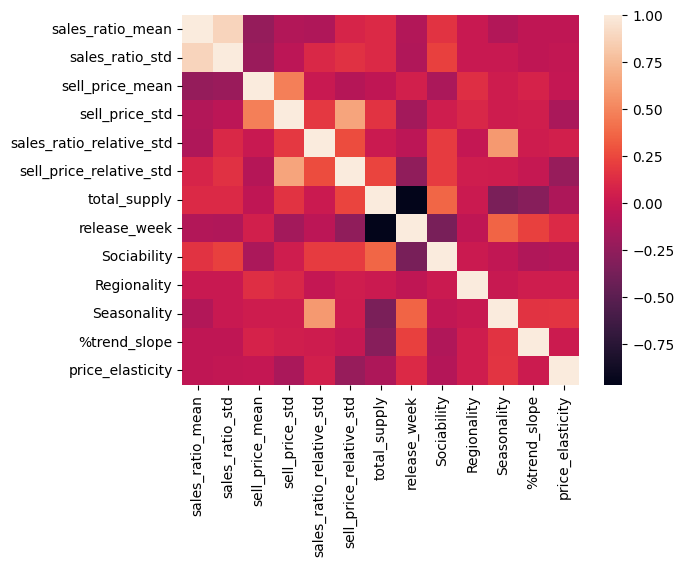

In [152]:
#Visualizamos matriz de corr de features

sns.heatmap(df_cluster.drop(columns=['item'], errors='ignore').corr())

In [155]:
# Desestimamos features de alta correlacion, redundantes
# sale_ratio_std, sell_price_std, release_week

df_cluster.drop(columns=['sales_ratio_std', 'sell_price_std', 'release_week'], inplace=True)


In [156]:
# Desestimamos features de baja variabilidad
# sell_price_relative_std

df_cluster.drop(columns=['sell_price_relative_std'], inplace=True)

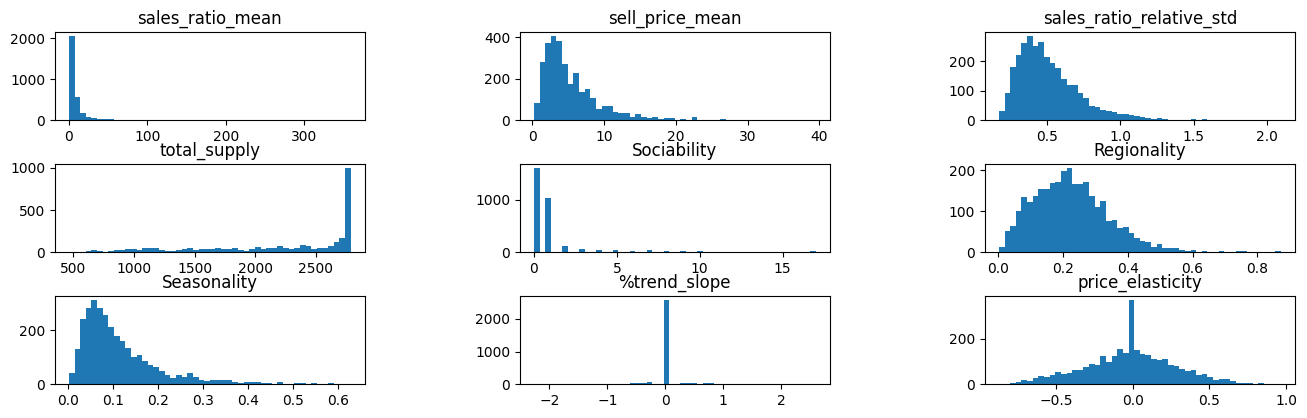

In [157]:
## Graficamos los histogramas de las columnas de tipo no object

fig = plt.figure(figsize= (16,8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

j = 0
for i in df_cluster.columns:
  if df_cluster[i].dtype != 'object':
    j += 1
    fig.add_subplot(5, 3, j)
    plt.hist(df_cluster[i], bins = 50)
    plt.title(i)

<Axes: >

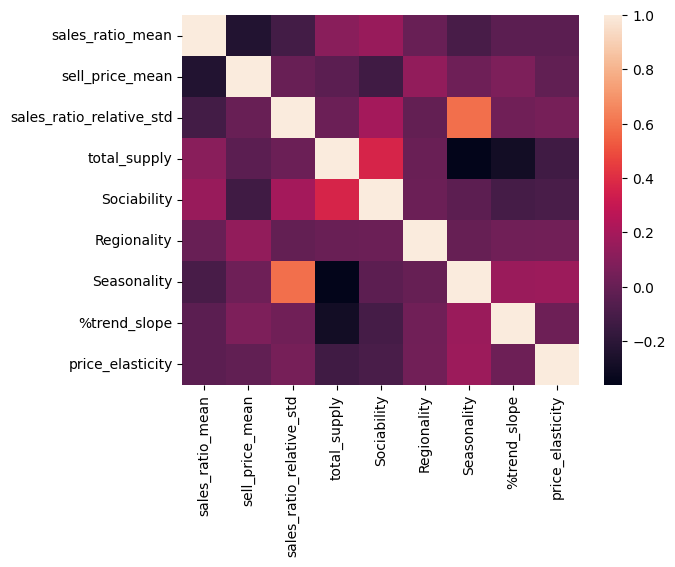

In [158]:
#Visualizamos matriz de corr de features

sns.heatmap(df_cluster.drop(columns=['item'], errors='ignore').corr())

### REFACTORIZAMOS K-MEANS

Iteracion 1, cantidad de features: 6, features: ['sales_ratio_mean', 'Sociability', 'total_supply', 'Seasonality', 'Regionality', '%trend_slope']
Iteracion 2, cantidad de features: 6, features: ['total_supply', 'Sociability', 'sales_ratio_mean', '%trend_slope', 'Regionality', 'sell_price_mean']
Iteracion 3, cantidad de features: 5, features: ['sales_ratio_mean', 'Seasonality', 'sales_ratio_relative_std', 'total_supply', 'price_elasticity']
Iteracion 4, cantidad de features: 7, features: ['sell_price_mean', 'Regionality', '%trend_slope', 'price_elasticity', 'total_supply', 'Sociability', 'sales_ratio_mean']
Iteracion 5, cantidad de features: 6, features: ['price_elasticity', '%trend_slope', 'sales_ratio_mean', 'Regionality', 'sell_price_mean', 'sales_ratio_relative_std']
Iteracion 6, cantidad de features: 3, features: ['total_supply', '%trend_slope', 'sell_price_mean']
Iteracion 7, cantidad de features: 4, features: ['%trend_slope', 'Seasonality', 'sales_ratio_relative_std', 'Regionalit

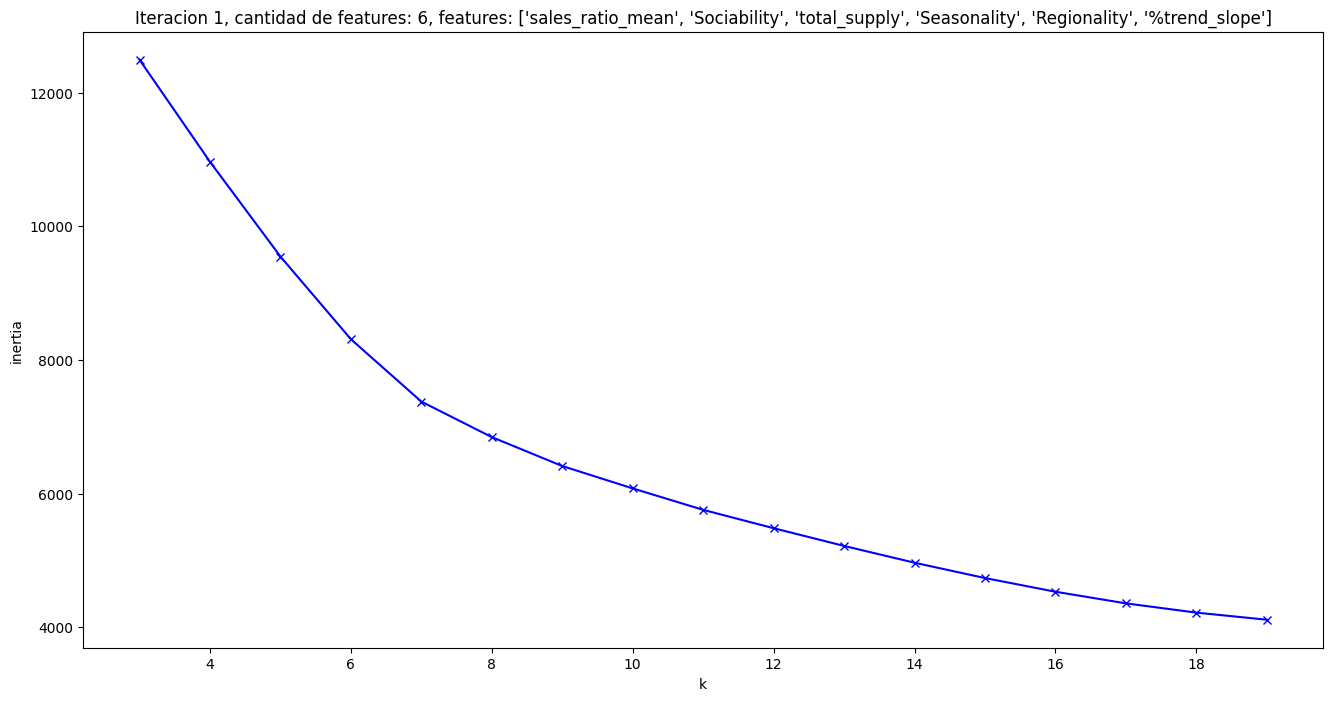

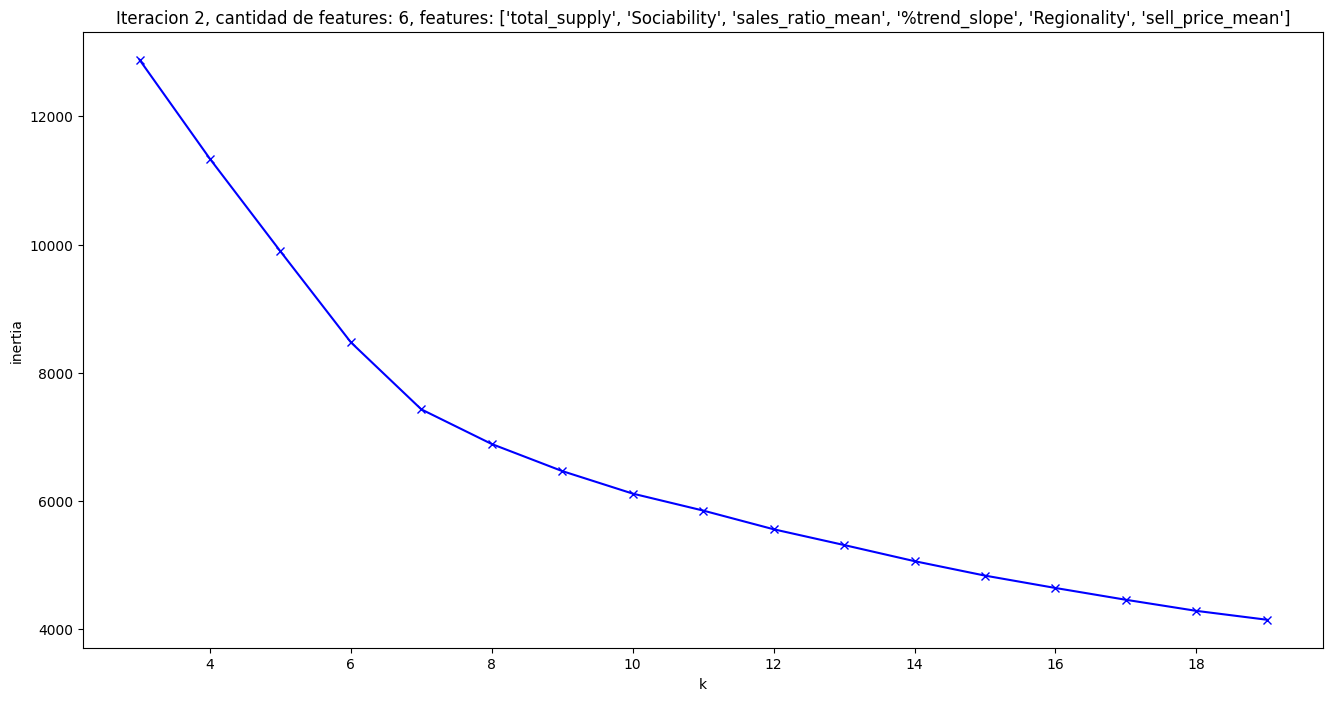

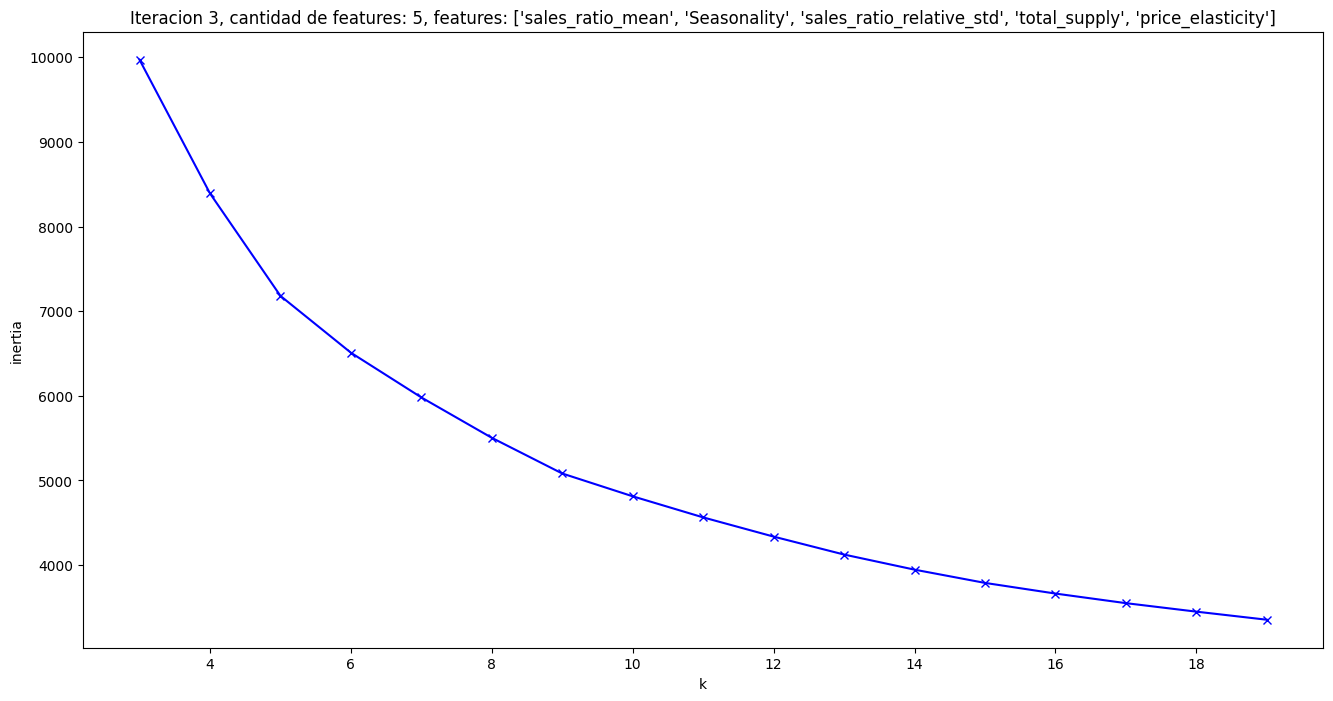

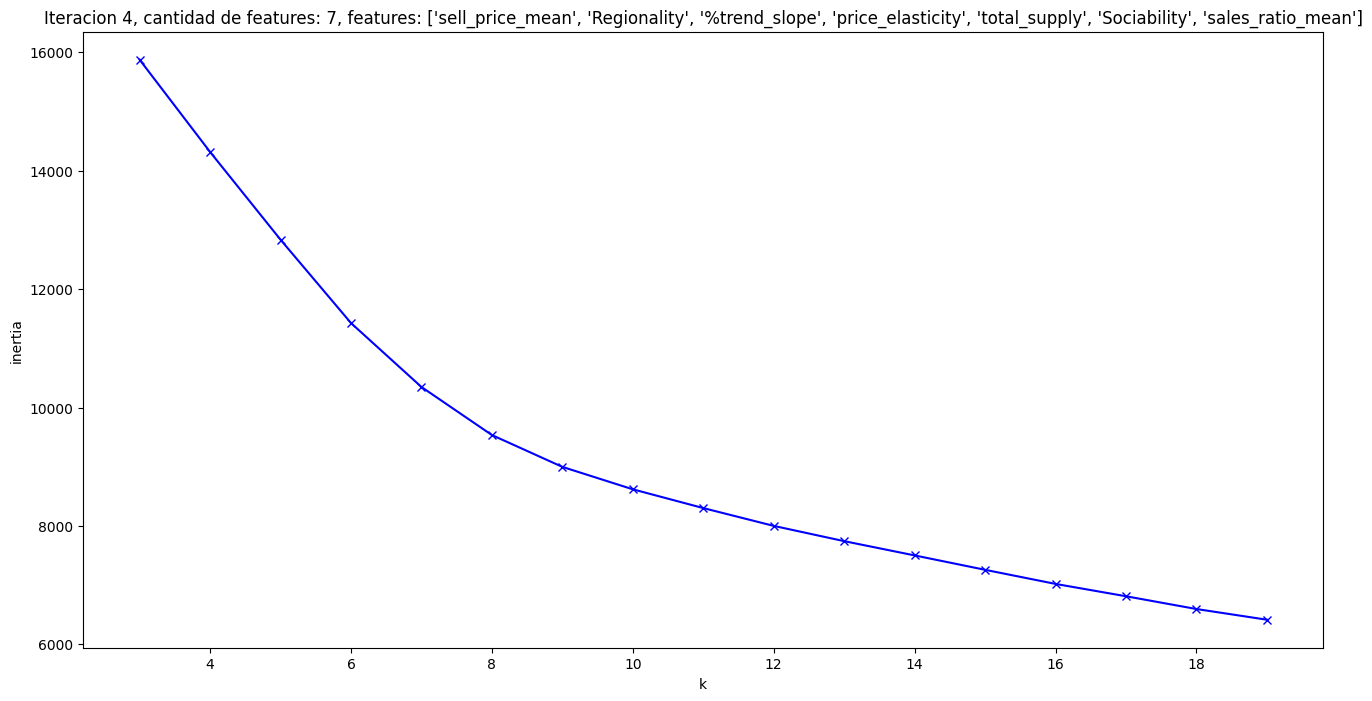

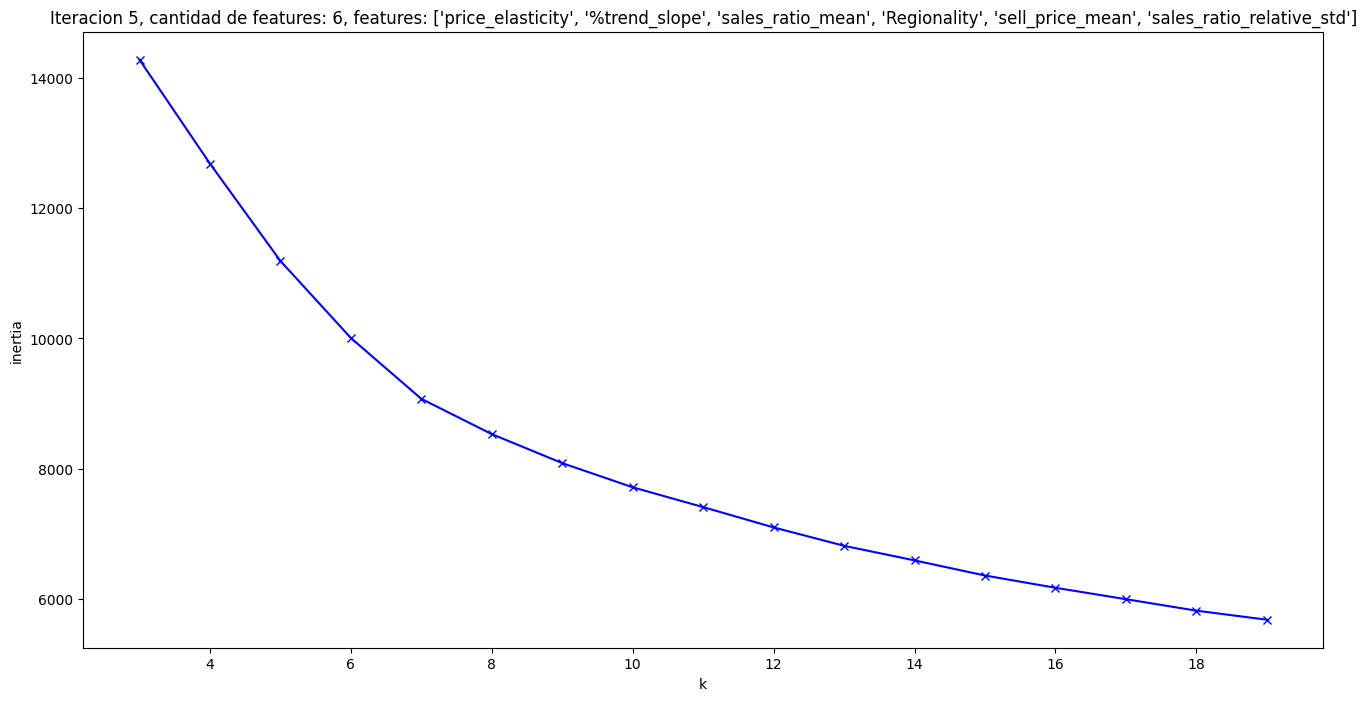

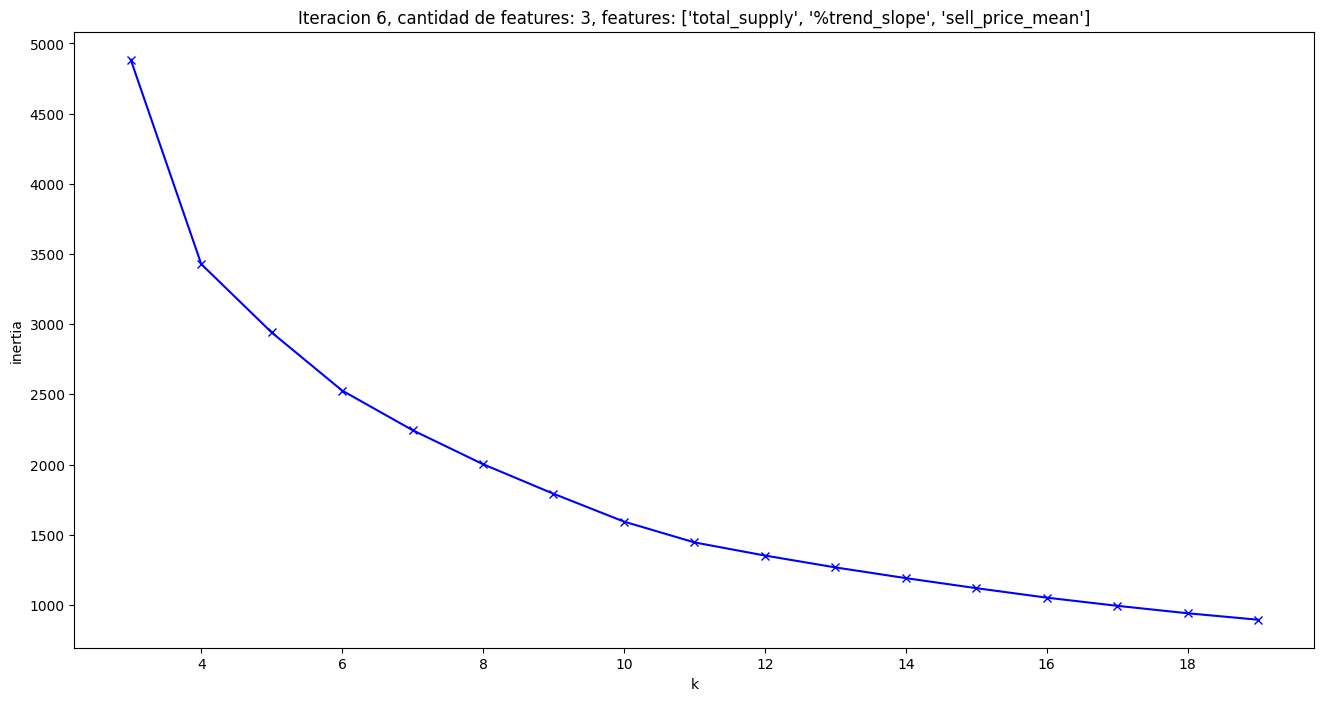

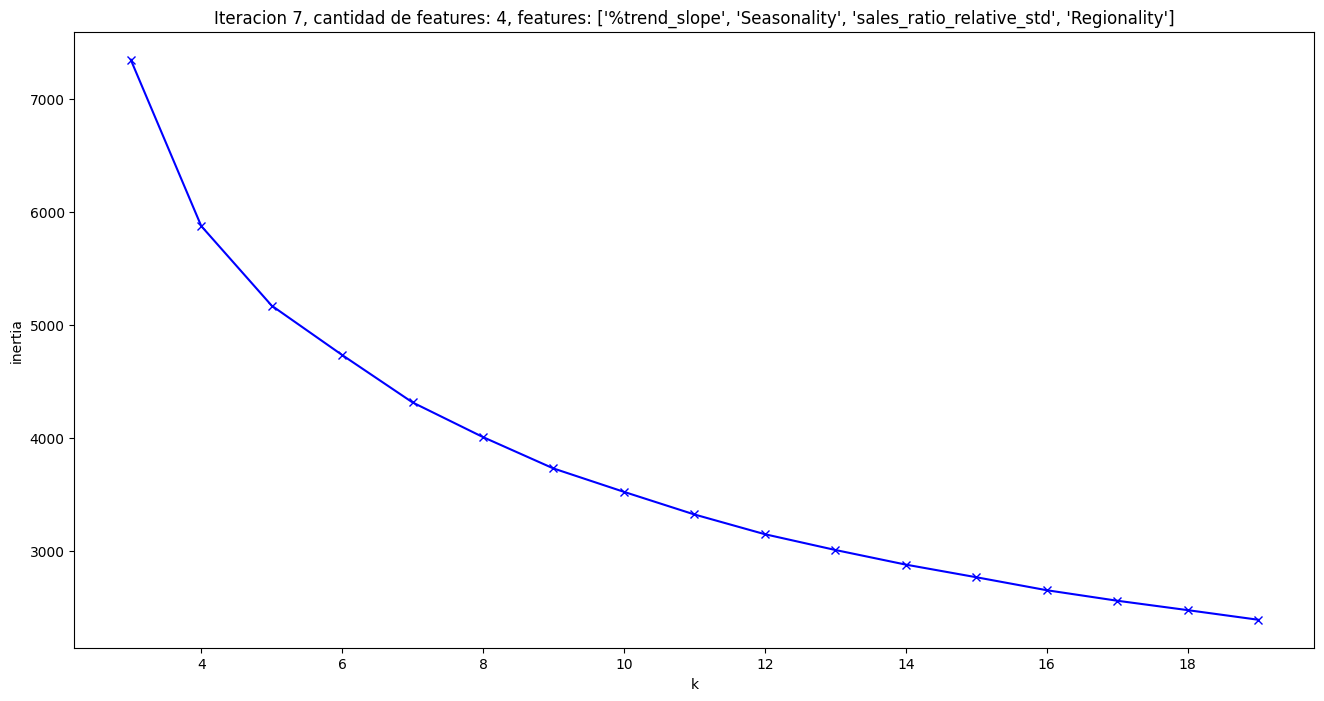

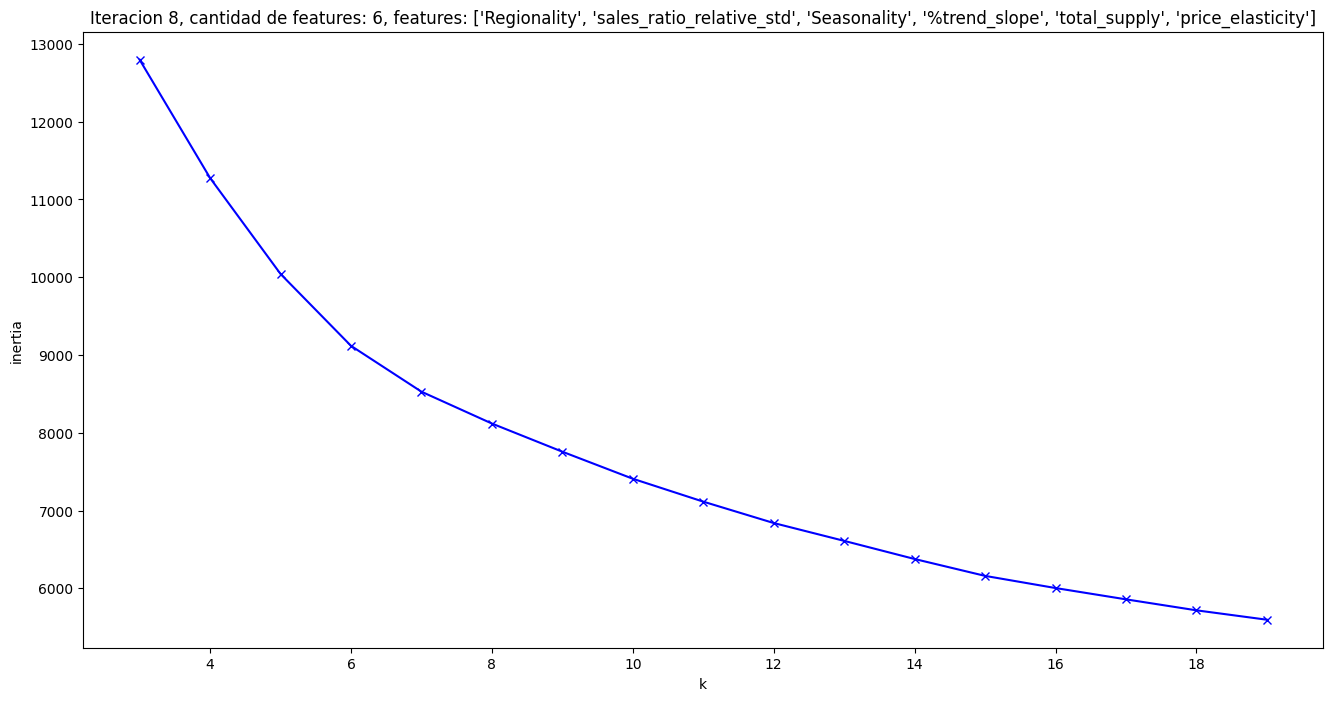

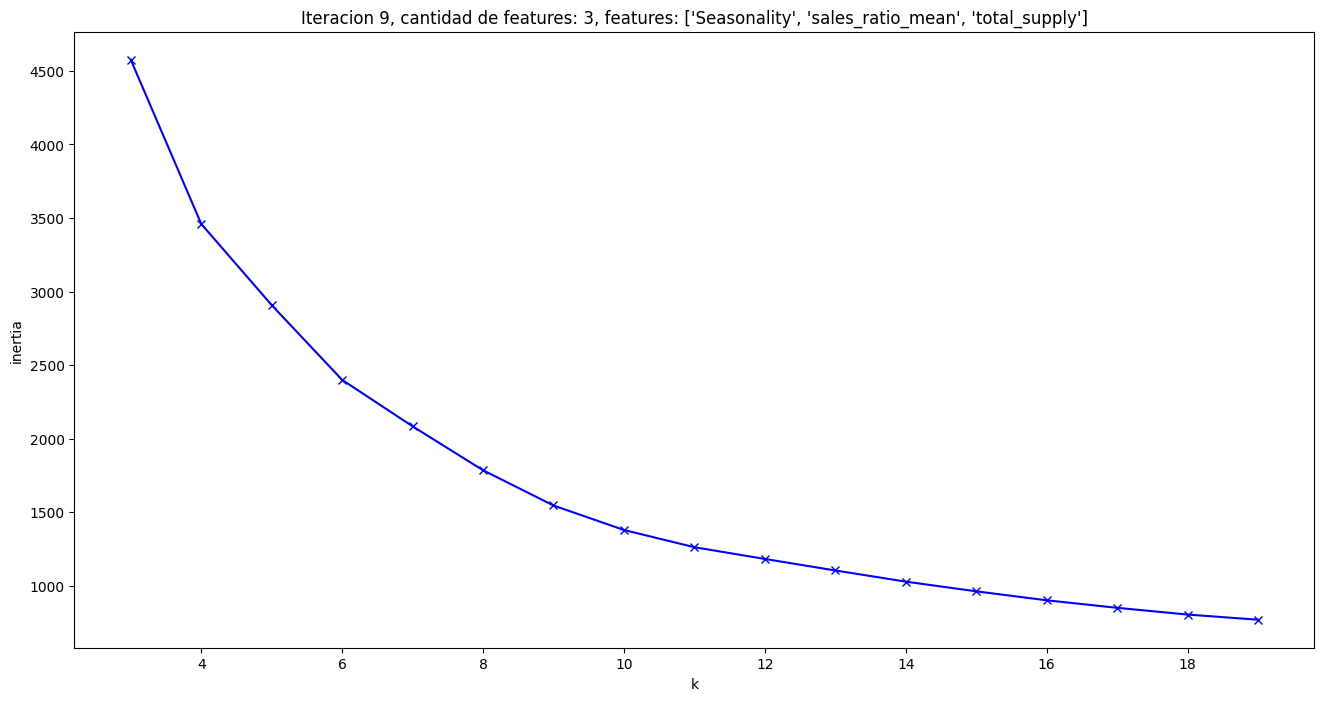

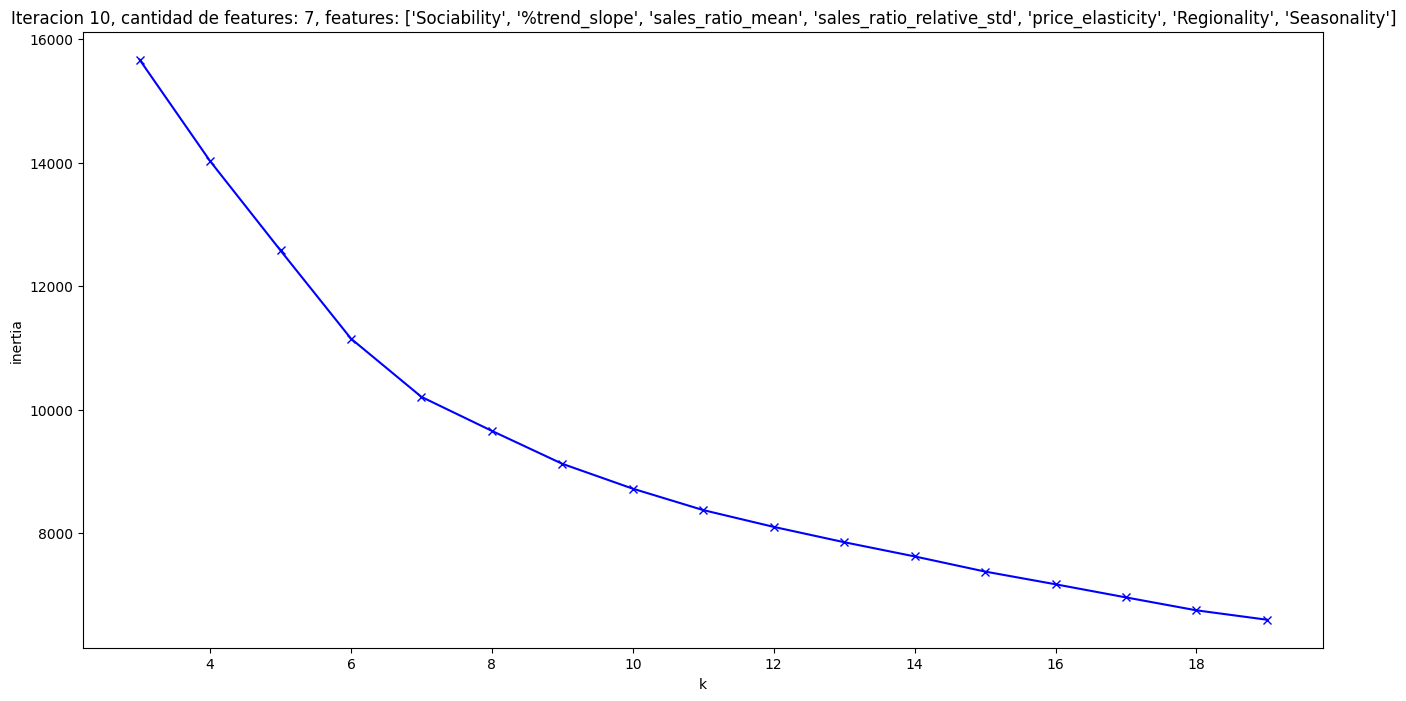

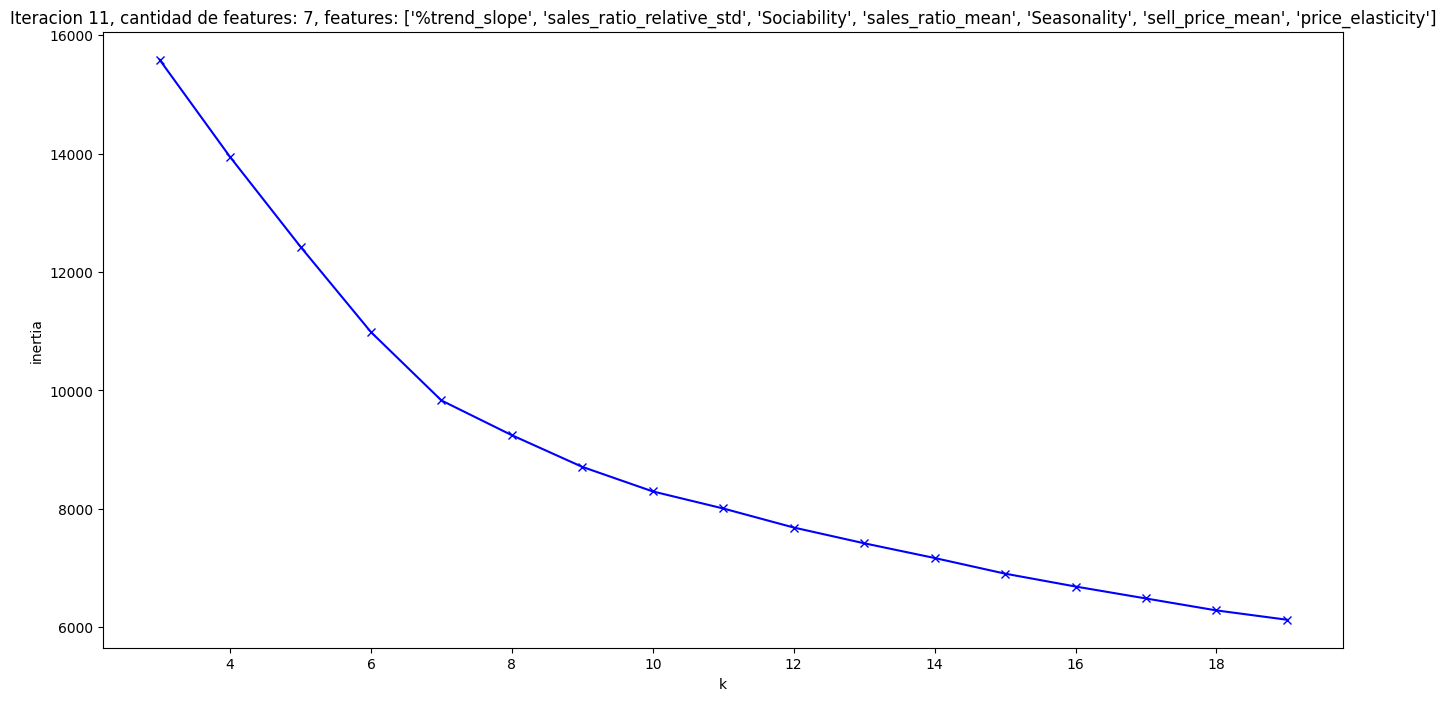

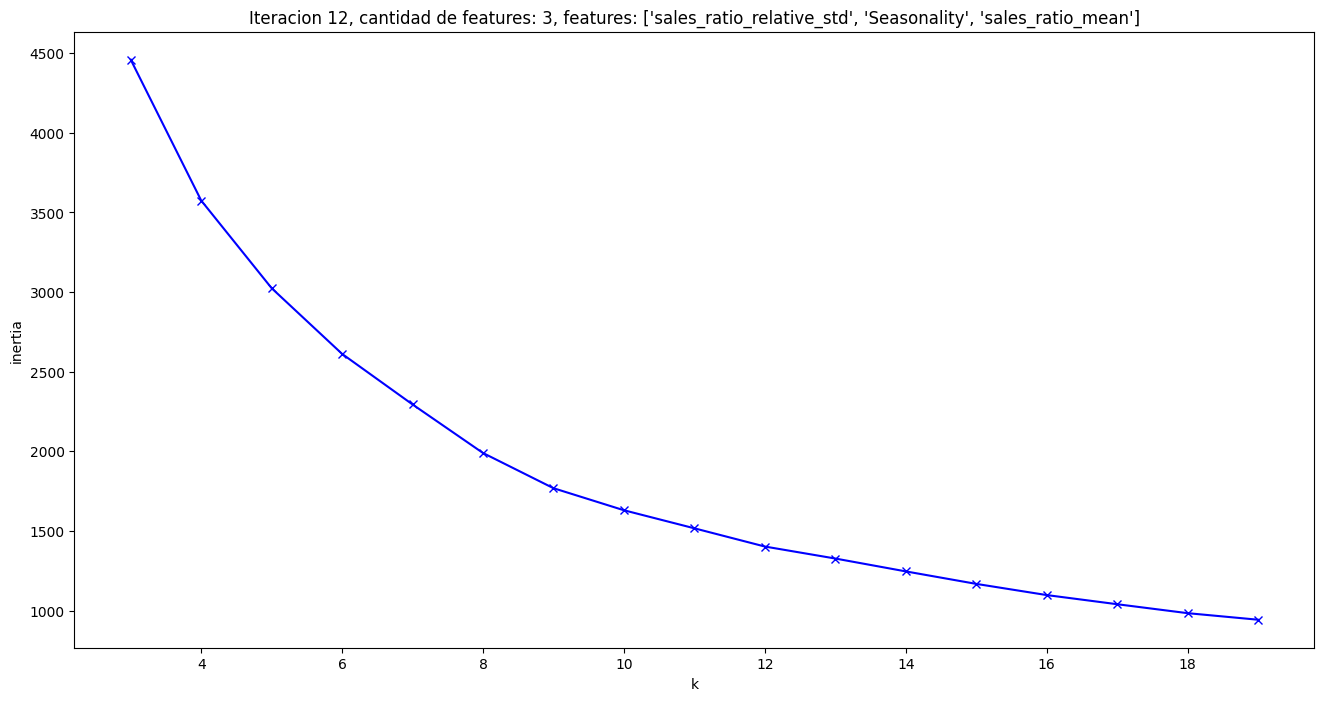

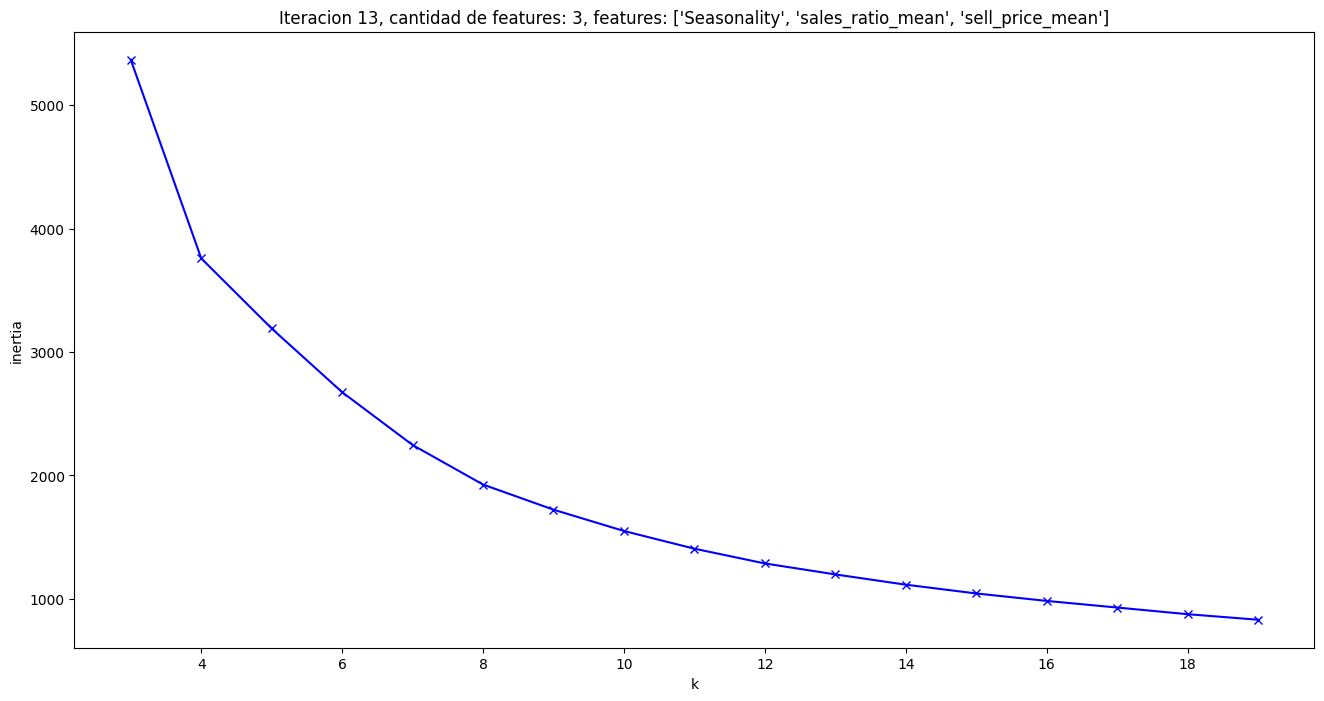

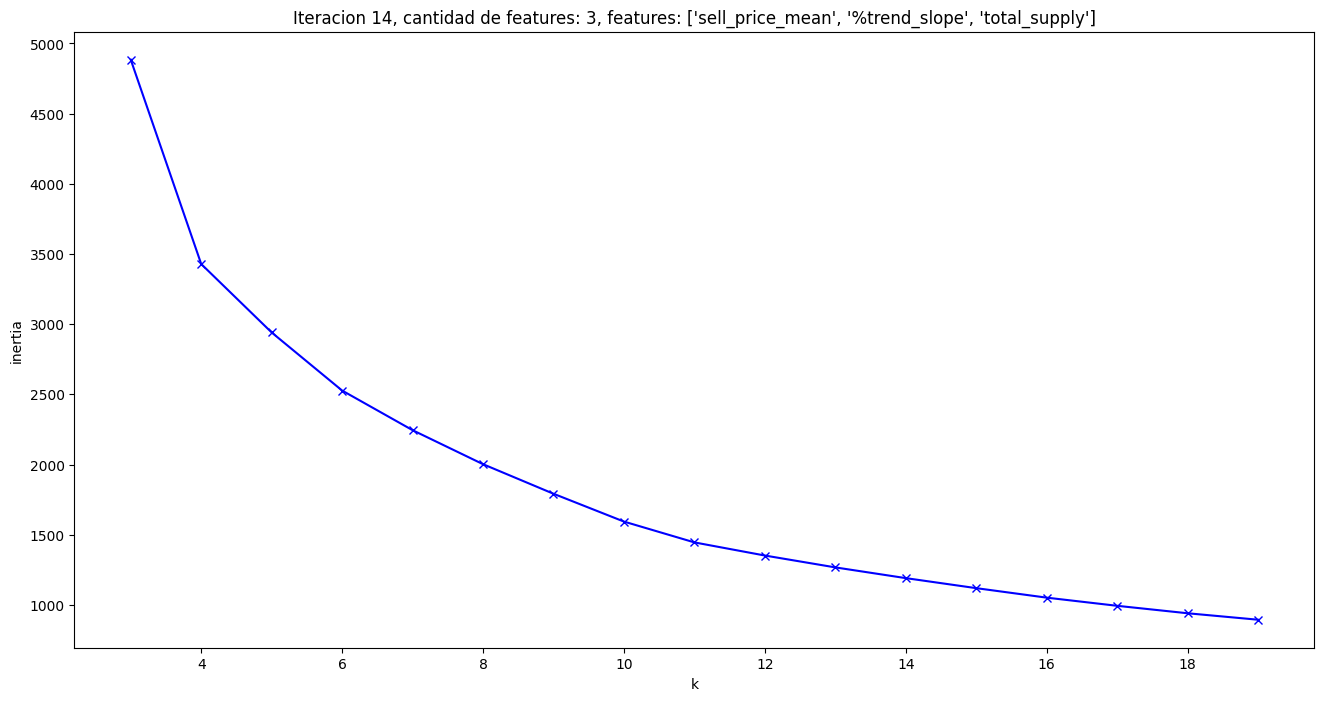

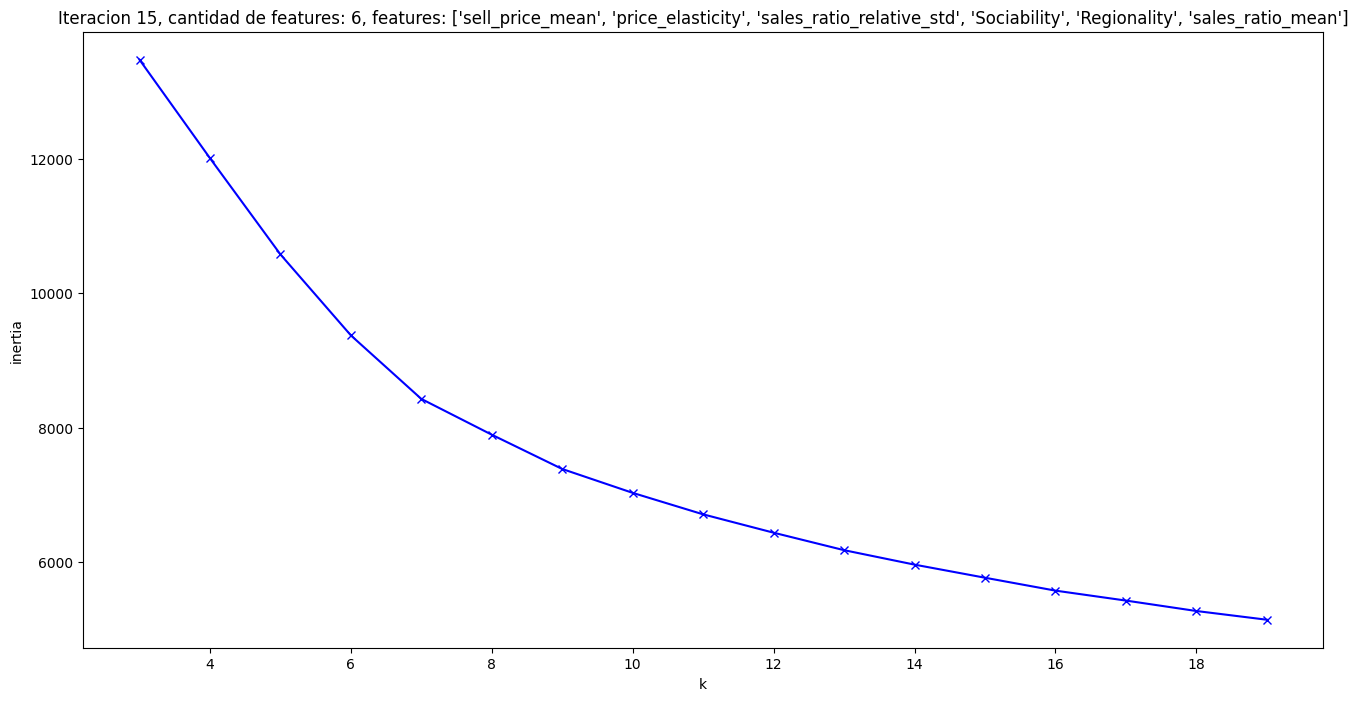

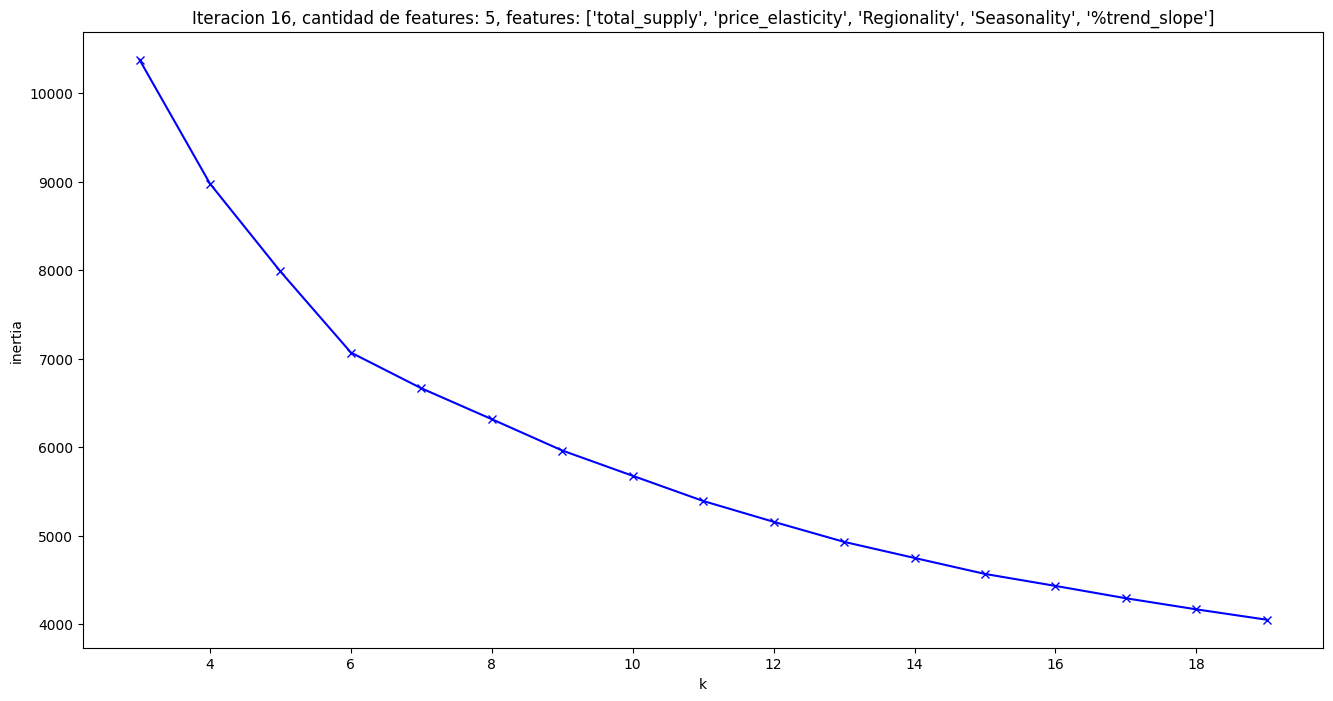

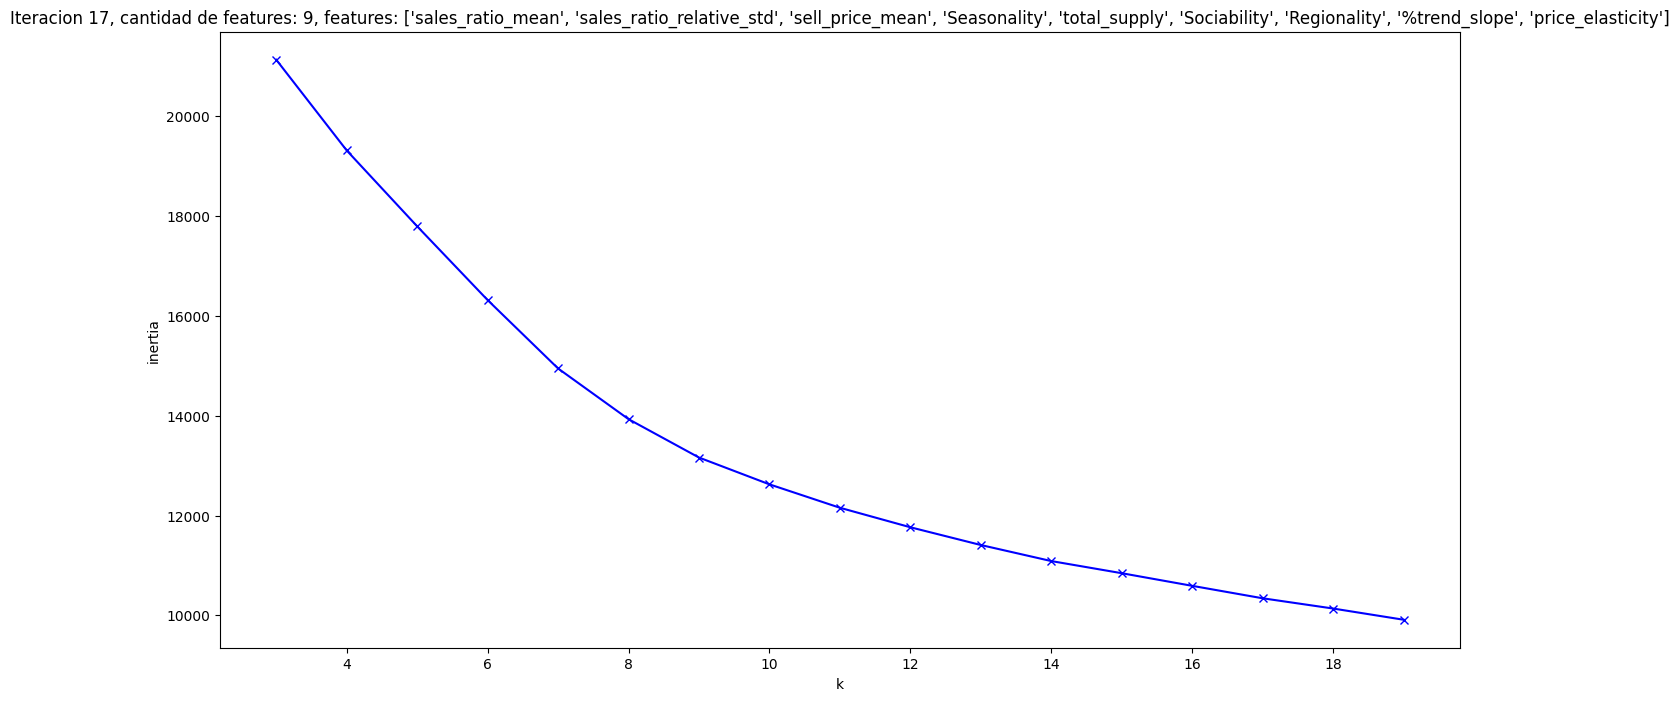

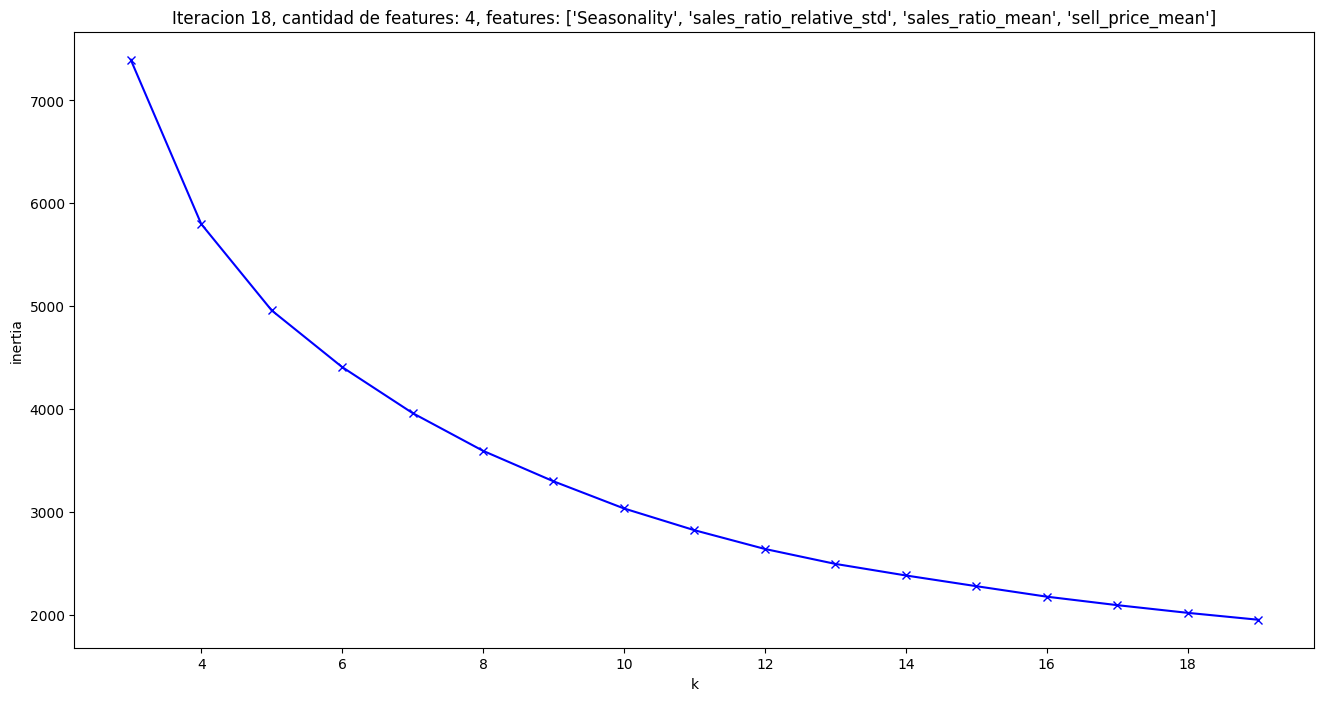

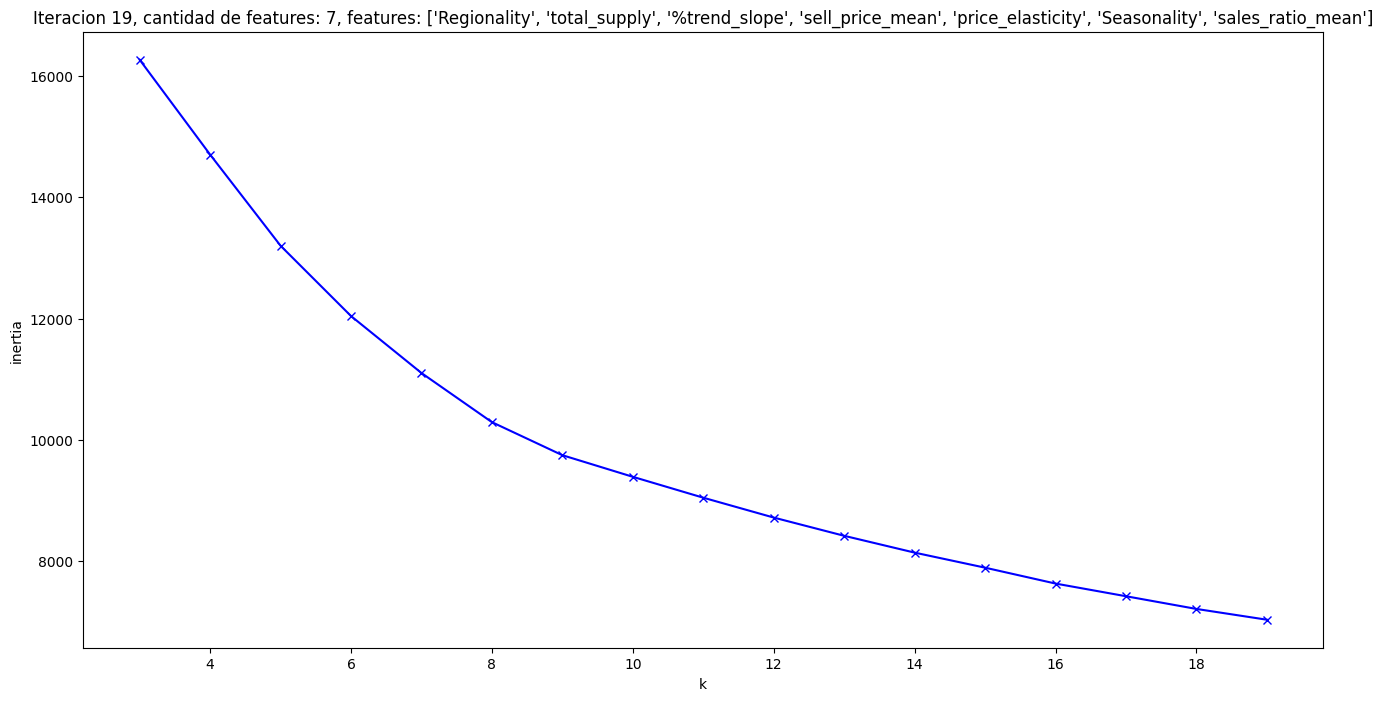

In [159]:


if 'item' in df_cluster.columns:
  df_cluster.drop(columns='item', inplace=True)
if 'cluster' in df_cluster.columns:
  df_cluster.drop(columns='cluster', inplace=True)

features_clusters = df_cluster.columns

pipe_line = Pipeline([('scaler', StandardScaler())])

df_cluster_scaled = pipe_line.fit_transform(df_cluster)

n_tries = 19
set_k = range(3, 20)
dict_clustering = {}
dict_try = {}
n_inizializations = 50
full_experiment = 0



for i_try in range(n_tries):
  n_features = random.randint(3, len(features_clusters) - full_experiment)
  if (n_features == len(features_clusters) and (full_experiment == 0)) :
    full_experiment = 1
  selected_features = random.sample(list(features_clusters), n_features)
  df_cluster_reduced = df_cluster_scaled[selected_features]
  dict_clustering = {}
  inertia = 0
  for k in set_k:
    for i in range(n_inizializations):
      kmeans = KMeans(n_clusters=k, random_state=i).fit(df_cluster_reduced)
      if (i == 0 or kmeans.inertia_ < inertia):
#        print(f'best try {i}')
        inertia = kmeans.inertia_
        best_kmeans = kmeans
        dict_clustering[k] = [kmeans.inertia_, n_features, i, selected_features]

  #    dict_clustering[k] = [kmeans.inertia_, kmeans.score(df_cluster_scaled), kmeans.cluster_centers_, selected_features]
  #    dict_try[i_try] = [k, kmeans.inertia_, kmeans.score(df_cluster_scaled), kmeans.cluster_centers_, selected_features]

  dict_try[i_try] = dict_clustering

  fig = plt.figure(figsize= (16,8))
  plt.plot(set_k, [dict_clustering[k][0] for k in set_k], 'bx-')
  plt.xlabel('k')
  plt.ylabel('inertia')
  plt.title(f'Iteracion {i_try + 1}, cantidad de features: {n_features}, features: {selected_features}')


  print(f'Iteracion {i_try + 1}, cantidad de features: {n_features}, features: {selected_features}')





In [160]:
print(dict_try)

{0: {3: [12491.23012894816, 6, 32, ['sales_ratio_mean', 'Sociability', 'total_supply', 'Seasonality', 'Regionality', '%trend_slope']], 4: [10964.440376517827, 6, 45, ['sales_ratio_mean', 'Sociability', 'total_supply', 'Seasonality', 'Regionality', '%trend_slope']], 5: [9546.368152075202, 6, 3, ['sales_ratio_mean', 'Sociability', 'total_supply', 'Seasonality', 'Regionality', '%trend_slope']], 6: [8309.758585581212, 6, 32, ['sales_ratio_mean', 'Sociability', 'total_supply', 'Seasonality', 'Regionality', '%trend_slope']], 7: [7376.331473992248, 6, 1, ['sales_ratio_mean', 'Sociability', 'total_supply', 'Seasonality', 'Regionality', '%trend_slope']], 8: [6844.853554207034, 6, 26, ['sales_ratio_mean', 'Sociability', 'total_supply', 'Seasonality', 'Regionality', '%trend_slope']], 9: [6412.228147542034, 6, 14, ['sales_ratio_mean', 'Sociability', 'total_supply', 'Seasonality', 'Regionality', '%trend_slope']], 10: [6077.308087629434, 6, 14, ['sales_ratio_mean', 'Sociability', 'total_supply', 'Se

In [161]:
df_tries = pd.DataFrame(dict_try)
df_tries.transpose()

3   \
0   [12491.23012894816, 6, 32, [sales_ratio_mean, ...   
1   [12883.391875609152, 6, 46, [total_supply, Soc...   
2   [9971.898179727352, 5, 21, [sales_ratio_mean, ...   
3   [15875.503691541868, 7, 2, [sell_price_mean, R...   
4   [14272.844961983148, 6, 24, [price_elasticity,...   
5   [4883.708773178841, 3, 7, [total_supply, %tren...   
6   [7350.63221735697, 4, 3, [%trend_slope, Season...   
7   [12796.843080635277, 6, 43, [Regionality, sale...   
8   [4575.807855181194, 3, 0, [Seasonality, sales_...   
9   [15663.973465570676, 7, 45, [Sociability, %tre...   
10  [15587.283288787079, 7, 45, [%trend_slope, sal...   
11  [4459.031017545927, 3, 1, [sales_ratio_relativ...   
12  [5368.588991361376, 3, 3, [Seasonality, sales_...   
13  [4883.70877317884, 3, 7, [sell_price_mean, %tr...   
14  [13477.26998278375, 6, 18, [sell_price_mean, p...   
15  [10378.498860050084, 5, 38, [total_supply, pri...   
16  [21132.792812725187, 9, 35, [sales_ratio_mean,...   
17  [7395.410771634318, 4, 5, [Seasonality, sales_...   
18  [16265.30944707458, 7, 26, [Regionality, total...   

                                                   4   \
0   [10964.440376517827, 6, 45, [sales_ratio_mean,...   
1   [11337.268770643512, 6, 25, [total_supply, Soc...   
2   [8392.374093276492, 5, 45, [sales_ratio_mean, ...   
3   [14317.293637923674, 7, 33, [sell_price_mean, ...   
4   [12679.298358497625, 6, 31, [price_elasticity,...   
5   [3428.318818122275, 3, 4, [total_supply, %tren...   
6   [5876.801532007929, 4, 49, [%trend_slope, Seas...   
7   [11276.068848917132, 6, 14, [Regionality, sale...   
8   [3460.200574277456, 3, 0, [Seasonality, sales_...   
9   [14023.669617878793, 7, 12, [Sociability, %tre...   
10  [13944.559262408744, 7, 35, [%trend_slope, sal...   
11  [3574.6935541826188, 3, 9, [sales_ratio_relati...   
12  [3759.1119511106776, 3, 23, [Seasonality, sale...   
13  [3428.318818122275, 3, 4, [sell_price_mean, %t...   
14  [12011.04630376148, 6, 28, [sell_price_mean, p...   
15  [8978.303021221573, 5, 24, [total_supply, pric...   
16  [19315.108066385328, 9, 1, [sales_ratio_mean, ...   
17  [5798.397694866561, 4, 27, [Seasonality, sales...   
18  [14702.457563770804, 7, 45, [Regionality, tota...   

                                                   5   \
0   [9546.368152075202, 6, 3, [sales_ratio_mean, S...   
1   [9895.104669021992, 6, 38, [total_supply, Soci...   
2   [7181.31620954093, 5, 38, [sales_ratio_mean, S...   
3   [12834.858069476059, 7, 8, [sell_price_mean, R...   
4   [11187.502441345981, 6, 30, [price_elasticity,...   
5   [2940.8111804207338, 3, 2, [total_supply, %tre...   
6   [5170.878536839898, 4, 36, [%trend_slope, Seas...   
7   [10042.262180644553, 6, 19, [Regionality, sale...   
8   [2908.343002696799, 3, 12, [Seasonality, sales...   
9   [12577.007833892349, 7, 0, [Sociability, %tren...   
10  [12427.262483692497, 7, 4, [%trend_slope, sale...   
11  [3024.218292957756, 3, 8, [sales_ratio_relativ...   
12  [3190.8369560671513, 3, 45, [Seasonality, sale...   
13  [2940.8111804207338, 3, 2, [sell_price_mean, %...   
14  [10578.285245106972, 6, 39, [sell_price_mean, ...   
15  [7985.790746193795, 5, 48, [total_supply, pric...   
16  [17795.190910798967, 9, 42, [sales_ratio_mean,...   
17  [4958.040205914816, 4, 29, [Seasonality, sales...   
18  [13200.601373824275, 7, 44, [Regionality, tota...   

                                                   6   \
0   [8309.758585581212, 6, 32, [sales_ratio_mean, ...   
1   [8475.993201563597, 6, 10, [total_supply, Soci...   
2   [6509.637112591612, 5, 11, [sales_ratio_mean, ...   
3   [11426.814117294656, 7, 13, [sell_price_mean, ...   
4   [10006.257951765692, 6, 33, [price_elasticity,...   
5   [2527.15663067019, 3, 14, [total_supply, %tren...   
6   [4733.286360550229, 4, 45, [%trend_slope, Seas...   
7   [9118.355357612954, 6, 1, [Regionality, sales_...   
8   [2400.23888247391, 3, 8, [Seasonality, sales_r...   
9   [11150.668316146624, 7, 5, [Sociability, %tren...   
1

In [165]:
dict_try[16][10]

[12624.713037950258,
 9,
 33,
 ['sales_ratio_mean',
  'sales_ratio_relative_std',
  'sell_price_mean',
  'Seasonality',
  'total_supply',
  'Sociability',
  'Regionality',
  '%trend_slope',
  'price_elasticity']]

In [188]:
# Examinamos un cluster particular

set_features_selected =    ['sales_ratio_mean',
  'sales_ratio_relative_std',
  'sell_price_mean',
  'Seasonality',
  'total_supply',
  'Sociability',
  'Regionality',
  '%trend_slope',
  'price_elasticity']

k_selected = 9
seed = 27

print(set_features_selected)


df_cluster_selected = df_cluster_scaled[set_features_selected]
kmeans = KMeans(n_clusters=k_selected, random_state=seed).fit(df_cluster_selected)

df_items['cluster'] = kmeans.labels_
df_cluster['cluster'] = kmeans.labels_
df_cluster['item'] = df_items['item']

float_format = '{:.2f}'


(df_cluster.groupby('cluster')
.agg({'item': 'count', 'sales_ratio_mean': 'mean', 'sales_ratio_relative_std': 'mean', 'sell_price_mean': 'mean', 'total_supply': 'mean', 'Regionality': 'mean', 'Seasonality': 'mean', 'Sociability': 'mean', '%trend_slope': 'mean', 'price_elasticity': 'mean' })
.style.format(float_format).background_gradient(cmap = 'Blues', axis = 0)
 )

['sales_ratio_mean', 'sales_ratio_relative_std', 'sell_price_mean', 'Seasonality', 'total_supply', 'Sociability', 'Regionality', '%trend_slope', 'price_elasticity']


In [ ]:
# ['sales_ratio_mean', 'sales_ratio_relative_std', 'sell_price_mean', 'Seasonality', 'total_supply', 'Sociability', 'Regionality', '%trend_slope', 'price_elasticity']
# seed = 27

#0  low total_supply
#1  high price_elasticity
#2  low price_elasticity
#3  high sale_ratio_relative_std / high Seasonality
#4  high trend_slope / low total_supply
#5  high sell_price_mean / low sale_ratio_min
#6  high Sociability
#7  high Regionality
#8  high sale_ratio_min / low sell_price_mean

In [164]:
df_items[df_items['cluster'] == 3]

item  sales_ratio_mean  sales_ratio_std  sell_price_mean  \
273    ACCESORIES_1_281          3.654670         2.602640         5.570632   
326    ACCESORIES_1_335          2.471762         4.788061        16.785456   
376    ACCESORIES_1_385          1.504762         1.322393        12.908519   
417    ACCESORIES_2_002          1.422312         1.265496         2.424199   
422    ACCESORIES_2_007          2.446117         1.883879         1.293045   
...                 ...               ...              ...              ...   
2945  SUPERMARKET_3_722          4.103000         2.994626         2.989704   
2979  SUPERMARKET_3_758          1.974017         1.525372         2.945877   
2984  SUPERMARKET_3_763          2.529929         2.826959         4.301633   
3017  SUPERMARKET_3_796          4.615873         6.044122         3.457354   
3027  SUPERMARKET_3_806          2.775774         2.444236         2.942876   

      sell_price_std  sales_ratio_relative_std  sell_price_relative_std  \
273         0.138629                  0.712141                 0.024886   
326         0.234176                  1.937105                 0.013951   
376         0.087601                  0.878806                 0.006786   
417         0.305839                  0.889746                 0.126161   
422         0.012076                  0.770151                 0.009339   
...              ...                       ...                      ...   
2945        0.091618                  0.729863                 0.030645   
2979        0.103358                  0.772725                 0.035086   
2984        0.167000                  1.117407                 0.038823   
3017        0.219128                  1.309421                 0.063380   
3027        0.077411                  0.880560                 0.026304   

      total_supply  release_week  Sociability  cluster  
273           2192            51          0.0        3  
326           2045            75          0.0        3  
376           1171           162          0.0        3  
417           2788             1          1.0        3  
422           2785             1          1.0        3  
...            ...           ...          ...      ...  
2945           954           180          0.0        3  
2979          2207            51          0.0        3  
2984          2741             5          0.0        3  
3017           688           201          0.0        3  
3027          1466           122          0.0        3  

[251 rows x 11 columns]

In [186]:
print(set_features_selected)
metricas =  ['max', 'median','mean', 'std', 'min']
#redondeamos valores

df_resumen_clusters = df_cluster.groupby('cluster').agg({'item': 'count', 'sales_ratio_mean': metricas, 'sales_ratio_relative_std': metricas, 'sell_price_mean': metricas, '%trend_slope': metricas, 'price_elasticity': metricas , 'Regionality': metricas, 'Seasonality': metricas, 'Sociability': metricas, 'total_supply': metricas}).round(2).transpose()

df_cluster.groupby('cluster').agg({'item': 'count', 'sales_ratio_mean': metricas, 'sales_ratio_relative_std': metricas, 'sell_price_mean': metricas, '%trend_slope': metricas, 'price_elasticity': metricas , 'Regionality': metricas, 'Seasonality': metricas, 'Sociability': metricas, 'total_supply': metricas}).round(2).transpose()


['sales_ratio_mean', 'sales_ratio_relative_std', 'sell_price_mean', 'Seasonality', 'total_supply', 'Sociability', 'Regionality', '%trend_slope', 'price_elasticity']


cluster                                0        1        2        3        4  \
item                     count    526.00   724.00   534.00   251.00   139.00   
sales_ratio_mean         max       41.91    46.05    46.62    47.76    31.74   
                         median     4.15     4.79     4.97     2.88     3.66   
                         mean       6.52     7.62     7.71     4.59     6.02   
                         std        6.87     7.94     7.91     5.63     6.12   
                         min        0.47     0.38     0.26     0.39     0.47   
sales_ratio_relative_std max        1.15     1.10     1.07     2.09     1.95   
                         median     0.42     0.43     0.48     0.87     0.55   
                         mean       0.44     0.45     0.50     0.93     0.62   
                         std        0.15     0.14     0.17     0.26     0.24   
                         min        0.19     0.19     0.20     0.51     0.27   
sell_price_mean          max       13.20    13.76    12.93    16.79    30.90   
                         median     3.56     3.90     4.19     4.96     4.35   
                         mean       4.22     4.55     4.72     6.08     5.49   
                         std        2.55     2.52     2.60     3.69     4.62   
                         min        0.31     0.24     0.31     0.31     0.31   
%trend_slope             max        0.67     0.66     0.70     0.00     2.60   
                         median     0.00     0.00     0.00     0.00     0.99   
                         mean       0.00    -0.02    -0.05    -0.03     1.11   
                         std        0.16     0.16     0.23     0.21     0.42   
                         min       -1.59    -0.86    -2.14    -2.27     0.58   
price_elasticity         max        0.75     0.79    -0.05     0.85     0.97   
                         median     0.00     0.11    -0.35     0.07     0.00   
                         mean       0.07     0.15    -0.36     0.11    -0.05   
                         std        0.24     0.18     0.17     0.27     0.43   
                         min       -0.61    -0.16    -0.87    -0.60    -0.78   
Regionality              max        0.55     0.36     0.42     0.66     0.61   
                         median     0.19     0.18     0.19     0.20     0.22   
                         mean       0.20     0.17     0.19     0.22     0.23   
                         std        0.09     0.07     0.08     0.11     0.13   
                         min        0.00     0.01     0.02     0.01     0.02   
Seasonality              max        0.39     0.25     0.25     0.63     0.53   
                         median     0.13     0.06     0.07     0.30     0.16   
                         mean       0.14     0.07     0.08     0.32     0.18   
                         std        0.06     0.04     0.04     0.11     0.10   
                         min        0.02     0.00     0.01     0.07     0.02   
Sociability              max        1.00     5.00     5.00     6.00     1.00   
                         median     0.00     1.00     1.00     0.00     0.00   
                         mean       0.00     0.82     0.88     0.62     0.03   
                         std        0.06     0.82     0.94     1.11     0.17   
                         min        0.00     0.00     0.00     0.00     0.00   
total_supply             max     2194.00  2790.00  2790.00  2790.00  2596.00   
                         median  1298.50  2696.50  2739.00  2283.00  1227.00   
                         mean    1327.72  2563.82  2542.73  2067.40  1288.15   
                         std      354.61   266.50   347.67   734.09   438.38   
                         min      553.00  1699.00   667.00   522.00   530.00   

cluster                                5        6        7        8  
item                     count    192.00   162.00   435.00    86.00  
sales_ratio_mean         max       15.29    52.88    46.47   359.33  
                         medi

In [187]:
float_format = '{:.2f}'
df_resumen_clusters.transpose().style.format(float_format).background_gradient(cmap = 'Blues', axis = 0)

### Generamos funciones

In [ ]:
import time
import random

if 'item' in df_cluster.columns:
  df_cluster.drop(columns='item', inplace=True)
if 'cluster' in df_cluster.columns:
  df_cluster.drop(columns='cluster', inplace=True)

features_clusters = df_cluster.columns

df_cluster_scaled = pipe_line.fit_transform(df_cluster)


set_k = range(3, 13)
dict_clustering = {}
dict_try = {}


for i_try in range(n_tries):
  n_features = random.randint(3, len(features_clusters))
  selected_features = random.sample(list(features_clusters), n_features)
  df_cluster_reduced = df_cluster_scaled[selected_features]
  dict_clustering = {}
  for k in set_k:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_cluster_reduced)
#    dict_clustering[k] = [kmeans.inertia_, kmeans.score(df_cluster_scaled), kmeans.cluster_centers_, selected_features]
#    dict_try[i_try] = [k, kmeans.inertia_, kmeans.score(df_cluster_scaled), kmeans.cluster_centers_, selected_features]
    dict_clustering[k] = [kmeans.inertia_, n_features, selected_features]

  dict_try[i_try] = dict_clustering

  fig = plt.figure(figsize= (16,8))
  plt.plot(set_k, [dict_clustering[k][0] for k in set_k], 'bx-')
  plt.xlabel('k')
  plt.ylabel('inertia')
  print(f'Iteracion {i_try}')


In [ ]:
def try_clustering(n_tries, set_k= set_k, df_cluster=df_cluster, sclaed=True, df_items=df_items):

  if 'item' in df_cluster.columns:
    df_cluster.drop(columns='item', inplace=True)
  if 'cluster' in df_cluster.columns:
    df_cluster.drop(columns='cluster', inplace=True)

  features_clusters = df_cluster.columns

  df_cluster_scaled = df_cluster.copy()
  if scaled:
    df_cluster_scaled = pipe_line.fit_transform(df_cluster_scaled)


  dict_try = {}

  all_features_tried = 0

  for i_try in range(n_tries):
    n_features = random.randint(3, len(features_clusters) - all_features_tried)
    if (n_features == len(features_clusters) or (all_features_tried == 1) ) :
      all_features_tried = 1
    selected_features = random.sample(list(features_clusters), n_features)
    df_cluster_reduced = df_cluster_scaled[selected_features]
    dict_clustering = {}

    for k in set_k:
      kmeans = KMeans(n_clusters=k, random_state=0).fit(df_cluster_reduced)
#    dict_clustering[k] = [kmeans.inertia_, kmeans.score(df_cluster_scaled), kmeans.cluster_centers_, selected_features]
#    dict_try[i_try] = [k, kmeans.inertia_, kmeans.score(df_cluster_scaled), kmeans.cluster_centers_, selected_features]
      dict_clustering[k] = [kmeans.inertia_, n_features, selected_features]

    dict_try[i_try] = dict_clustering
    fig = plt.figure(figsize= (16,8))
    plt.plot(set_k, [dict_clustering[k][0] for k in set_k], 'bx-')
    plt.xlabel('k')
    plt.ylabel('inertia')
    print(f'Iteracion {i_try}')






In [ ]:
##try_clustering(

In [ ]:
def examinar_clustering(set_features_selected, k_selected, df_cluster=df_cluster, sclaed=True, df_items=df_items ):
  df_cluster_selected = df_cluster[set_features_selected]
  if sclaed:
    df_cluster_selected = pipe_line.fit_transform(df_cluster_selected)

  kmeans = KMeans(n_clusters=k_selected, random_state=0).fit(df_cluster_selected)
  df_cluster['cluster'] = kmeans.labels_
  df_cluster['item'] = df_items['item']
  df_gb = df_cluster.groupby('cluster').agg({'item': 'count', 'sale_mean': 'mean', 'price_mean': 'mean', 'price_relative_std': 'mean', 'total_supply': 'mean', 'Regionality': 'mean' })
  return df_gb

In [ ]:
dict_try[8]

In [ ]:
features = ['total_supply', 'price_mean', 'Regionality', 'sale_mean']
n_clusters = 8

examinar_clustering(features, n_clusters)

In [ ]:
## 1 hay que ver el codo, como lo hacemos de forma automatica
## 2 comparar experimentos con distintas cantidades de features

In [ ]:
# generamos kmeans con sillouete score

from sklearn.metrics import silhouette_score

if 'item' in df_cluster.columns:
  df_cluster.drop(columns='item', inplace=True)
if 'cluster' in df_cluster.columns:
  df_cluster.drop(columns='cluster', inplace=True)

features_clusters = df_cluster.columns

df_cluster_scaled = pipe_line.fit_transform(df_cluster)





## Intentamos df filtrado por total_supply y reducido

Iteracion 1, cantidad de features: 5, features: ['price_relative_std', 'Sociability', 'Seasonality', 'Regionality', 'sale_relative_std']
Iteracion 2, cantidad de features: 3, features: ['Sociability', 'price_relative_std', 'sale_relative_std']
Iteracion 3, cantidad de features: 4, features: ['sale_relative_std', 'price_relative_std', 'Seasonality', 'Regionality']
Iteracion 4, cantidad de features: 4, features: ['Regionality', 'Sociability', 'Seasonality', 'price_relative_std']
Iteracion 5, cantidad de features: 4, features: ['sale_relative_std', 'Regionality', 'price_relative_std', 'Sociability']
Iteracion 6, cantidad de features: 3, features: ['price_relative_std', 'Regionality', 'Seasonality']
Iteracion 7, cantidad de features: 4, features: ['Regionality', 'price_relative_std', 'sale_relative_std', 'Seasonality']
Iteracion 8, cantidad de features: 3, features: ['Sociability', 'sale_relative_std', 'Regionality']
Iteracion 9, cantidad de features: 4, features: ['price_relative_std', 's

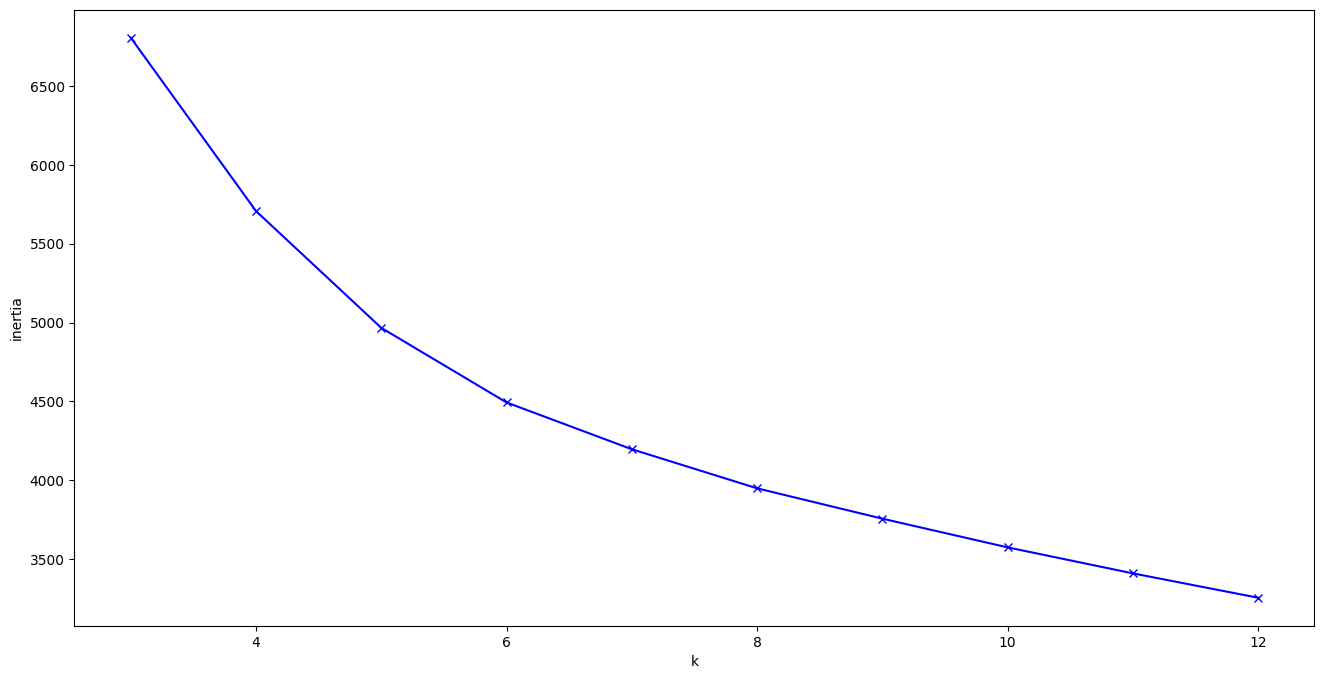

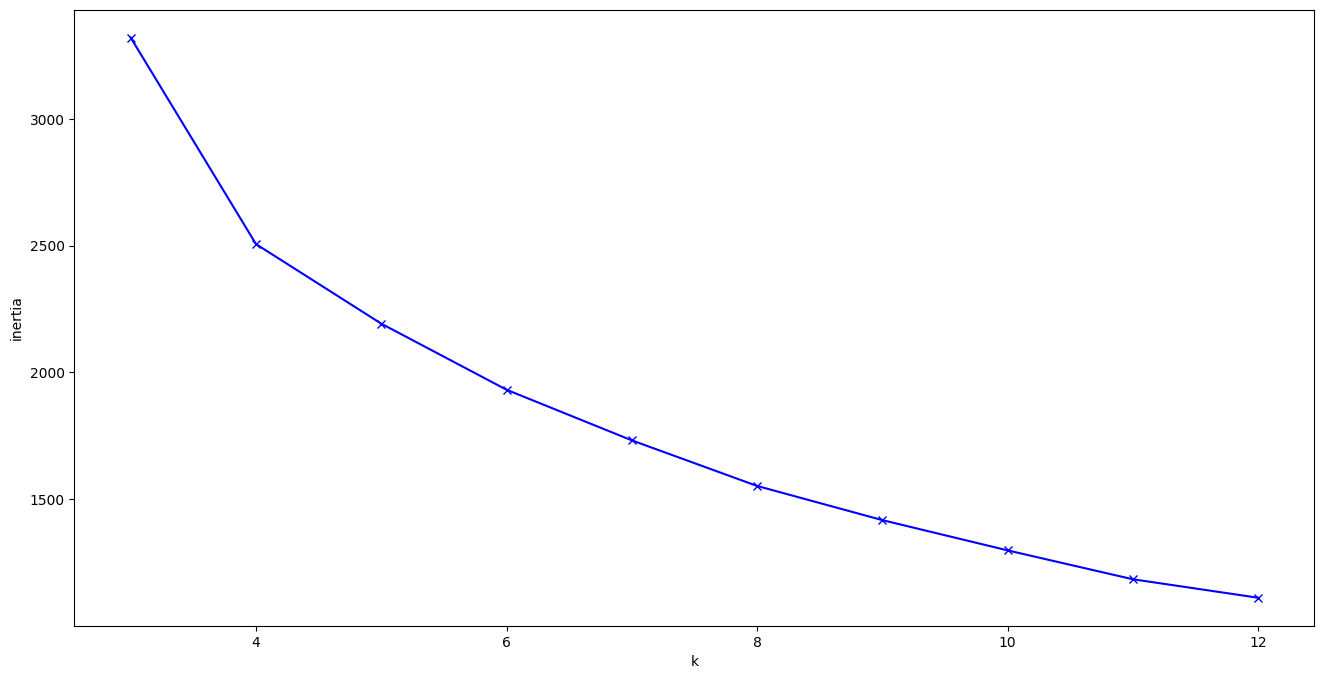

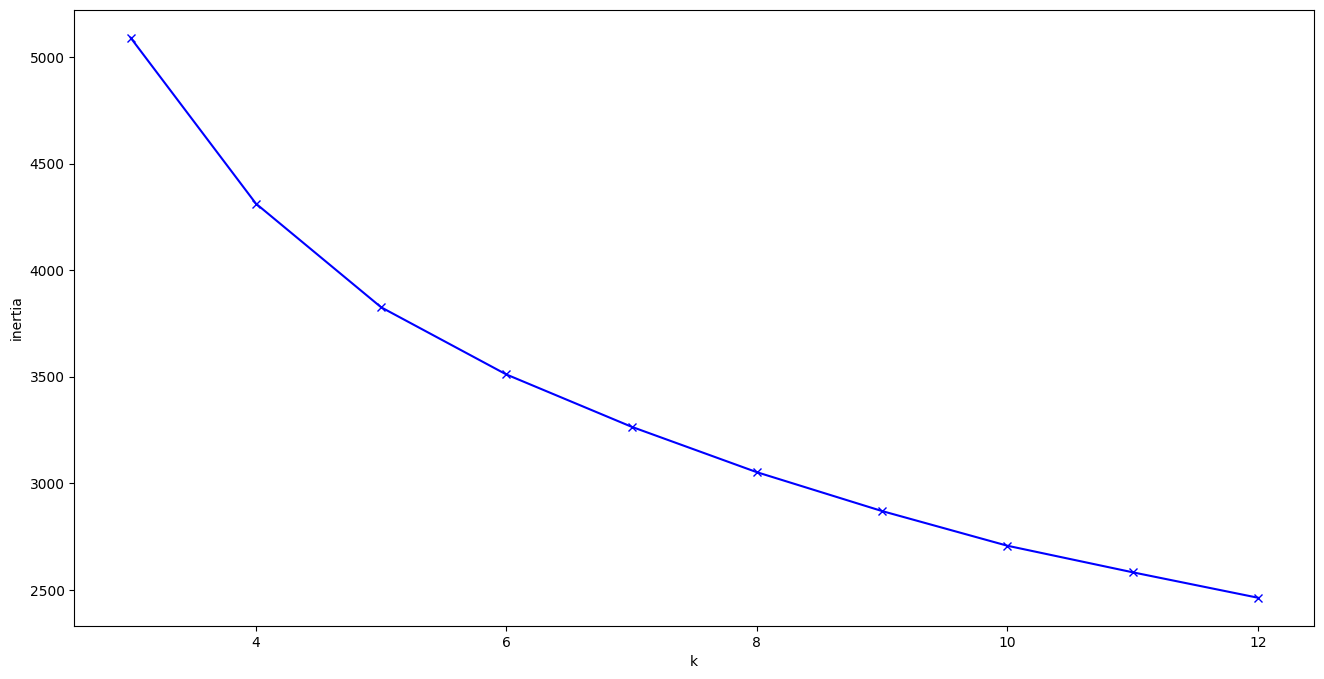

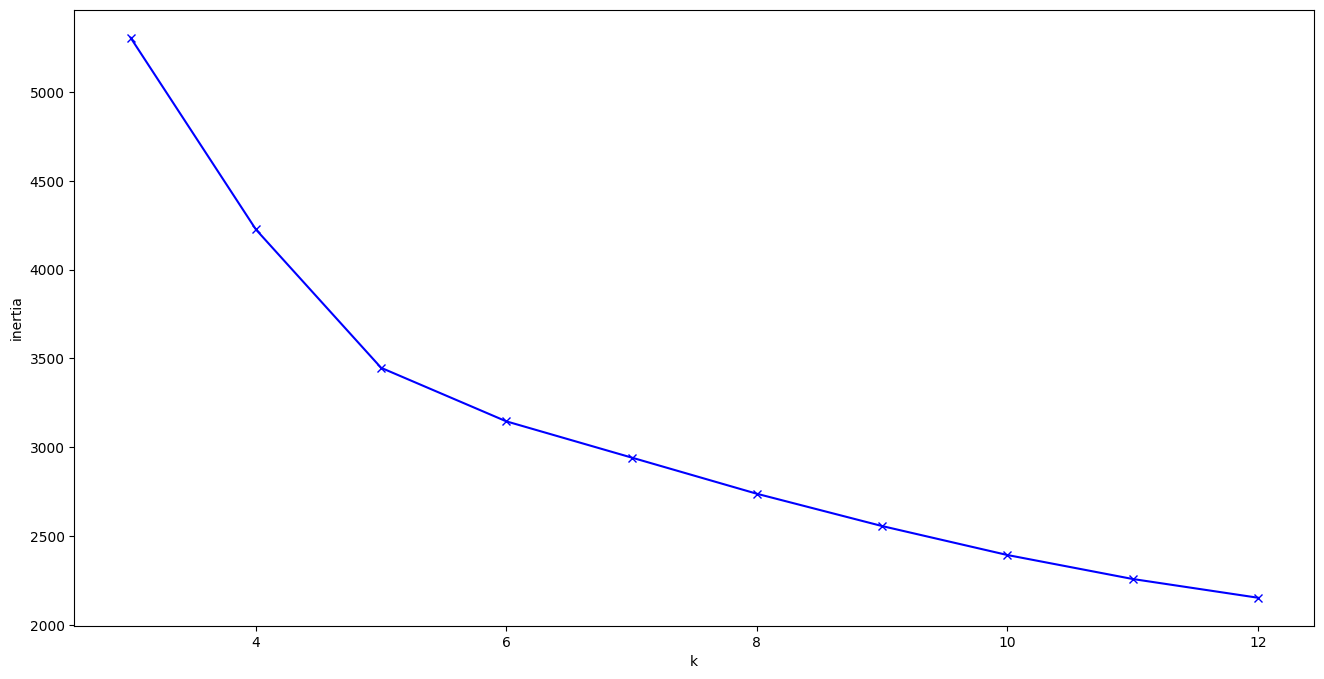

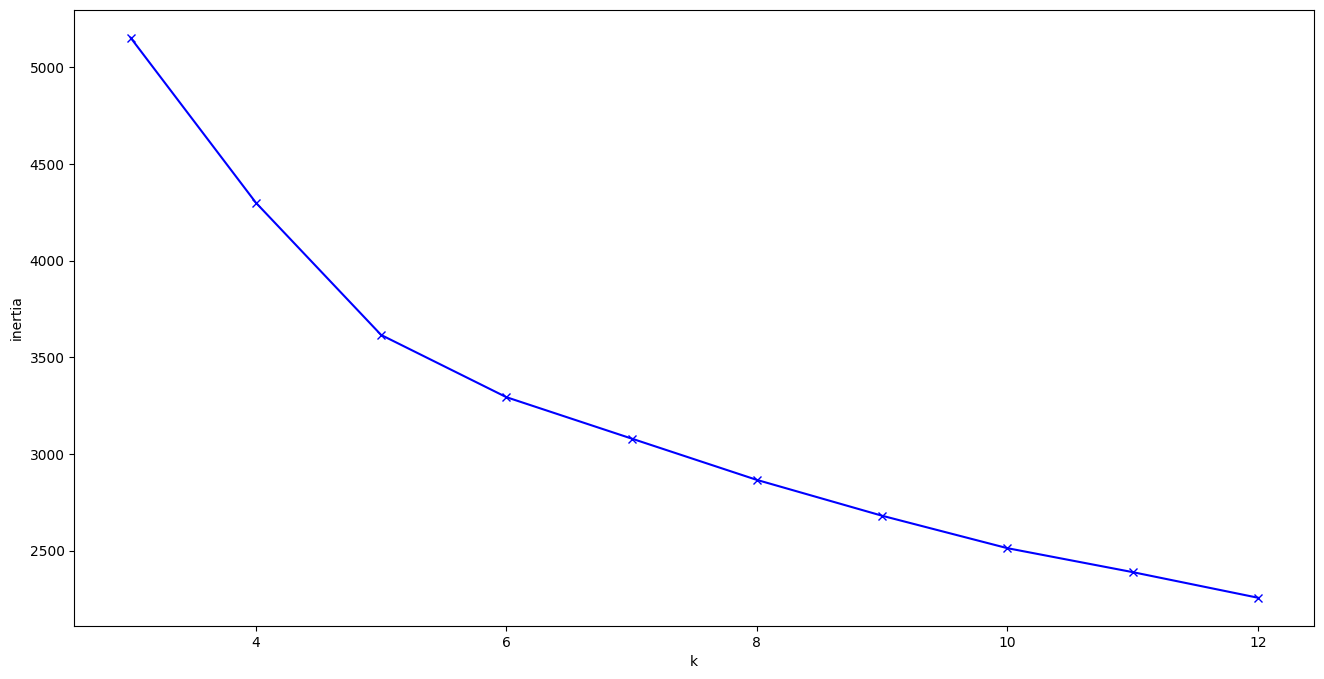

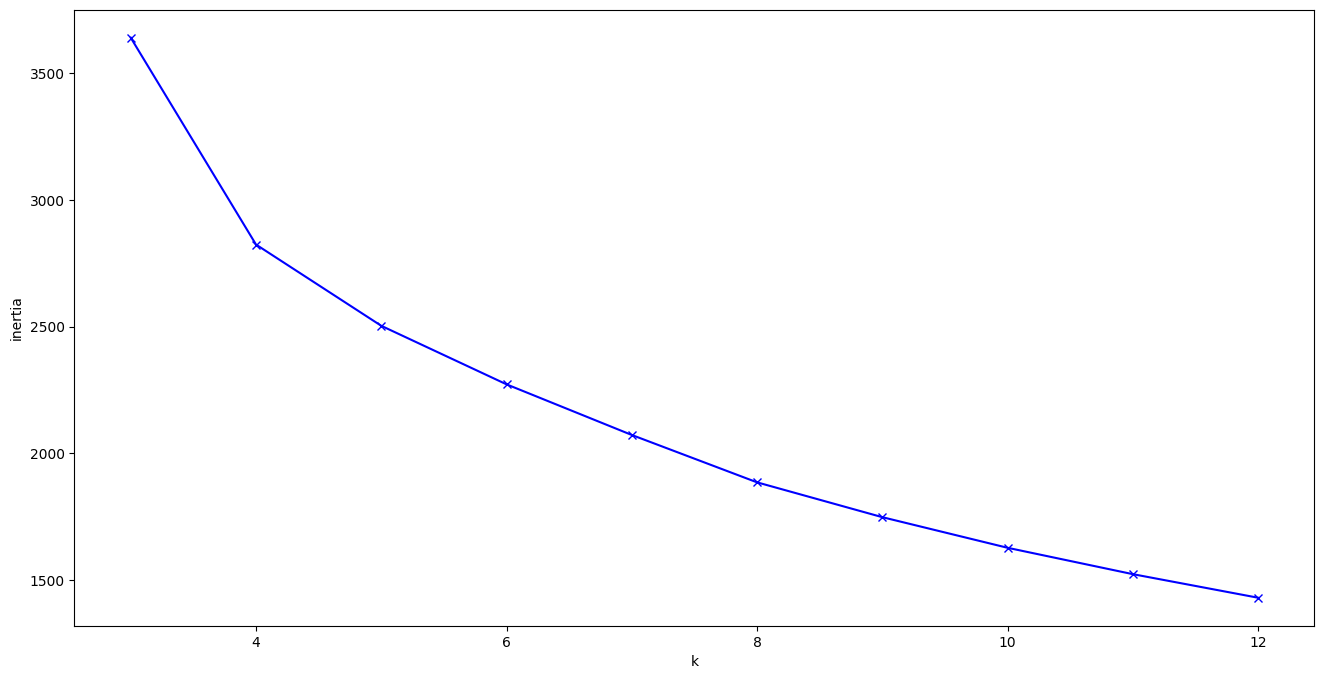

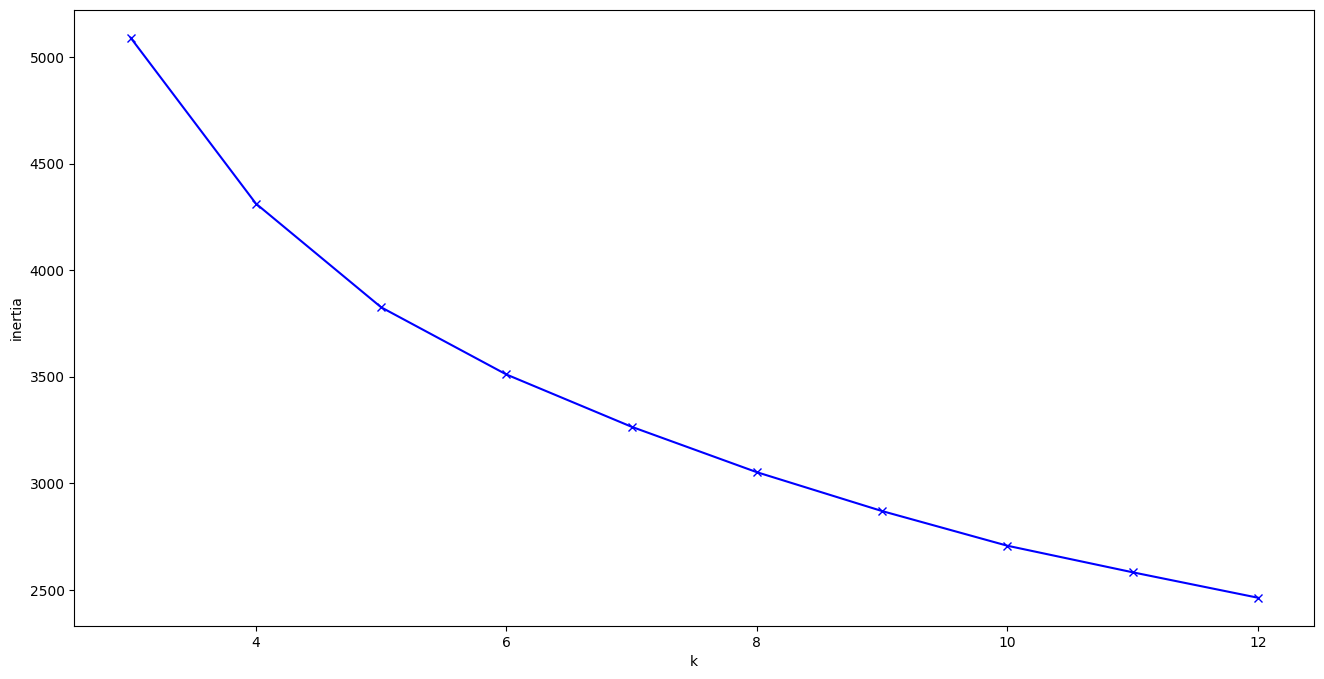

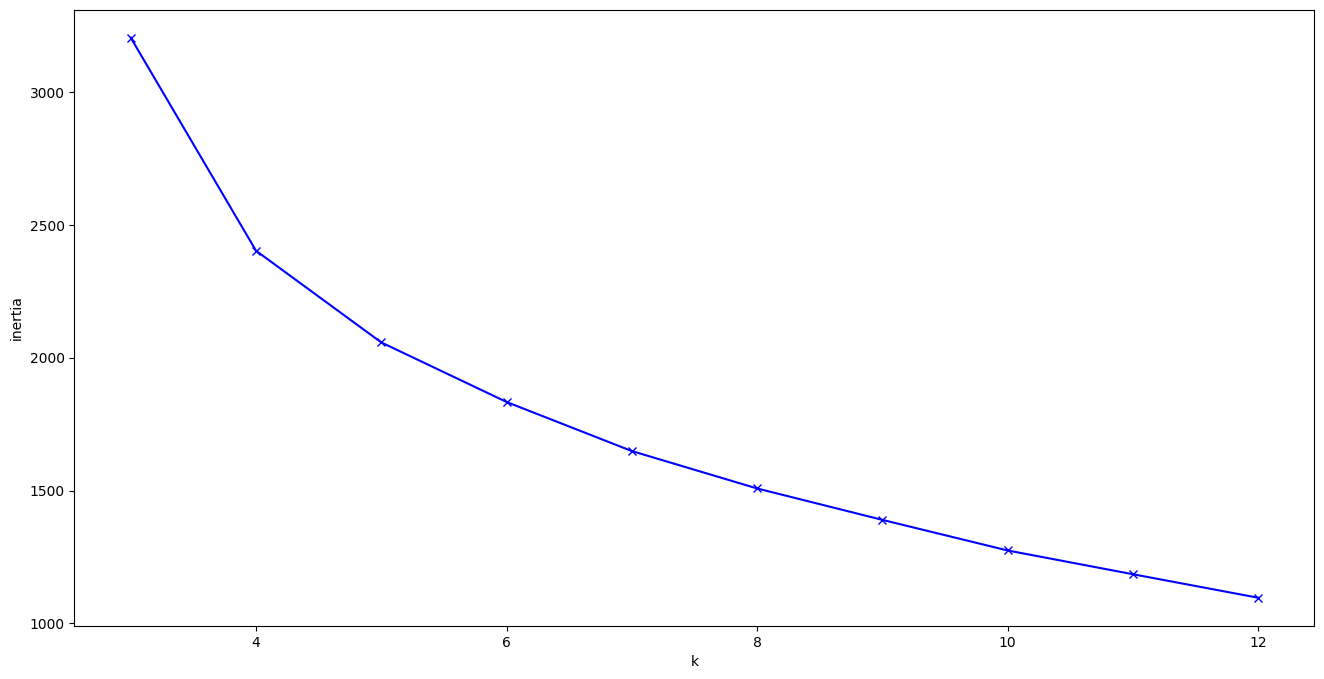

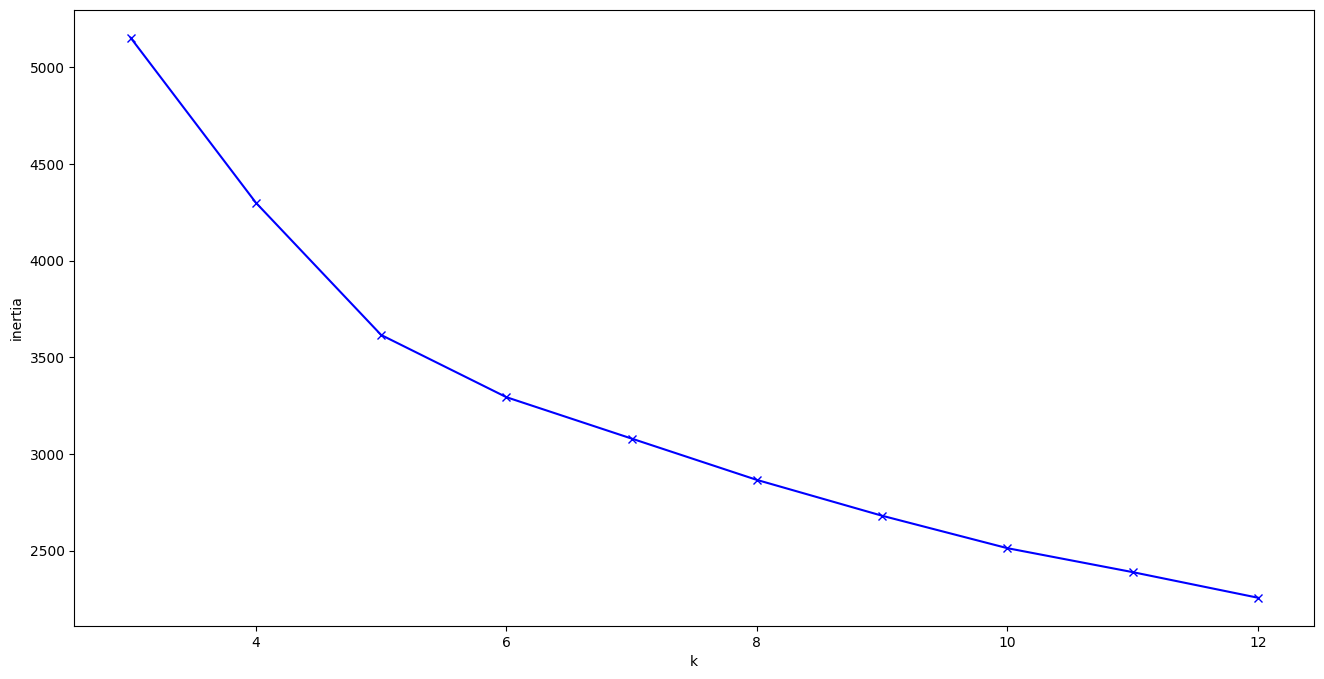

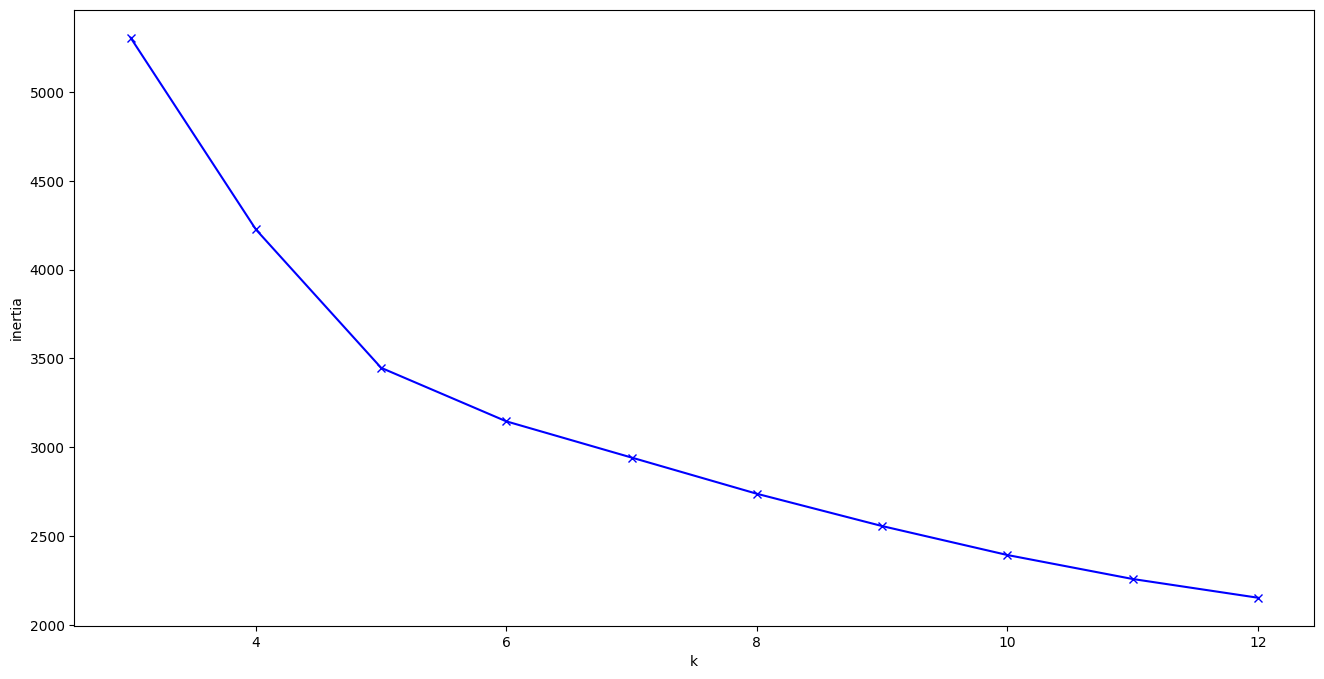

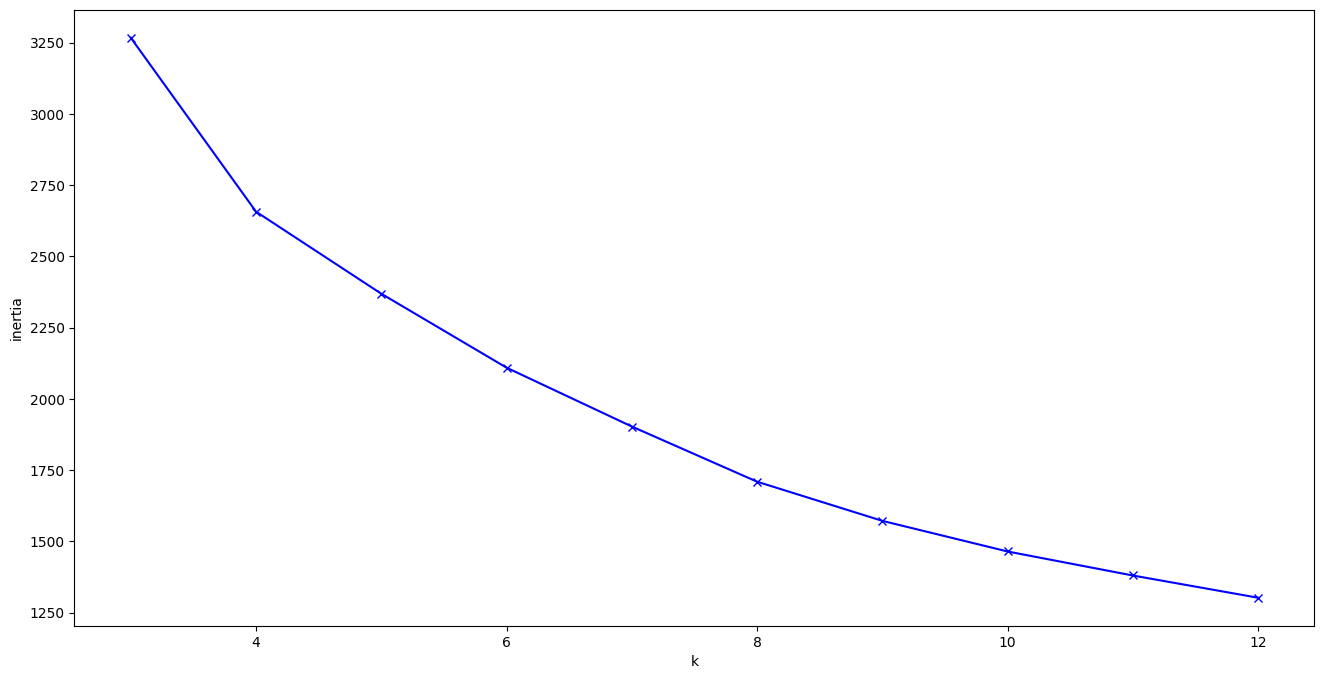

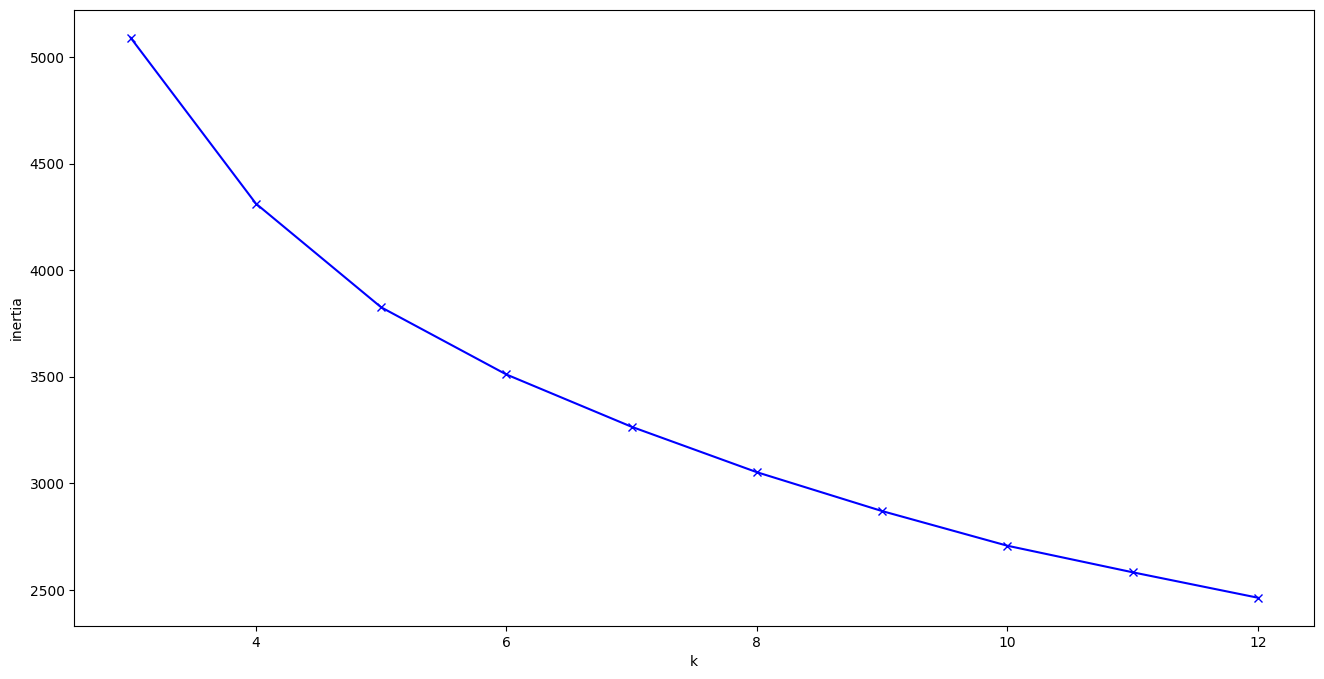

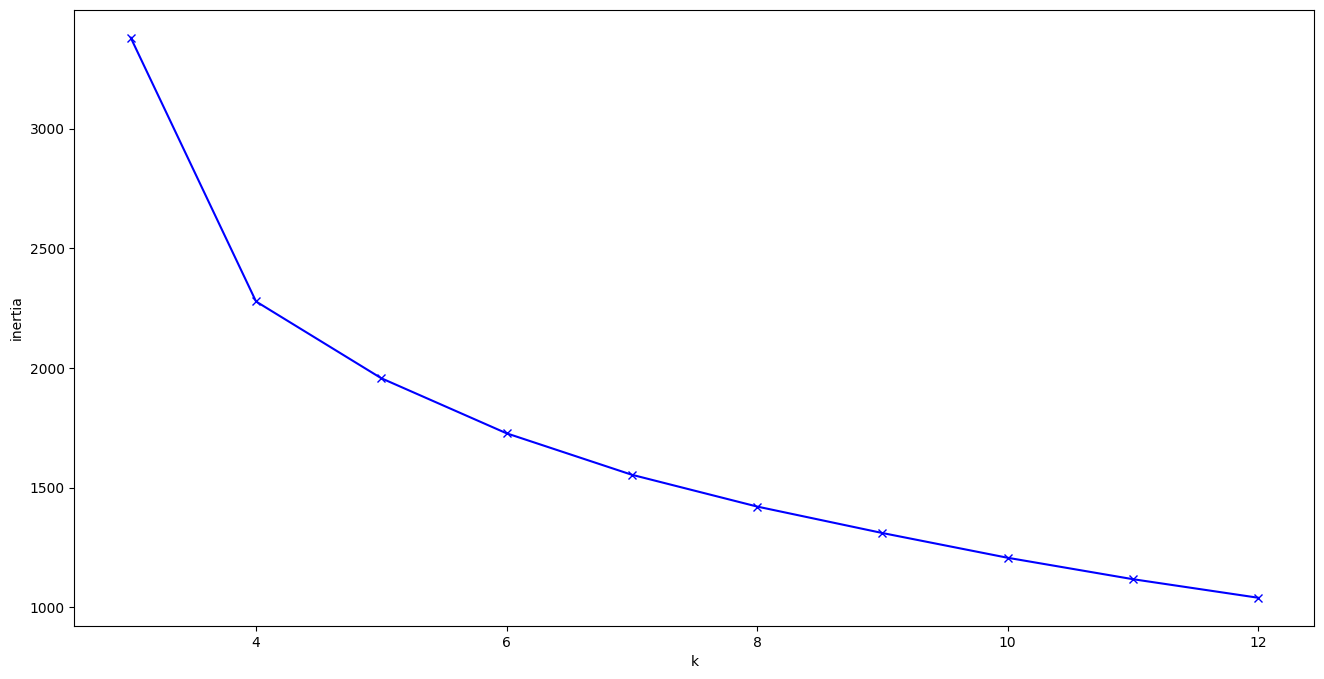

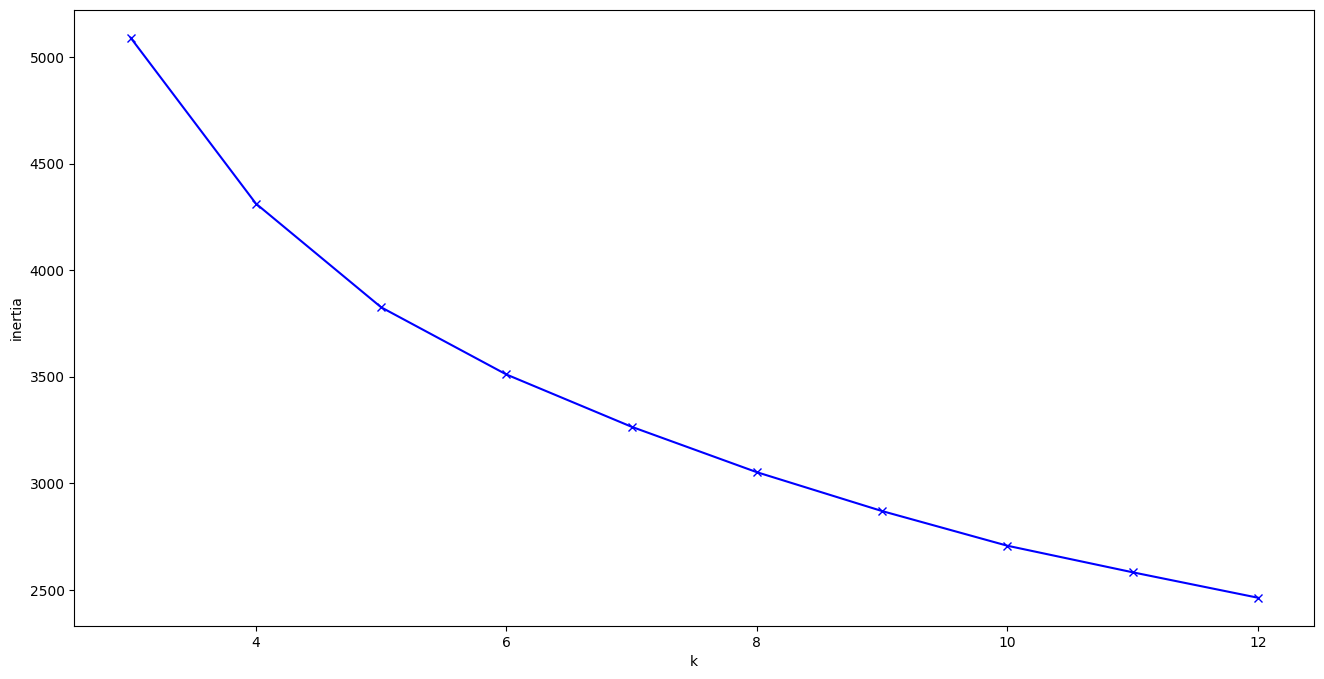

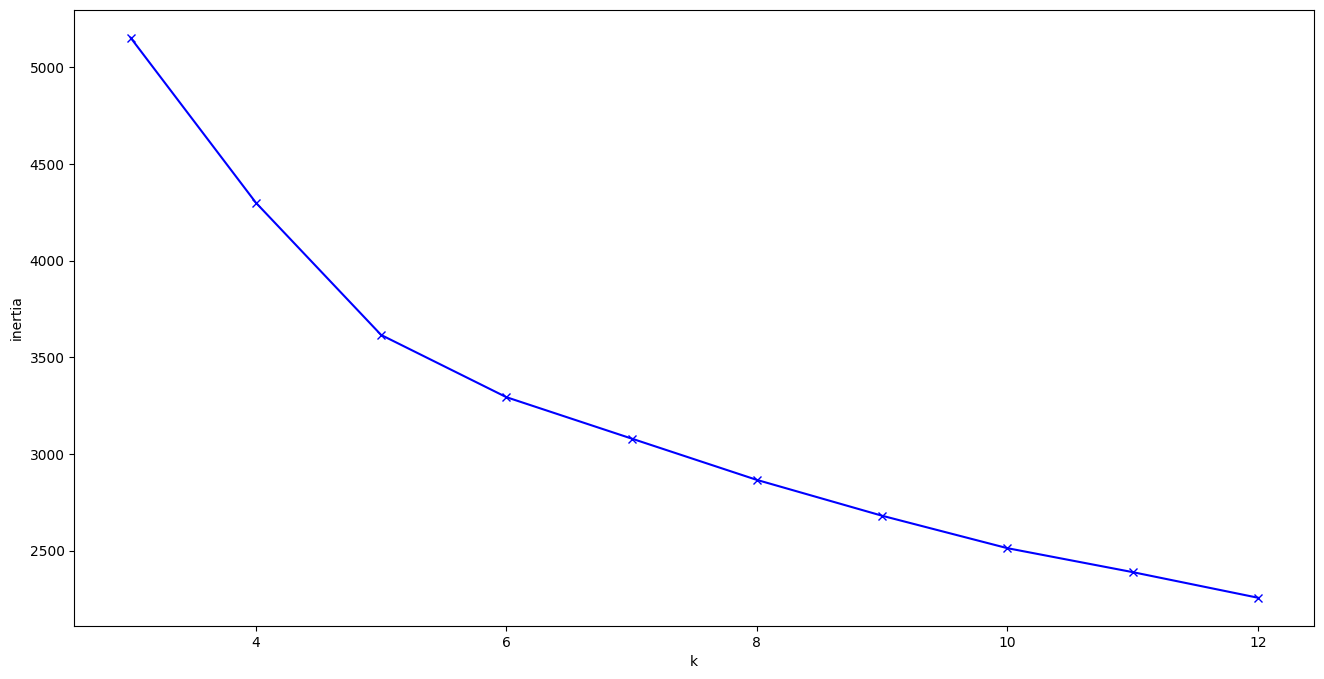

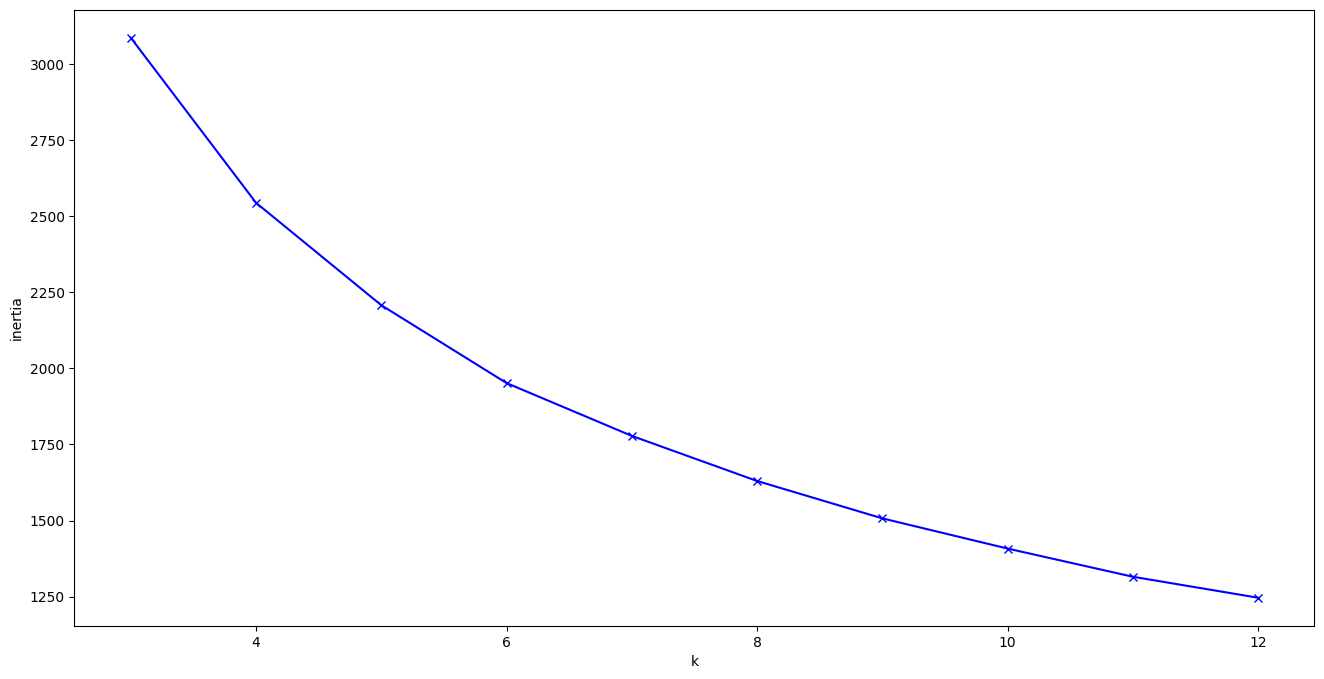

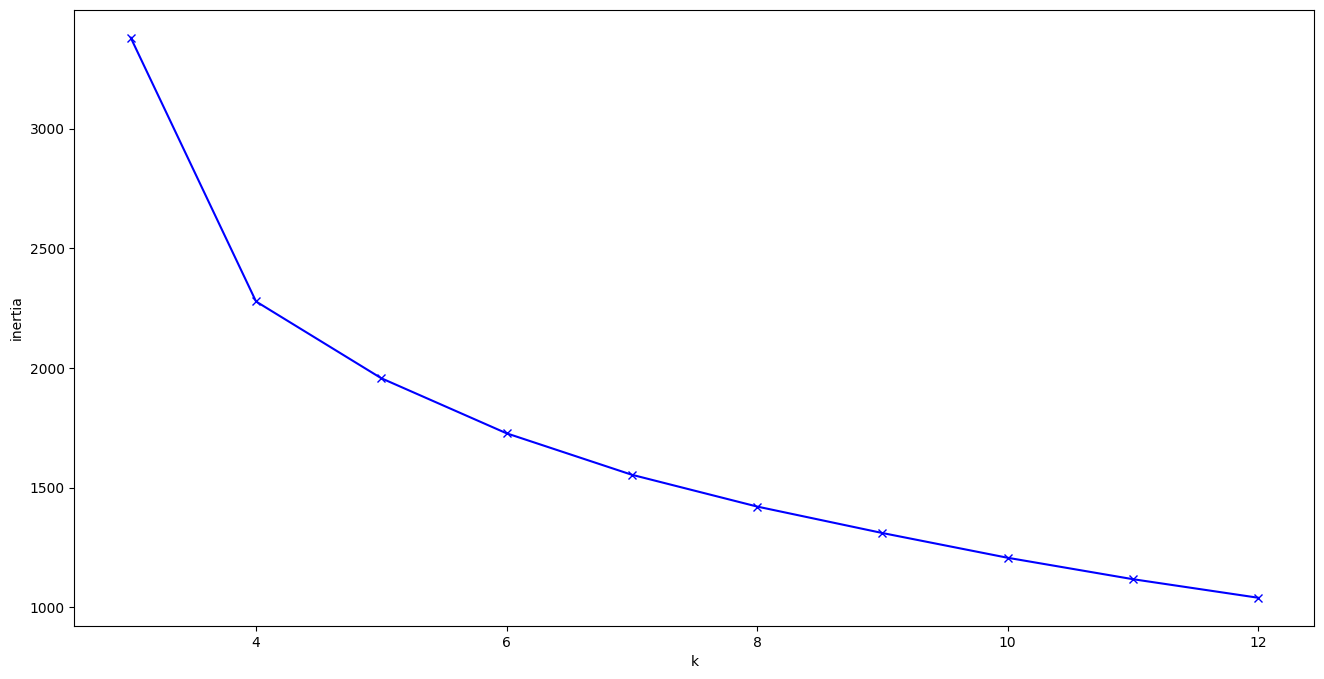

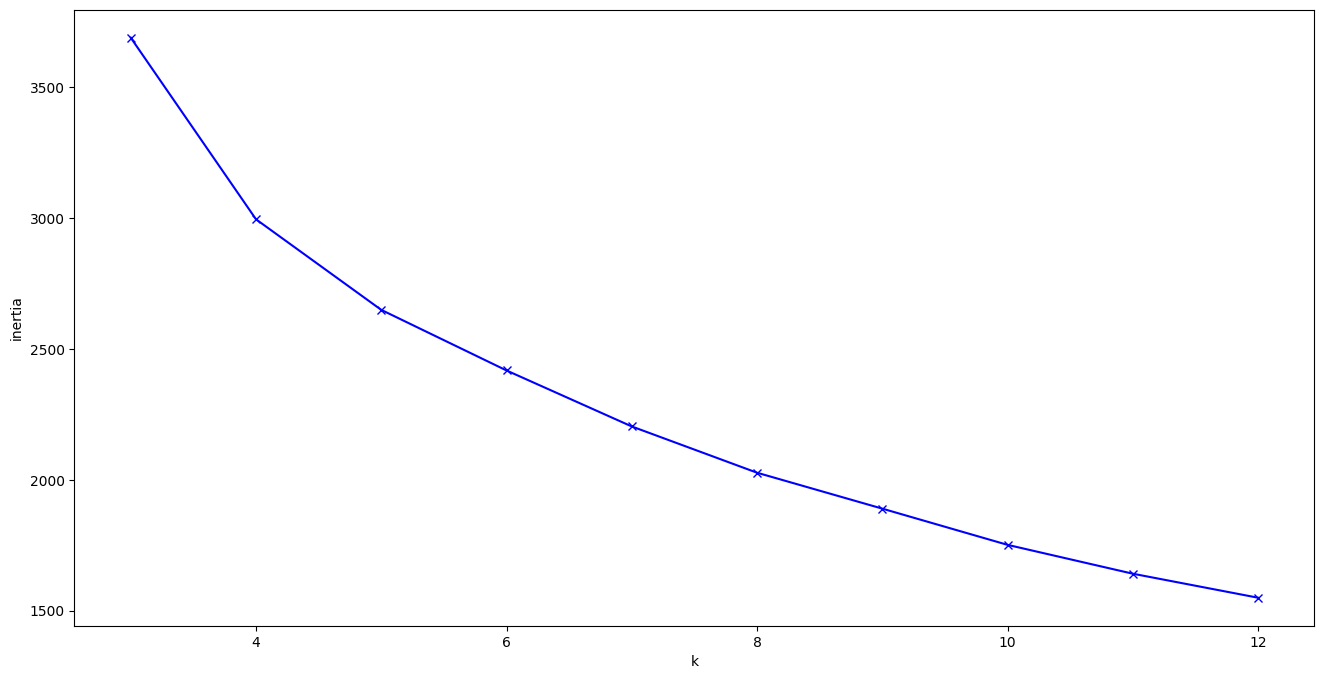

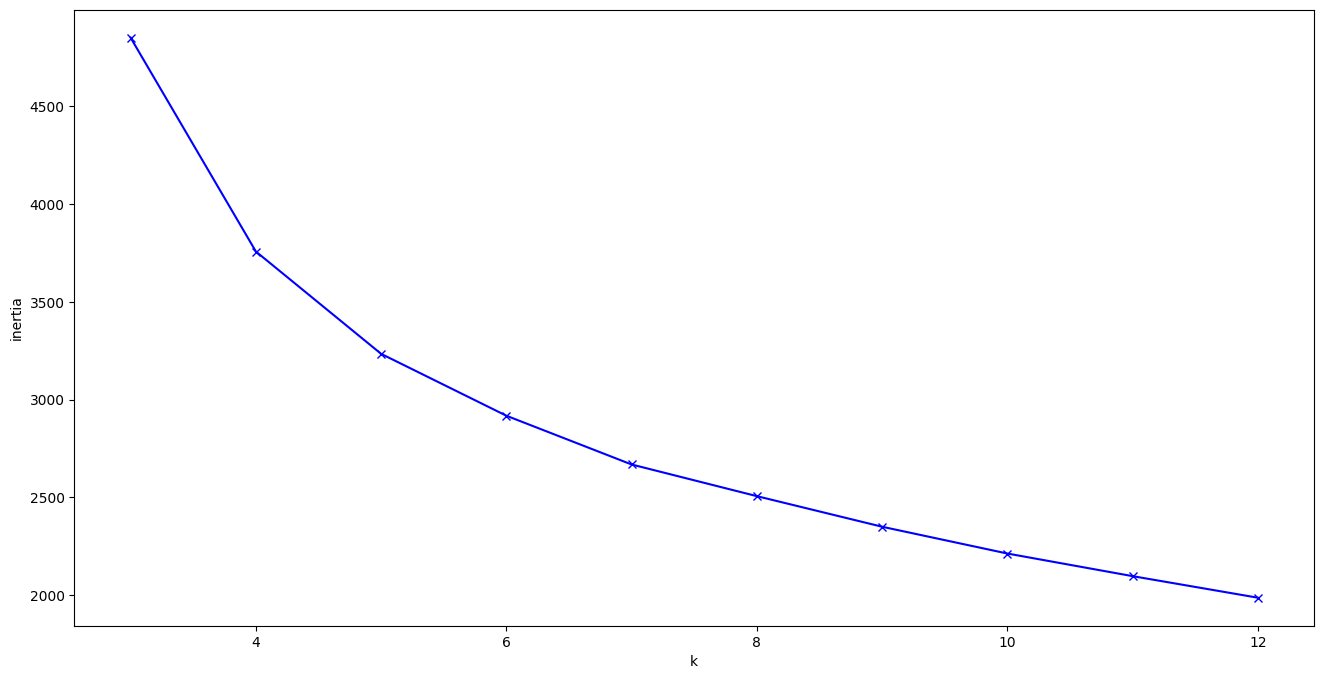

In [327]:
import time
import random

df_cluster['item'] = df_items['item']
df_cluster.set_index('item', inplace=True)

if 'cluster' in df_cluster.columns:
  df_cluster.drop(columns='cluster', inplace=True)

features_clusters = df_cluster.columns

forbidden_features = ['total_supply', 'price_mean', 'sale_mean']

features_clusters = list(set(features_clusters) - set(forbidden_features))

df_cluster_filtred = df_cluster[df_cluster['total_supply'] > 2000]

pipe_line = Pipeline([('scaler', StandardScaler())])

df_cluster_scaled_filtred = pipe_line.fit_transform(df_cluster_filtred)

n_tries = 19
set_k = range(3, 13)
dict_clustering = {}
dict_try = {}
n_inizializations = 50
full_experiment = 0


for i_try in range(n_tries):
  n_features = random.randint(3, len(features_clusters) - full_experiment)
  if (n_features == len(features_clusters) and (full_experiment == 0)) :
    full_experiment = 1
  selected_features = random.sample(list(features_clusters), n_features)
  df_cluster_reduced_filtred = df_cluster_scaled_filtred[selected_features]
  dict_clustering = {}
  inertia = 0
  for k in set_k:
    for i in range(n_inizializations):
      kmeans = KMeans(n_clusters=k, random_state=i).fit(df_cluster_reduced_filtred)
      if (i == 0 or kmeans.inertia_ < inertia):
#        print(f'best try {i}')
        inertia = kmeans.inertia_
        best_kmeans = kmeans
        dict_clustering[k] = [kmeans.inertia_, n_features, i, selected_features]

  #    dict_clustering[k] = [kmeans.inertia_, kmeans.score(df_cluster_scaled), kmeans.cluster_centers_, selected_features]
  #    dict_try[i_try] = [k, kmeans.inertia_, kmeans.score(df_cluster_scaled), kmeans.cluster_centers_, selected_features]

  dict_try[i_try] = dict_clustering

  fig = plt.figure(figsize= (16,8))
  plt.plot(set_k, [dict_clustering[k][0] for k in set_k], 'bx-')
  plt.xlabel('k')
  plt.ylabel('inertia')
  print(f'Iteracion {i_try + 1}, cantidad de features: {n_features}, features: {selected_features}')


In [329]:
df_tries = pd.DataFrame(dict_try)
df_tries.transpose()

3   \
0   [6804.715613584081, 5, 47, [price_relative_std...   
1   [3319.3842238591938, 3, 38, [Sociability, pric...   
2   [5090.4487737719255, 4, 8, [sale_relative_std,...   
3   [5305.114259136818, 4, 20, [Regionality, Socia...   
4   [5152.420745229626, 4, 1, [sale_relative_std, ...   
5   [3639.2646783193895, 3, 33, [price_relative_st...   
6   [5090.4487737719255, 4, 8, [Regionality, price...   
7   [3203.7853609515764, 3, 0, [Sociability, sale_...   
8   [5152.420745229626, 4, 1, [price_relative_std,...   
9   [5305.114259136818, 4, 20, [Seasonality, price...   
10  [3267.2642095183883, 3, 45, [price_relative_st...   
11  [5090.4487737719255, 4, 8, [sale_relative_std,...   
12  [3379.5402986144363, 3, 5, [Regionality, Seaso...   
13  [5090.448773771925, 4, 8, [Regionality, Season...   
14  [5152.420745229626, 4, 1, [Sociability, sale_r...   
15  [3086.3764667909413, 3, 17, [sale_relative_std...   
16  [3379.5402986144363, 3, 5, [Seasonality, Regio...   
17  [3689.136687072183, 3, 0, [sale_relative_std, ...   
18  [4851.051631974664, 4, 41, [Regionality, Seaso...   

                                                   4   \
0   [5706.2942888268935, 5, 9, [price_relative_std...   
1   [2505.941847041612, 3, 4, [Sociability, price_...   
2   [4312.236934315121, 4, 32, [sale_relative_std,...   
3   [4225.9098950807165, 4, 0, [Regionality, Socia...   
4   [4299.153830808702, 4, 18, [sale_relative_std,...   
5   [2823.637283764661, 3, 19, [price_relative_std...   
6   [4312.236934315122, 4, 32, [Regionality, price...   
7   [2402.3331556851676, 3, 45, [Sociability, sale...   
8   [4299.153830808702, 4, 18, [price_relative_std...   
9   [4225.9098950807165, 4, 0, [Seasonality, price...   
10  [2656.8438088359258, 3, 35, [price_relative_st...   
11  [4312.23693431512, 4, 32, [sale_relative_std, ...   
12  [2277.842913307196, 3, 37, [Regionality, Seaso...   
13  [4312.236934315121, 4, 32, [Regionality, Seaso...   
14  [4299.153830808702, 4, 18, [Sociability, sale_...   
15  [2544.054347771912, 3, 8, [sale_relative_std, ...   
16  [2277.842913307196, 3, 37, [Seasonality, Regio...   
17  [2995.235775013065, 3, 6, [sale_relative_std, ...   
18  [3757.1955658603715, 4, 21, [Regionality, Seas...   

                                                   5   \
0   [4966.524816784428, 5, 45, [price_relative_std...   
1   [2192.5118302427277, 3, 7, [Sociability, price...   
2   [3825.584079988931, 4, 13, [sale_relative_std,...   
3   [3447.1294492777592, 4, 22, [Regionality, Soci...   
4   [3615.1097756995587, 4, 5, [sale_relative_std,...   
5   [2503.2589270865938, 3, 13, [price_relative_st...   
6   [3825.584079988931, 4, 13, [Regionality, price...   
7   [2057.321868332649, 3, 22, [Sociability, sale_...   
8   [3615.1097756995587, 4, 5, [price_relative_std...   
9   [3447.129449277759, 4, 22, [Seasonality, price...   
10  [2368.8911698337433, 3, 9, [price_relative_std...   
11  [3825.58407998893, 4, 13, [sale_relative_std, ...   
12  [1957.1717571446343, 3, 21, [Regionality, Seas...   
13  [3825.58407998893, 4, 13, [Regionality, Season...   
14  [3615.1097756995587, 4, 5, [Sociability, sale_...   
15  [2207.628104308582, 3, 49, [sale_relative_std,...   
16  [1957.1717571446343, 3, 21, [Seasonality, Regi...   
17  [2649.1485136782794, 3, 47, [sale_relative_std...   
18  [3233.580432527667, 4, 45, [Regionality, Seaso...   

                                                   6   \
0   [4493.983542935251, 5, 26, [price_relative_std...   
1   [1932.0371474799456, 3, 49, [Sociability, pric...   
2   [3510.2621560750176, 4, 2, [sale_relative_std,...   
3   [3145.8093945263, 4, 29, [Regionality, Sociabi...   
4   [3293.3696958834216, 4, 2, [sale_relative_std,...   
5   [2272.436474519596, 3, 32, [price_relative_std...   
6   [3510.2621560750176, 4, 2, [Regionality, price...   
7   [1833.319231156392, 3, 29, [Sociability, sale_...   
8   [3293.3696958834216, 4, 2, [price_relative_std...   
9   [3145.8093945263, 4, 29, [Seasonality, price_r...   
1

In [330]:
dict_try[16][6]

[1727.1637743627555, 3, 22, ['Seasonality', 'Regionality', 'Sociability']]

In [345]:
# Examinamos un cluster particular

set_features_selected =    ['Seasonality', 'Regionality', 'Sociability']

k_selected = 6
seed = 22

print(set_features_selected)


df_cluster_filtered = df_cluster[df_cluster['total_supply'] > 2000]

pipe_line = Pipeline([('scaler', StandardScaler())])

df_cluster_scaled_filtered = pipe_line.fit_transform(df_cluster_filtered)


df_cluster_selected_filtered = df_cluster_scaled_filtered[set_features_selected]
kmeans = KMeans(n_clusters=k_selected, random_state=seed).fit(df_cluster_selected_filtered)

df_cluster_filtered['cluster'] = kmeans.labels_
df_cluster_filtered.reset_index(inplace=True)
df_cluster_filtered.groupby('cluster').agg({'item': 'count', 'sale_mean': 'mean', 'sale_relative_std': 'mean', 'price_mean': 'mean', 'price_relative_std': 'mean', 'total_supply': 'mean', 'Regionality': 'mean', 'Seasonality': 'mean', 'Sociability': 'mean' })


['Seasonality', 'Regionality', 'Sociability']


/tmp/ipython-input-4233827231.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_filtered['cluster'] = kmeans.labels_


item  sale_mean  sale_relative_std  price_mean  price_relative_std  \
cluster                                                                       
0         684   8.585822           0.989641    5.828956            0.042542   
1         138  16.955080           1.178023    3.442295            0.068150   
2         112   8.256385           1.525127    5.989782            0.060421   
3         611  10.946818           0.960241    4.983016            0.042386   
4         262  12.167185           1.169629    6.530220            0.048356   
5         268   7.965700           1.226900    5.728569            0.053712   

         total_supply  Regionality  Seasonality  Sociability  
cluster                                                       
0         2609.501462     0.257179     0.055484     0.909357  
1         2679.746377     0.215274     0.114775     9.811594  
2         2624.107143     0.237747     0.339661     1.598214  
3         2566.217676     0.112510     0.066570     0.824877  
4         2601.190840     0.420958     0.083390     1.061069  
5         2601.861940     0.211798     0.165962     1.264925

### Entrenamos KMEANS

Iteracion 1, cantidad de features: 3, features: ['%trend_slope', 'Sociability', 'Regionality']
Iteracion 2, cantidad de features: 4, features: ['sale_relative_std', 'Regionality', 'sale_mean', 'price_elasticity']
Iteracion 3, cantidad de features: 7, features: ['Sociability', 'sale_mean', 'Seasonality', '%trend_slope', 'sale_relative_std', 'price_elasticity', 'Regionality']
Iteracion 4, cantidad de features: 6, features: ['Sociability', '%trend_slope', 'sale_relative_std', 'price_elasticity', 'sale_mean', 'Regionality']
Iteracion 5, cantidad de features: 3, features: ['Regionality', 'price_elasticity', 'sale_mean']
Iteracion 6, cantidad de features: 4, features: ['Seasonality', '%trend_slope', 'price_elasticity', 'sale_mean']
Iteracion 7, cantidad de features: 5, features: ['price_elasticity', 'Seasonality', 'sale_relative_std', 'sale_mean', 'Sociability']
Iteracion 8, cantidad de features: 5, features: ['Sociability', 'Seasonality', 'sale_relative_std', '%trend_slope', 'Regionality']


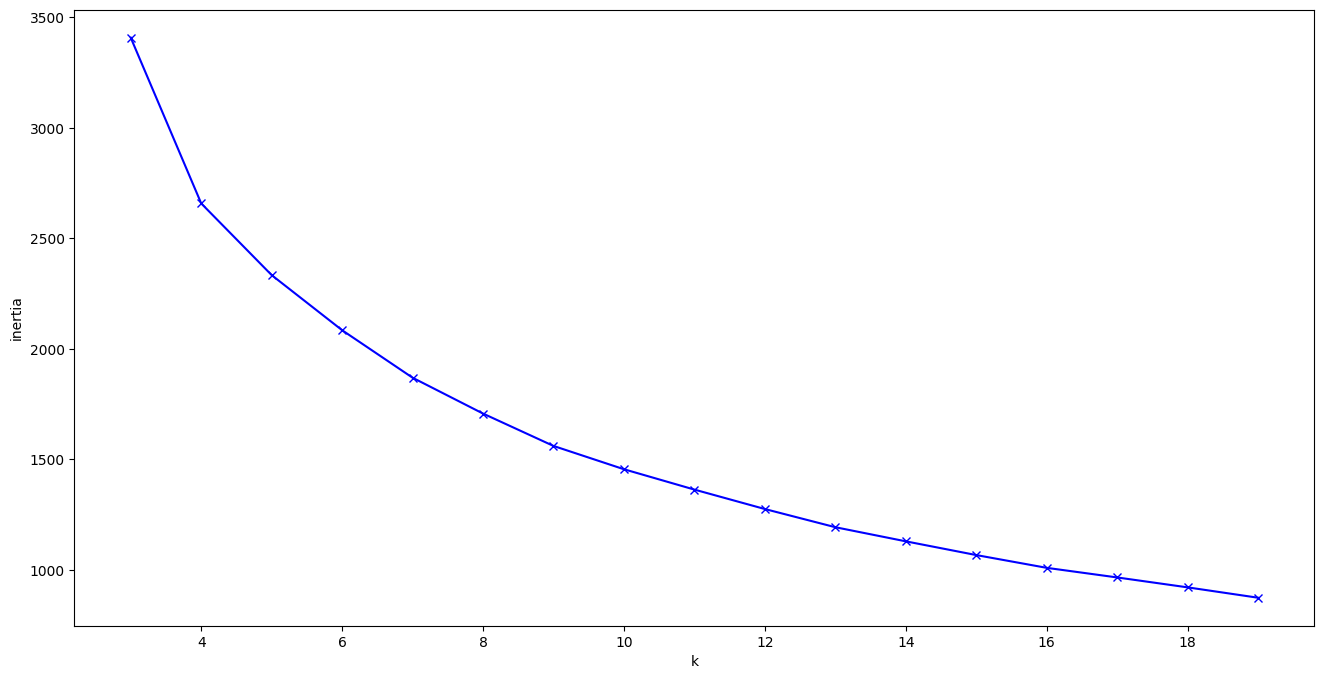

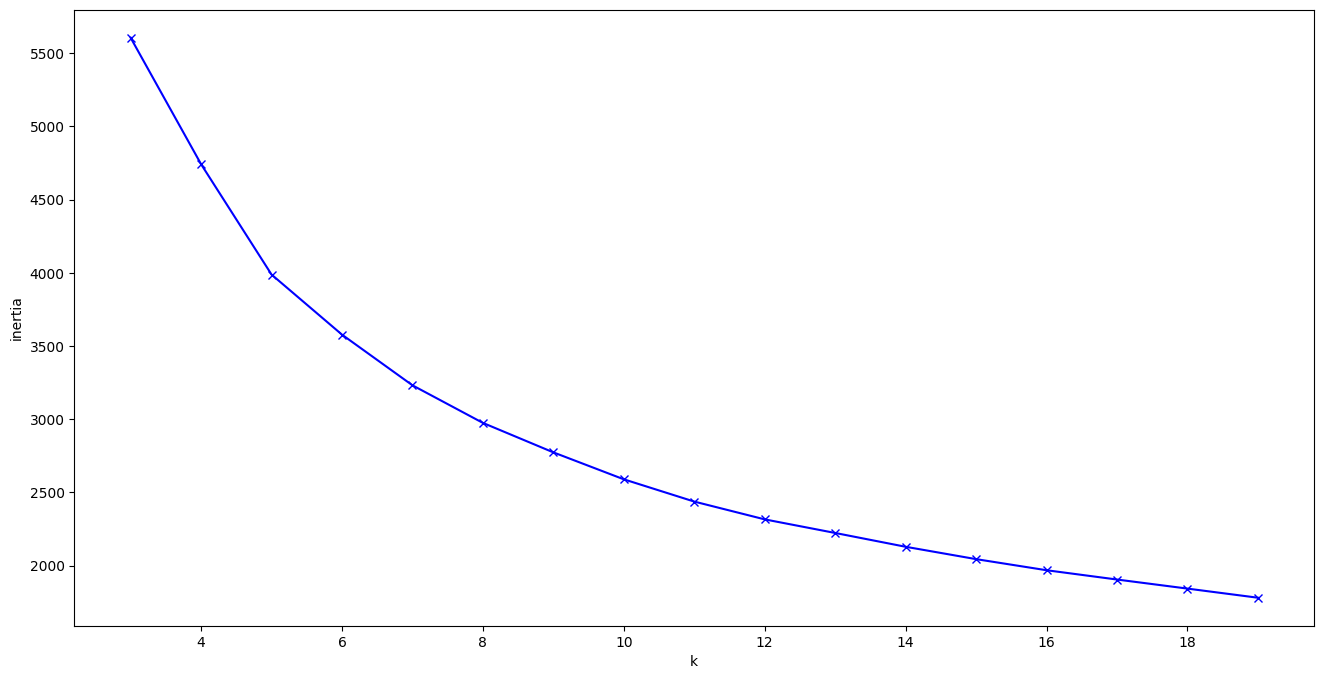

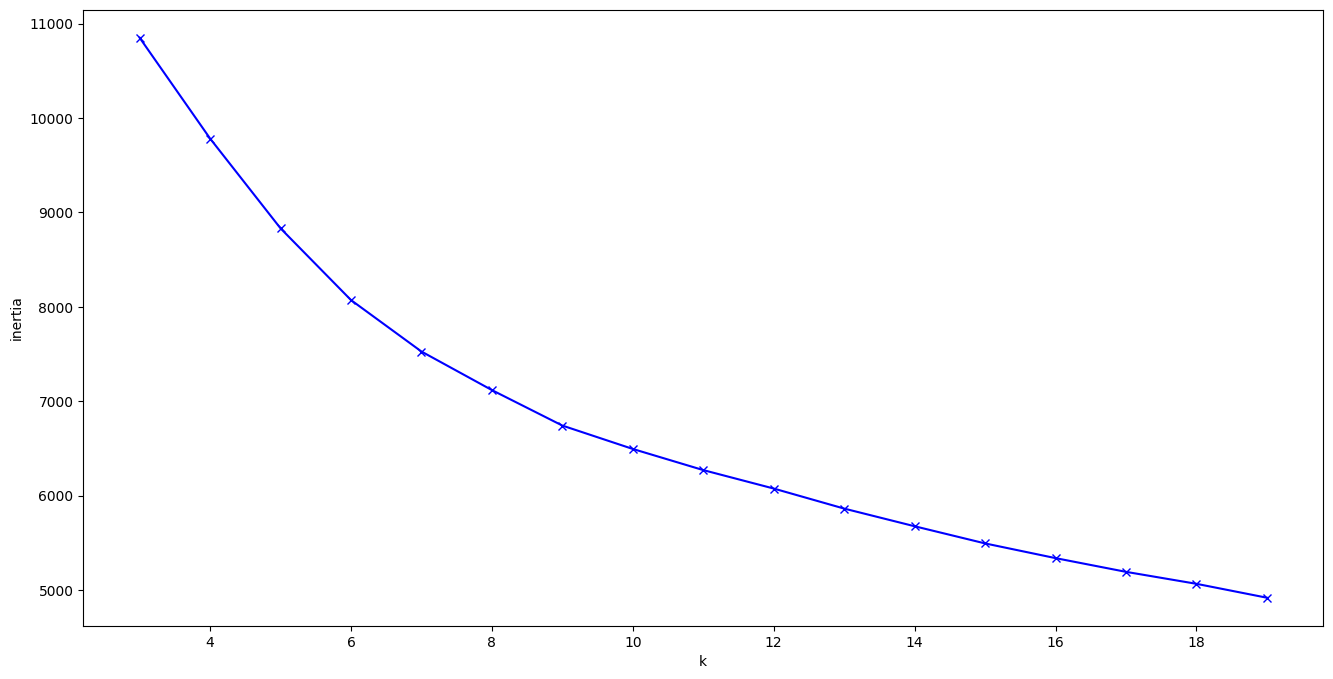

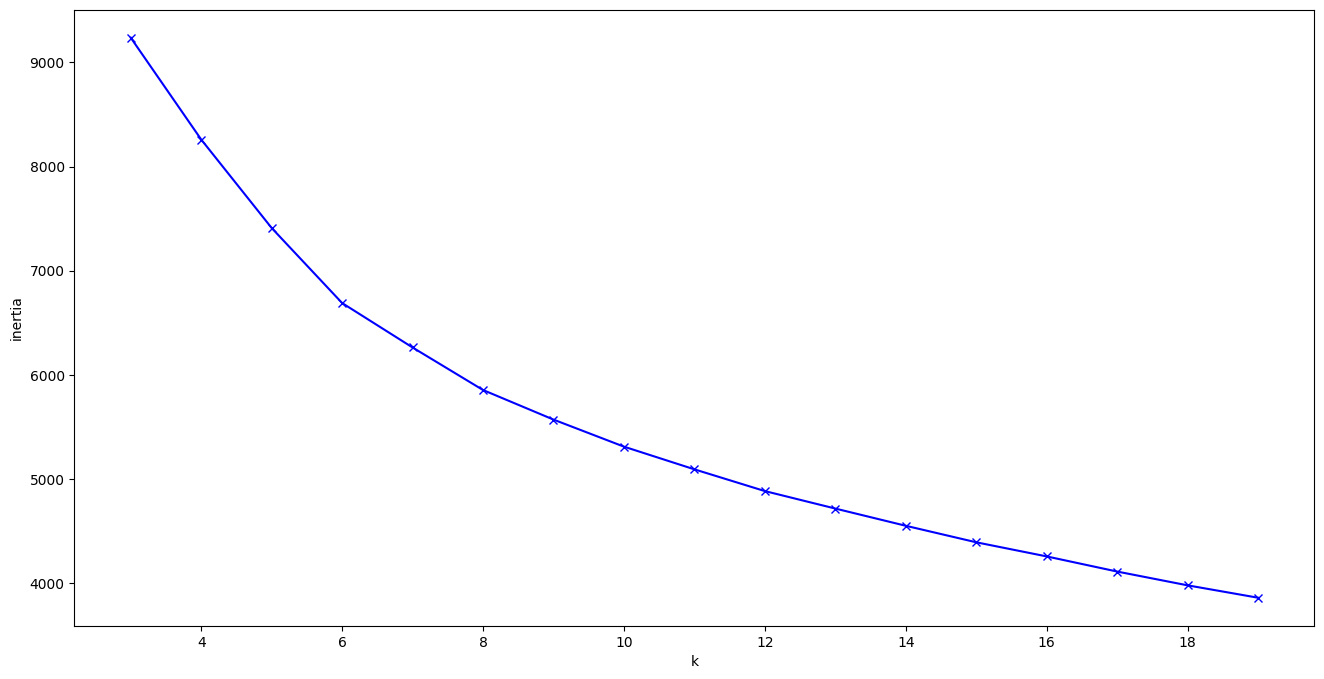

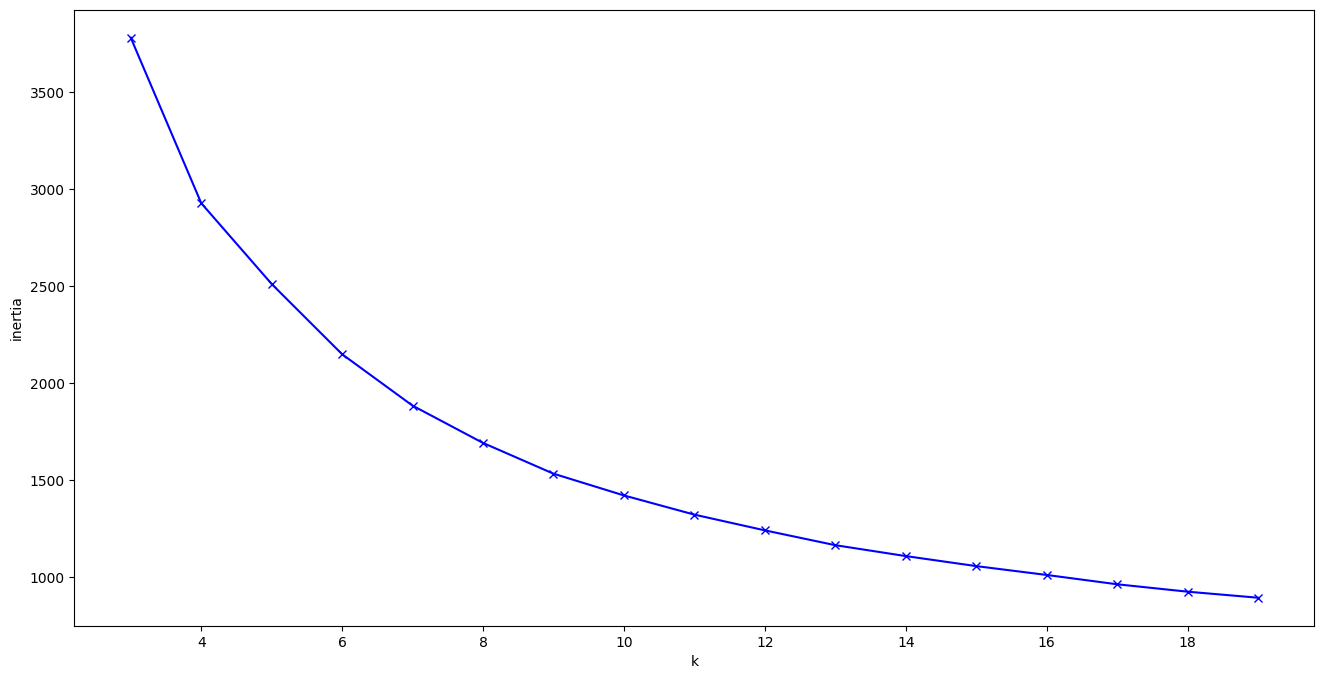

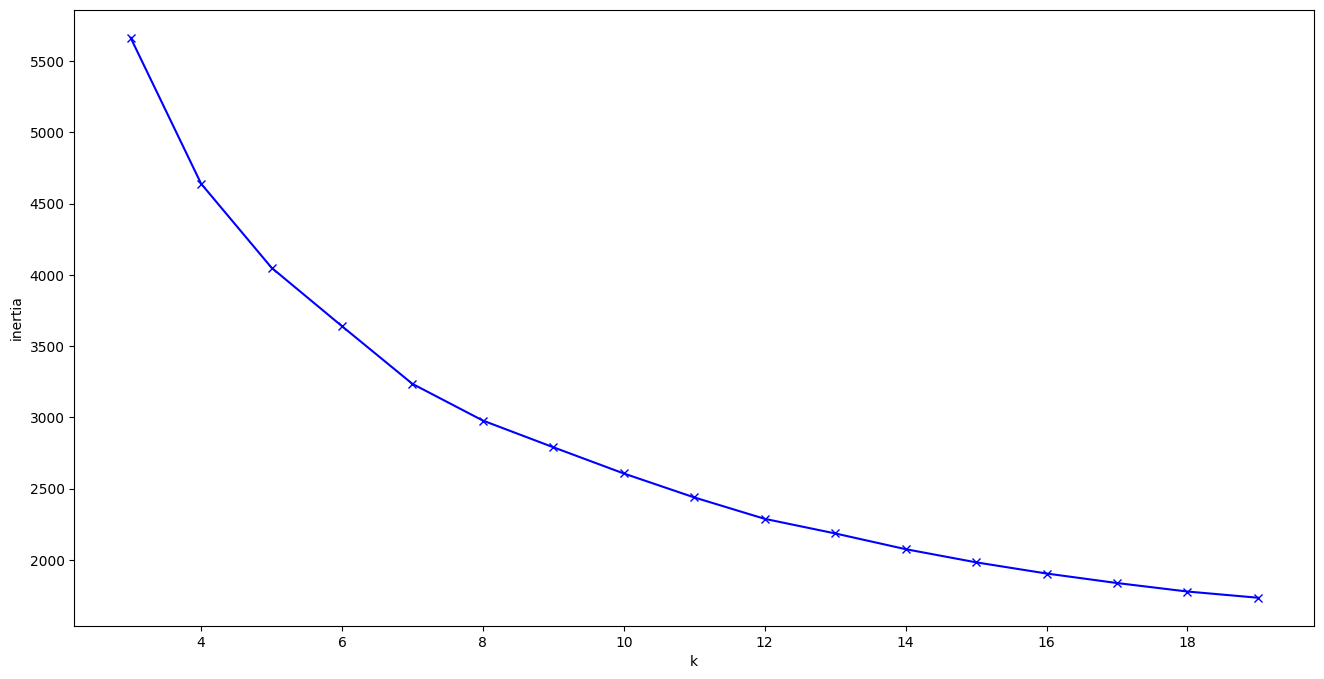

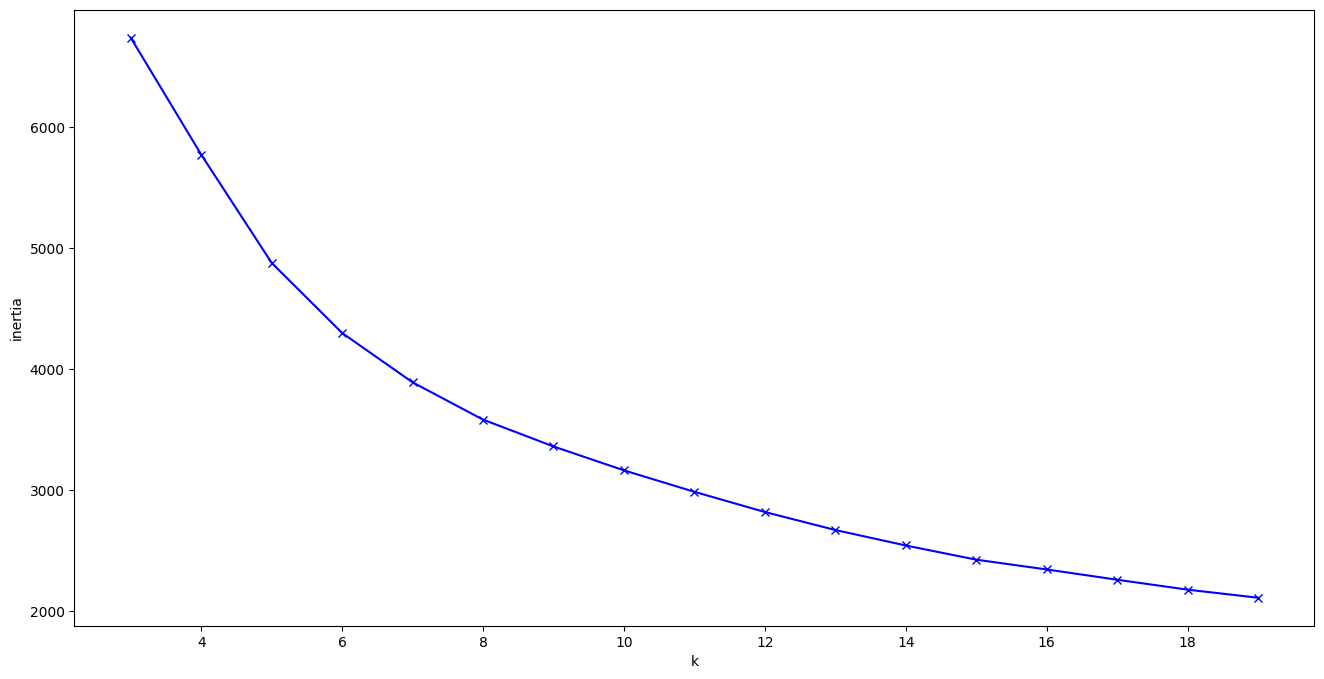

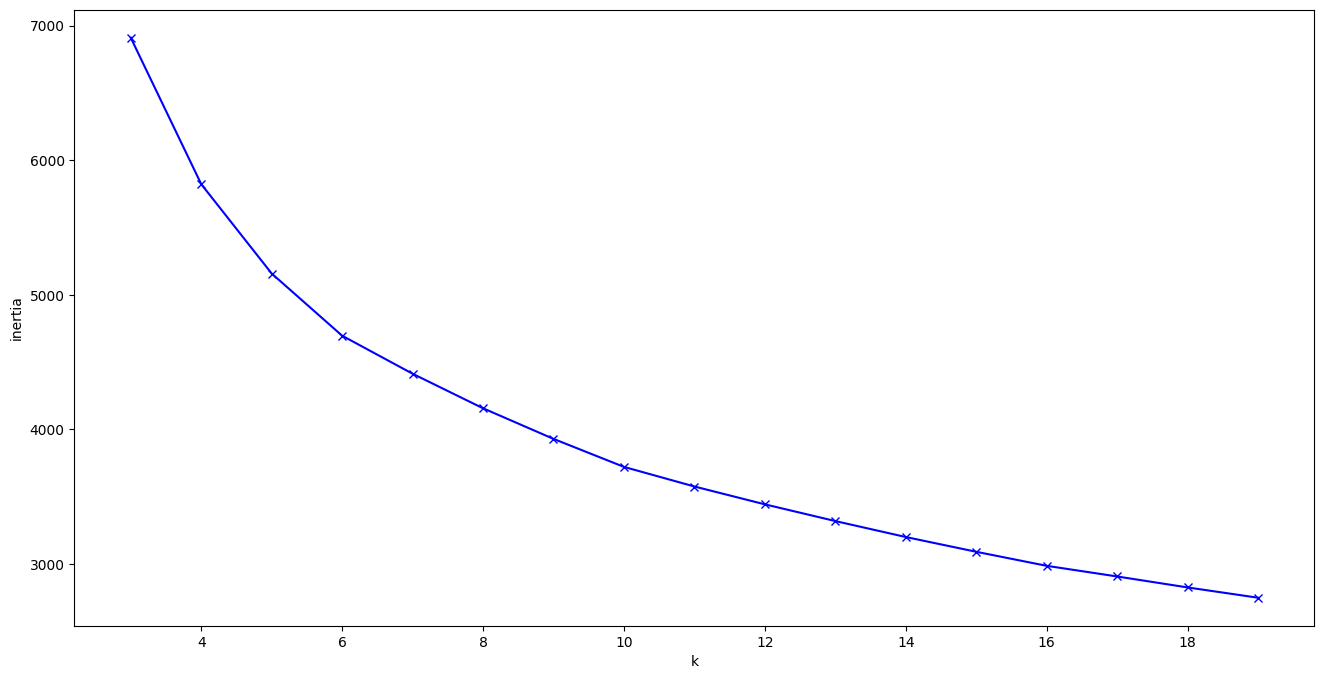

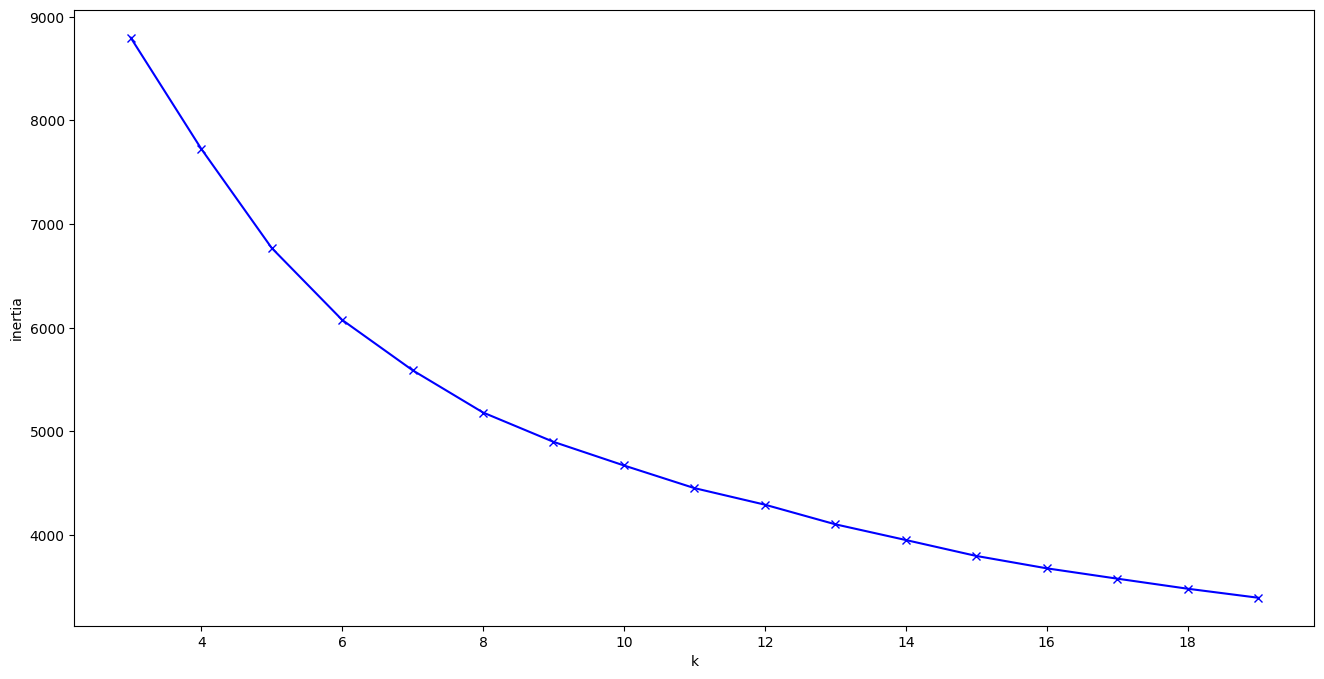

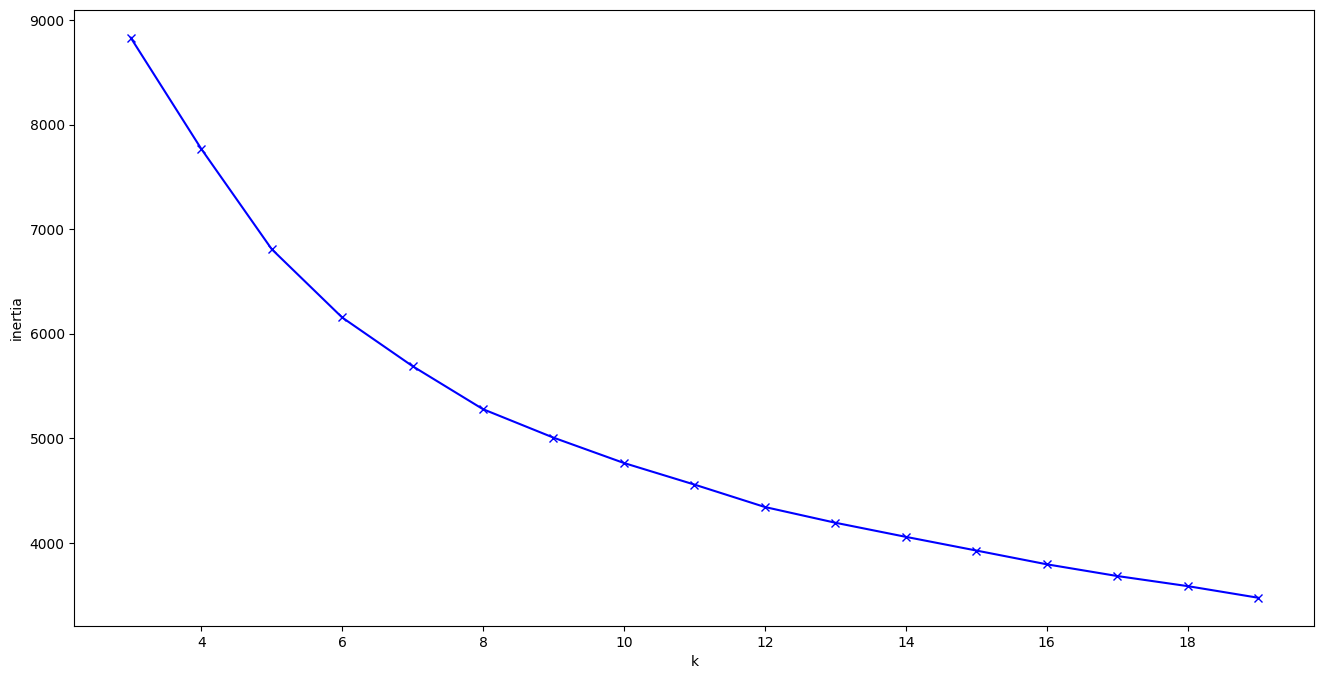

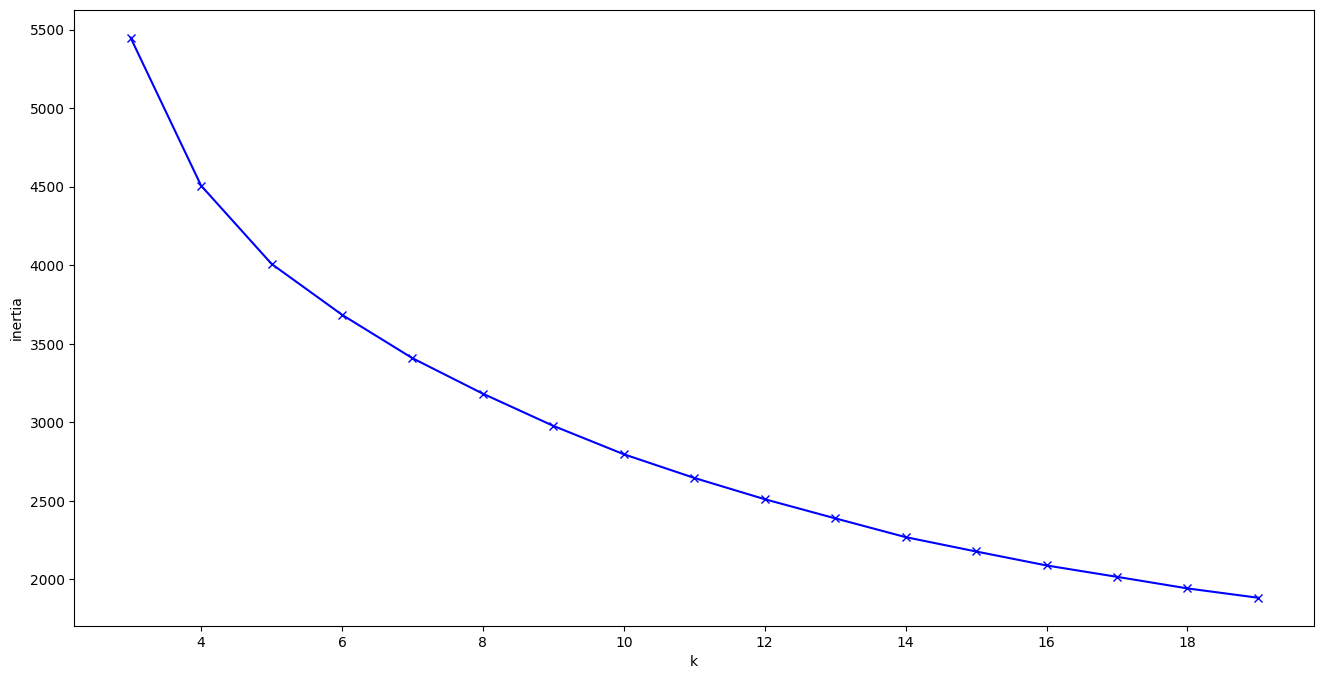

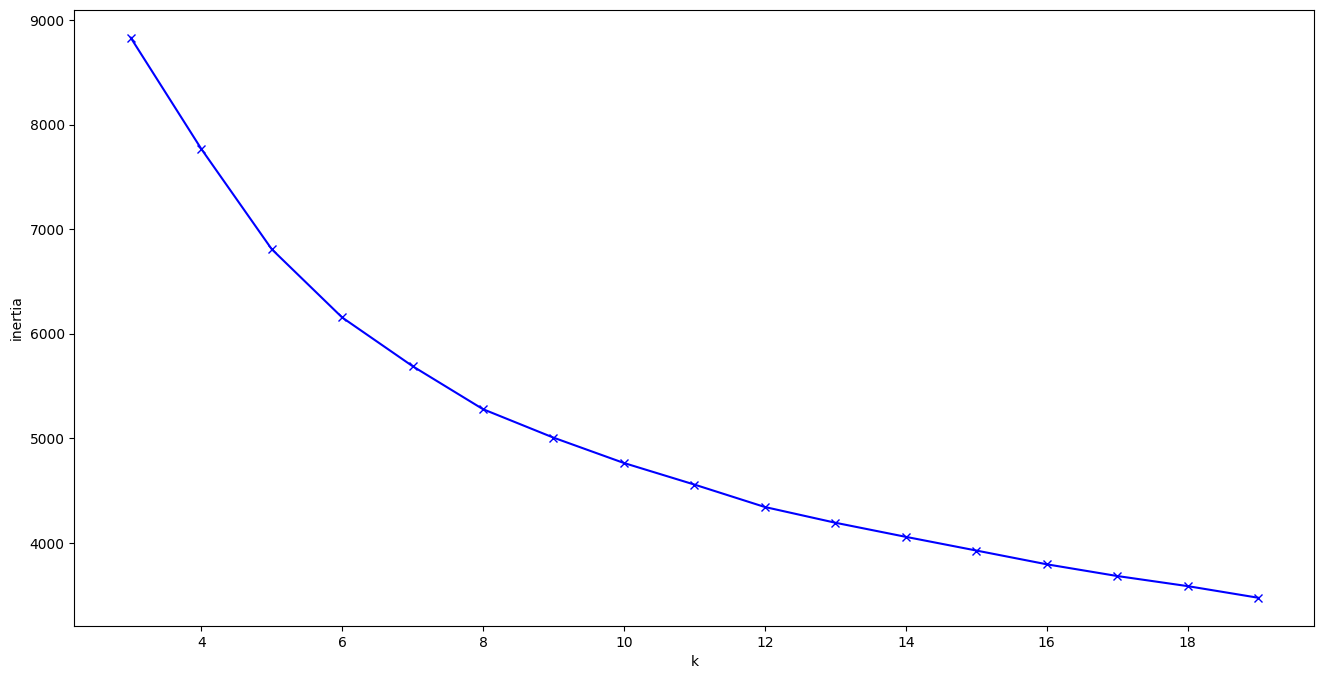

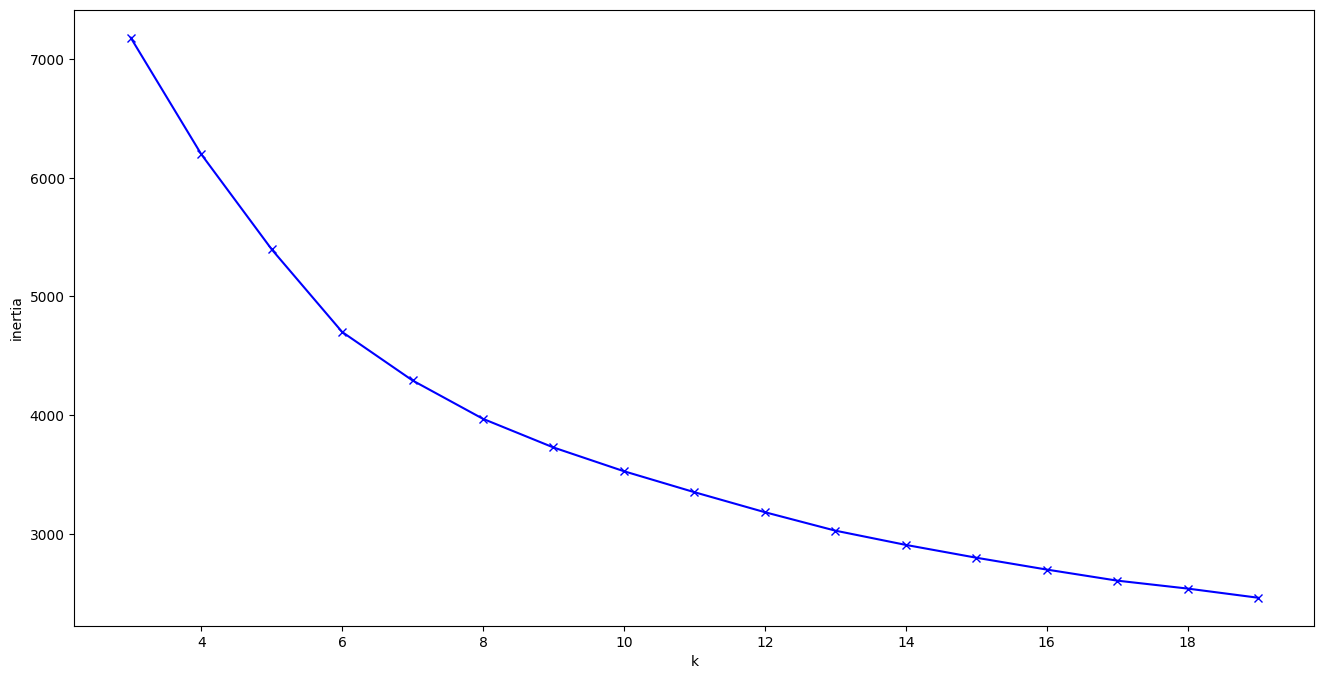

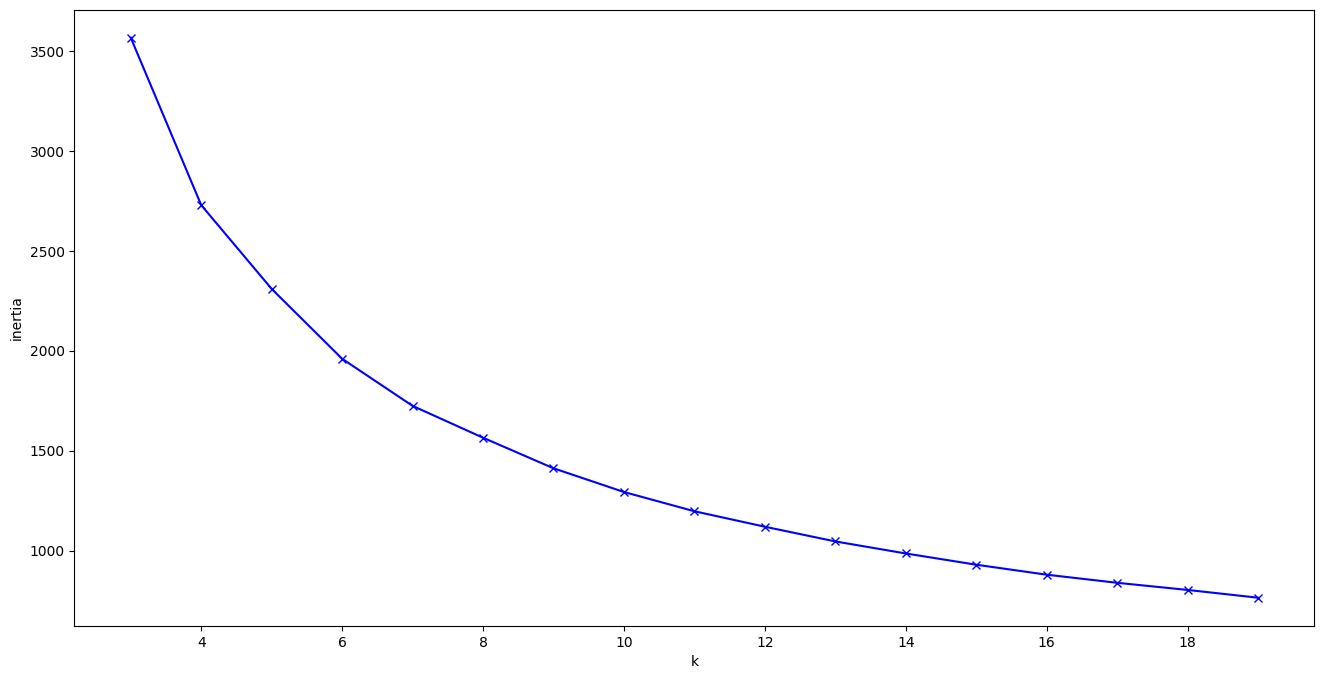

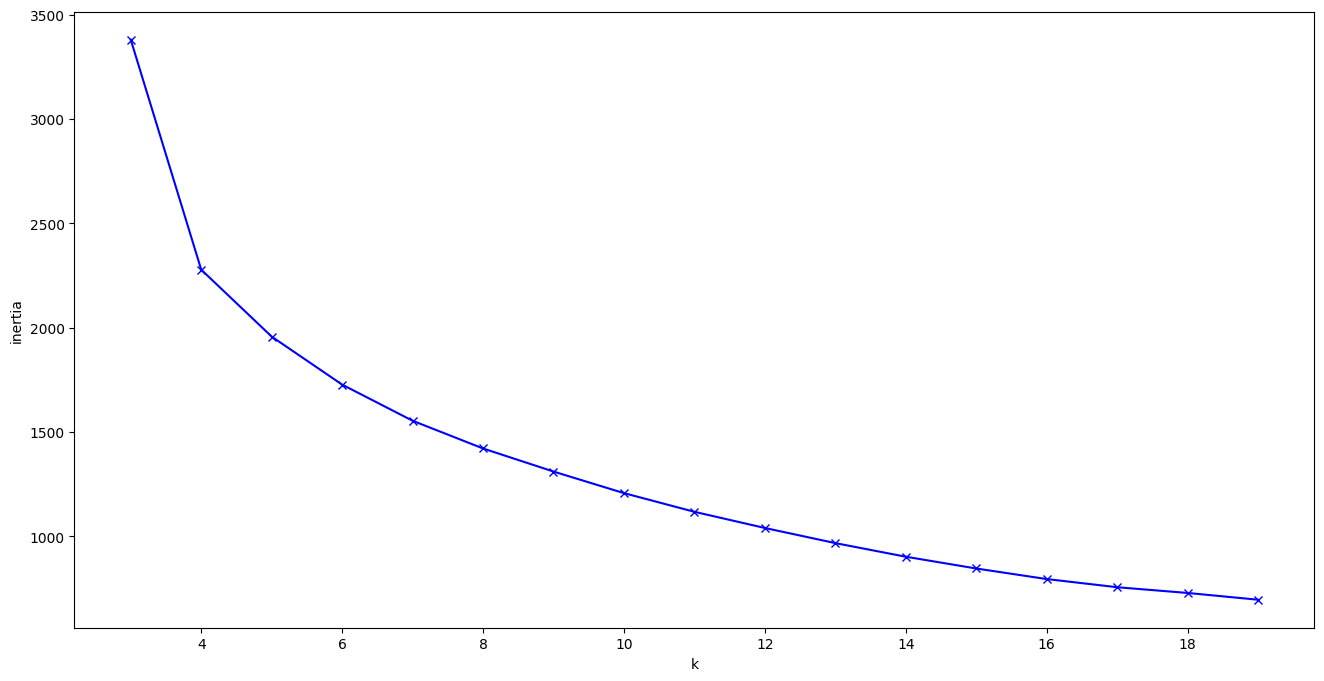

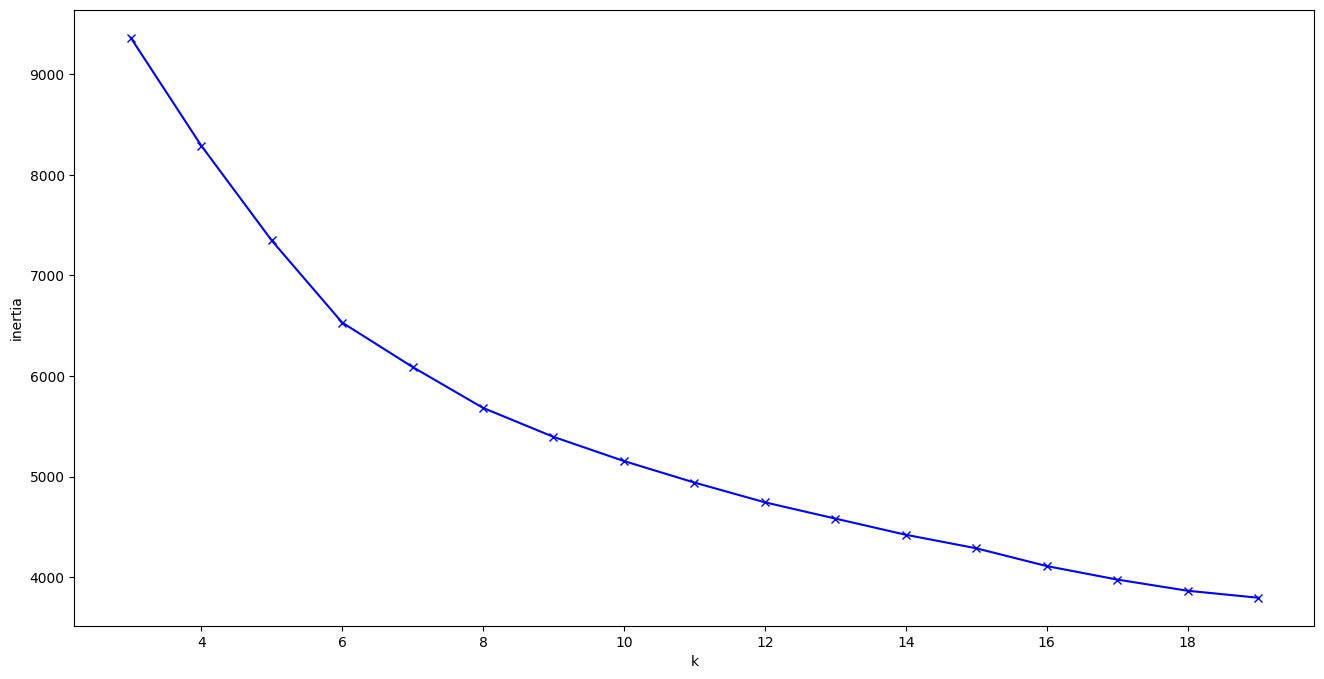

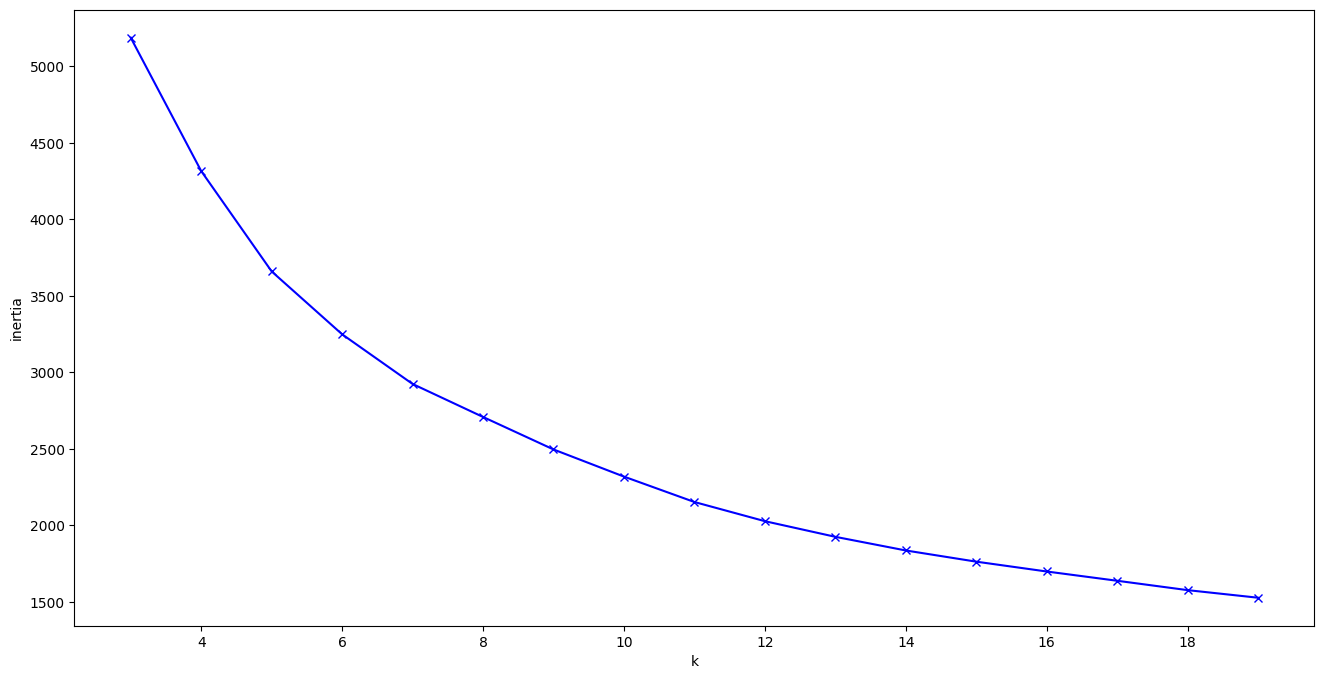

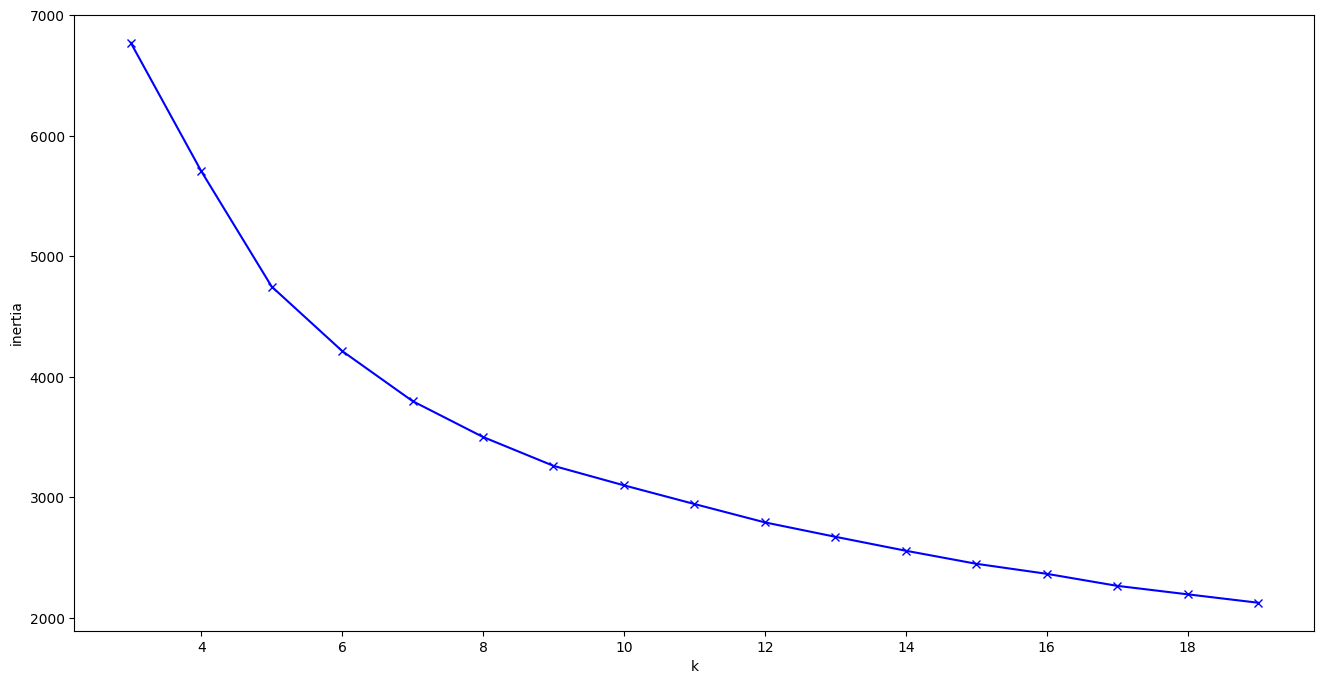

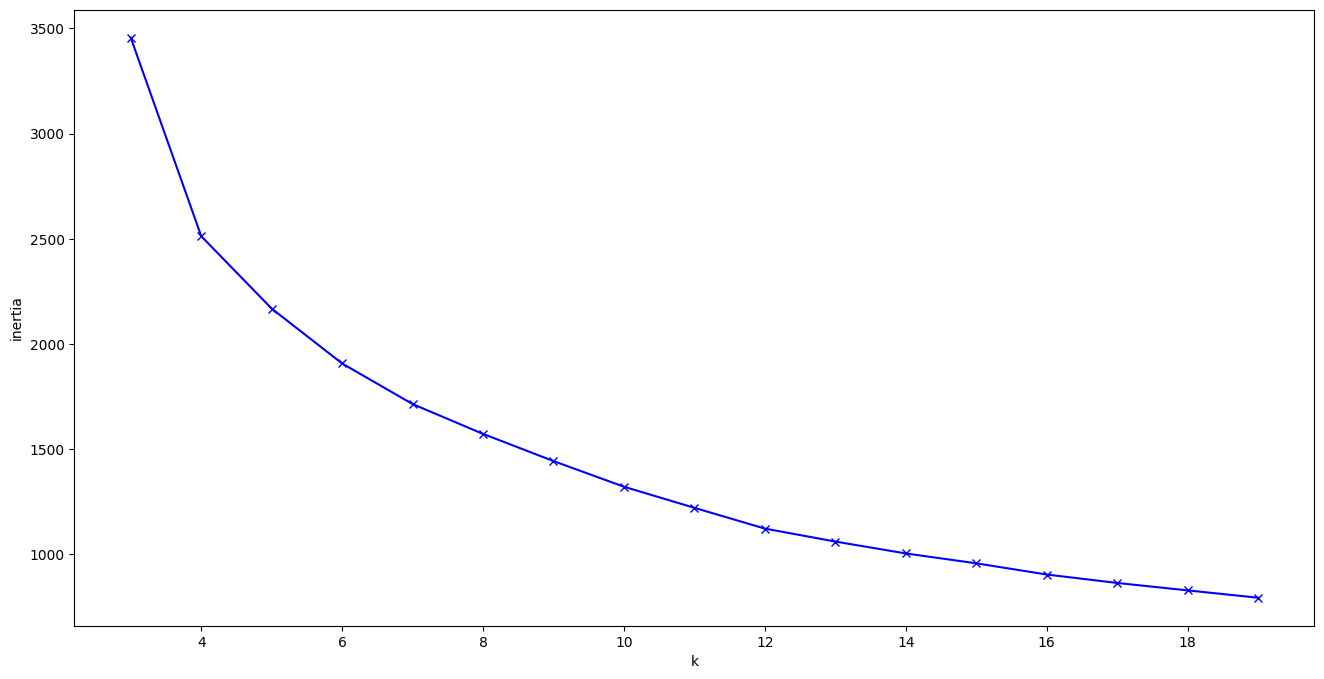

In [106]:
import time
import random

df_cluster['item'] = df_items['item']
df_cluster.set_index('item', inplace=True)

if 'cluster' in df_cluster.columns:
  df_cluster.drop(columns='cluster', inplace=True)

features_clusters = df_cluster.columns

forbidden_features = ['total_supply', 'price_mean']
basic_features = ['price_relative_std']

features_clusters = list(set(features_clusters) - set(forbidden_features))
features_clusters = list(set(features_clusters) - set(basic_features))

df_cluster_filtred = df_cluster[df_cluster['total_supply'] > 2000]

pipe_line = Pipeline([('scaler', StandardScaler())])

df_cluster_scaled_filtred = pipe_line.fit_transform(df_cluster_filtred)

n_tries = 19
set_k = range(3, 20)
dict_clustering = {}
dict_try = {}
n_inizializations = 50
full_experiment = 0


for i_try in range(n_tries):
  n_features = random.randint(3, len(features_clusters) - full_experiment)
  if (n_features == len(features_clusters) and (full_experiment == 0)) :
    full_experiment = 1
  selected_features = random.sample(list(features_clusters), n_features)
  df_cluster_reduced_filtred = df_cluster_scaled_filtred[selected_features]
  dict_clustering = {}
  inertia = 0
  for k in set_k:
    for i in range(n_inizializations):
      kmeans = KMeans(n_clusters=k, random_state=i).fit(df_cluster_reduced_filtred)
      if (i == 0 or kmeans.inertia_ < inertia):
#        print(f'best try {i}')
        inertia = kmeans.inertia_
        best_kmeans = kmeans
        dict_clustering[k] = [kmeans.inertia_, n_features, i, selected_features]

  #    dict_clustering[k] = [kmeans.inertia_, kmeans.score(df_cluster_scaled), kmeans.cluster_centers_, selected_features]
  #    dict_try[i_try] = [k, kmeans.inertia_, kmeans.score(df_cluster_scaled), kmeans.cluster_centers_, selected_features]

  dict_try[i_try] = dict_clustering

  fig = plt.figure(figsize= (16,8))
  plt.plot(set_k, [dict_clustering[k][0] for k in set_k], 'bx-')
  plt.xlabel('k')
  plt.ylabel('inertia')
  print(f'Iteracion {i_try + 1}, cantidad de features: {n_features}, features: {selected_features}')


In [107]:
df_tries = pd.DataFrame(dict_try)
df_tries.transpose()

3   \
0   [3407.7992985001406, 3, 18, [%trend_slope, Soc...   
1   [5605.644838467661, 4, 17, [sale_relative_std,...   
2   [10850.225355281376, 7, 33, [Sociability, sale...   
3   [9236.943036139508, 6, 49, [Sociability, %tren...   
4   [3780.9407324751905, 3, 32, [Regionality, pric...   
5   [5664.707004587646, 4, 22, [Seasonality, %tren...   
6   [6736.682736761327, 5, 39, [price_elasticity, ...   
7   [6910.610249806831, 5, 28, [Sociability, Seaso...   
8   [8797.659344623617, 6, 10, [Sociability, Seaso...   
9   [8830.67603572952, 6, 12, [sale_relative_std, ...   
10  [5447.750293369431, 4, 31, [sale_relative_std,...   
11  [8830.67603572952, 6, 12, [sale_mean, %trend_s...   
12  [7179.15753461606, 5, 32, [sale_mean, sale_rel...   
13  [3566.000488639559, 3, 0, [sale_mean, Regional...   
14  [3379.5402986144363, 3, 5, [Sociability, Seaso...   
15  [9361.632207986295, 6, 27, [Regionality, sale_...   
16  [5186.0425725109935, 4, 6, [%trend_slope, sale...   
17  [6771.739507861935, 5, 23, [Sociability, sale_...   
18  [3455.9256136554854, 3, 3, [price_elasticity, ...   

                                                   4   \
0   [2658.2837078716275, 3, 26, [%trend_slope, Soc...   
1   [4741.597965864053, 4, 11, [sale_relative_std,...   
2   [9782.341267496691, 7, 8, [Sociability, sale_m...   
3   [8259.288689192628, 6, 21, [Sociability, %tren...   
4   [2928.0554444895515, 3, 0, [Regionality, price...   
5   [4640.375801972652, 4, 2, [Seasonality, %trend...   
6   [5770.828410679797, 5, 17, [price_elasticity, ...   
7   [5822.227083508585, 5, 4, [Sociability, Season...   
8   [7726.460816974683, 6, 3, [Sociability, Season...   
9   [7768.443731771622, 6, 23, [sale_relative_std,...   
10  [4506.430600945592, 4, 3, [sale_relative_std, ...   
11  [7768.443731771623, 6, 23, [sale_mean, %trend_...   
12  [6198.489585551564, 5, 37, [sale_mean, sale_re...   
13  [2728.3446965139606, 3, 20, [sale_mean, Region...   
14  [2277.8429133071954, 3, 37, [Sociability, Seas...   
15  [8289.562265717677, 6, 20, [Regionality, sale_...   
16  [4314.8700573129145, 4, 24, [%trend_slope, sal...   
17  [5706.5304054958715, 5, 7, [Sociability, sale_...   
18  [2512.6026682024135, 3, 0, [price_elasticity, ...   

                                                   5   \
0   [2333.997443964658, 3, 7, [%trend_slope, Socia...   
1   [3987.9716482128474, 4, 35, [sale_relative_std...   
2   [8830.78340891504, 7, 30, [Sociability, sale_m...   
3   [7409.999048034037, 6, 17, [Sociability, %tren...   
4   [2511.111756559523, 3, 28, [Regionality, price...   
5   [4050.3438407922904, 4, 45, [Seasonality, %tre...   
6   [4876.5417567841205, 5, 12, [price_elasticity,...   
7   [5157.859057194093, 5, 32, [Sociability, Seaso...   
8   [6769.84132917851, 6, 38, [Sociability, Season...   
9   [6808.911976990589, 6, 2, [sale_relative_std, ...   
10  [4008.361210791921, 4, 32, [sale_relative_std,...   
11  [6808.911976990588, 6, 2, [sale_mean, %trend_s...   
12  [5397.168945007013, 5, 45, [sale_mean, sale_re...   
13  [2309.170227975688, 3, 2, [sale_mean, Regional...   
14  [1957.1717571446343, 3, 21, [Sociability, Seas...   
15  [7346.640444051453, 6, 43, [Regionality, sale_...   
16  [3659.2184004459787, 4, 30, [%trend_slope, sal...   
17  [4748.442554111448, 5, 28, [Sociability, sale_...   
18  [2168.3765513749554, 3, 18, [price_elasticity,...   

                                                   6   \
0   [2084.779181188609, 3, 16, [%trend_slope, Soci...   
1   [3577.6284779968237, 4, 5, [sale_relative_std,...   
2   [8071.2454339823835, 7, 2, [Sociability, sale_...   
3   [6689.591844692946, 6, 18, [Sociability, %tren...   
4   [2148.9753938755994, 3, 19, [Regionality, pric...   
5   [3639.889163576217, 4, 21, [Seasonality, %tren...   
6   [4297.558490910632, 5, 7, [price_elasticity, S...   
7   [4695.573764653831, 5, 0, [Sociability, Season...   
8   [6075.88435161984, 6, 36, [Sociability, Season...   
9   [6155.592870827856, 6, 19, [sale_relative_std,...   
1

In [108]:
dict_try[9][9]

[5006.116068735158,
 6,
 23,
 ['sale_relative_std',
  'Seasonality',
  'Regionality',
  'Sociability',
  'sale_mean',
  '%trend_slope']]

In [109]:
# Examinamos un cluster particular

set_features_selected =       ['sale_mean',
  'price_elasticity',
  'sale_relative_std',
  'Regionality',
  'Seasonality',
  'Sociability',
  '%trend_slope']

k_selected = 9
seed = 14

print(set_features_selected)


df_cluster_filtered = df_cluster[df_cluster['total_supply'] > 2000]

pipe_line = Pipeline([('scaler', StandardScaler())])

df_cluster_scaled_filtered = pipe_line.fit_transform(df_cluster_filtered)


df_cluster_selected_filtered = df_cluster_scaled_filtered[set_features_selected]
kmeans = KMeans(n_clusters=k_selected, random_state=seed).fit(df_cluster_selected_filtered)

df_cluster_filtered['cluster'] = kmeans.labels_
df_cluster_filtered.reset_index(inplace=True)
df_cluster_filtered.groupby('cluster').agg({'item': 'count', 'sale_mean': 'mean', 'sale_relative_std': 'mean', 'price_mean': 'mean', 'price_relative_std': 'mean', 'total_supply': 'mean', 'Regionality': 'mean', 'Seasonality': 'mean', 'Sociability': 'mean', '%trend_slope': 'mean', 'price_elasticity': 'mean' })


['sale_mean', 'price_elasticity', 'sale_relative_std', 'Regionality', 'Seasonality', 'Sociability', '%trend_slope']


/tmp/ipython-input-3582471403.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_filtered['cluster'] = kmeans.labels_


item   sale_mean  sale_relative_std  price_mean  price_relative_std  \
cluster                                                                        
0         145    5.000311           1.539097    6.265406            0.060099   
1         376    7.467596           1.079602    6.552987            0.045613   
2         263    3.255706           1.277667    5.858048            0.047672   
3          78   69.167548           0.902047    1.644879            0.049199   
4         293    9.445660           0.935487    5.564871            0.059676   
5         576    8.915448           0.832090    5.270812            0.035055   
6         114   11.995533           1.169673    3.193167            0.067846   
7         226    4.539451           1.358674    5.949232            0.045880   
8           4  266.967473           0.746343    1.819645            0.053108   

         total_supply  Regionality  Seasonality  Sociability  %trend_slope  \
cluster                                                                      
0         2624.889655     0.235307     0.314980     1.731034     -0.056252   
1         2621.329787     0.371786     0.071377     1.045213     -0.028798   
2         2477.673004     0.171950     0.095096     0.638783      0.247408   
3         2626.320513     0.181542     0.086028     2.474359     -0.093555   
4         2651.218430     0.211700     0.073069     1.392491     -0.165802   
5         2592.055556     0.161632     0.059466     0.836806     -0.048069   
6         2666.008772     0.217743     0.105682    10.394737     -0.131410   
7         2600.654867     0.236949     0.117835     0.796460     -0.330886   
8         2790.000000     0.311767     0.065391     4.000000     -0.083841   

         price_elasticity  
cluster                    
0               -0.026140  
1                0.013373  
2               -0.002261  
3               -0.059975  
4               -0.270418  
5                0.004783  
6               -0.132424  
7               -0.048636  
8               -0.027576

In [121]:
print(set_features_selected)
metricas =  ['mean','median', 'min', 'max']
#redondeamos valores

df_cluster_filtered.groupby('cluster').agg({'item': 'count', 'sale_mean': metricas, 'sale_relative_std': metricas, 'price_mean': metricas, 'price_relative_std': metricas, 'total_supply': metricas, 'Regionality': metricas, 'Seasonality': metricas, 'Sociability': metricas, '%trend_slope': metricas, 'price_elasticity': metricas }).round(2).transpose()


['sale_mean', 'price_elasticity', 'sale_relative_std', 'Regionality', 'Seasonality', 'Sociability', '%trend_slope']


cluster                          0        1        2        3        4  \
item               count    145.00   376.00   263.00    78.00   293.00   
sale_mean          mean       5.00     7.47     3.26    69.17     9.45   
                   median     3.02     4.50     1.86    60.07     6.46   
                   min        0.39     0.55     0.25    35.05     1.09   
                   max       47.76    46.66    30.00   142.00    50.51   
sale_relative_std  mean       1.54     1.08     1.28     0.90     0.94   
                   median     1.49     1.07     1.24     0.87     0.93   
                   min        0.97     0.71     0.80     0.47     0.49   
                   max        2.81     1.81     2.28     1.67     1.61   
price_mean         mean       6.27     6.55     5.86     1.64     5.56   
                   median     5.53     5.16     5.29     1.22     4.64   
                   min        0.31     0.73     0.31     0.24     0.63   
                   max       15.03    23.47    39.48     5.97    22.56   
price_relative_std mean       0.06     0.05     0.05     0.05     0.06   
                   median     0.05     0.04     0.04     0.05     0.05   
                   min        0.00     0.00     0.00     0.00     0.00   
                   max        0.60     0.38     0.25     0.15     0.20   
total_supply       mean    2624.89  2621.33  2477.67  2626.32  2651.22   
                   median  2730.00  2746.00  2493.00  2783.50  2776.00   
                   min     2015.00  2013.00  2009.00  2019.00  2010.00   
                   max     2790.00  2790.00  2790.00  2790.00  2790.00   
Regionality        mean       0.24     0.37     0.17     0.18     0.21   
                   median     0.22     0.35     0.17     0.15     0.21   
                   min        0.01     0.24     0.01     0.01     0.02   
                   max        0.66     0.76     0.43     0.60     0.48   
Seasonality        mean       0.31     0.07     0.10     0.09     0.07   
                   median     0.29     0.06     0.09     0.07     0.06   
                   min        0.17     0.00     0.00     0.01     0.01   
                   max        0.63     0.22     0.26     0.29     0.24   
Sociability        mean       1.73     1.05     0.64     2.47     1.39   
                   median     1.00     1.00     1.00     2.00     1.00   
                   min        0.00     0.00     0.00     0.00     0.00   
                   max        7.00    10.00    10.00     7.00     7.00   
%trend_slope       mean      -0.06    -0.03     0.25    -0.09    -0.17   
                   median    -0.06    -0.04     0.22    -0.08    -0.18   
                   min       -0.91    -0.54    -0.10    -0.55    -0.71   
                   max        0.42     0.80     1.13     0.37     0.70   
price_elasticity   mean      -0.03     0.01    -0.00    -0.06    -0.27   
                   median    -0.03     0.00     0.00    -0.05    -0.25   
                   min       -0.55    -0.35    -0.54    -0.49    -0.64   
                   max        0.52     0.53     0.53     0.27    -0.10   

cluster                          5        6        7        8  
item               count    576.00   114.00   226.00     4.00  
sale_mean          mean       8.92    12.00     4.54   266.97  
                   median     6.48     8.09     2.08   266.23  
                   min        0.99     1.53     0.44   176.09  
                   max       42.70    52.88    41.95   359.33  
sale_relative_std  mean       0.83     1.17     1.36     0.75  
                   median     0.83     1.12     1.31     0.66  
                   min        0.49     0.69     0.86     0.64  
                   max        1.23     2.18     3.05     1.03  
price_mean         mean       5.27     3.19     5.95     1.82  
                   median     4.11     2.55     5.04     1.87  
                   min        0.74     0.62     0.24     1.63  
                   max       39.49    20.60    31.83     1.

In [130]:
df_cluster.reset_index(inplace=True)
df_cluster['item'] = df_items['item']
df_cluster.set_index('item', inplace=True)

## Exportamos Data frames de interes

In [122]:
final_features = ['Sociability', 'Seasonality', '%trend_slope', 'price_elasticity', 'sale_relative_std', 'Regionality']

Iteracion 1, cantidad de features: 6, features: ['Sociability', 'Seasonality', '%trend_slope', 'price_elasticity', 'sale_relative_std', 'Regionality']


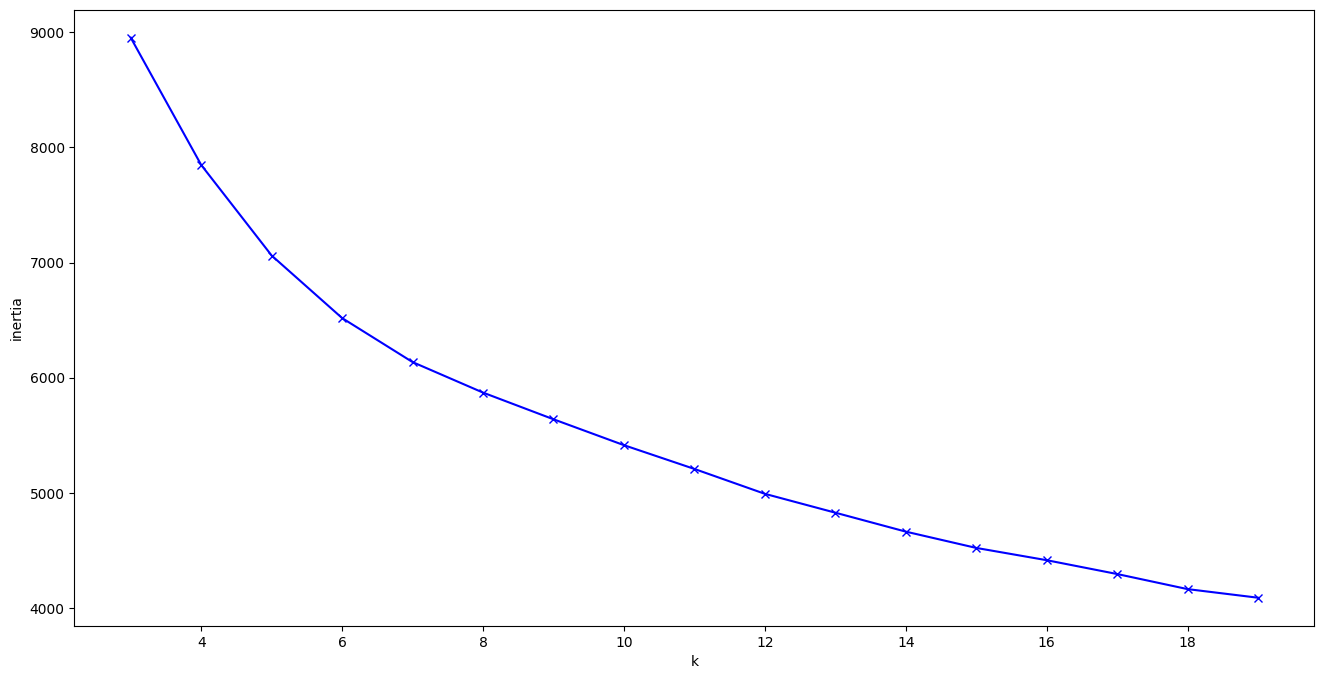

In [124]:
import time
import random

df_cluster['item'] = df_items['item']
df_cluster.set_index('item', inplace=True)

if 'cluster' in df_cluster.columns:
  df_cluster.drop(columns='cluster', inplace=True)

features_clusters = df_cluster.columns

forbidden_features = ['total_supply', 'price_mean']
basic_features = ['price_relative_std']

features_clusters = list(set(features_clusters) - set(forbidden_features))
features_clusters = list(set(features_clusters) - set(basic_features))

df_cluster_filtred = df_cluster[df_cluster['total_supply'] > 2000]

pipe_line = Pipeline([('scaler', StandardScaler())])

df_cluster_scaled_filtred = pipe_line.fit_transform(df_cluster_filtred)

n_tries = 19
set_k = range(3, 20)
dict_clustering = {}
dict_try = {}
n_inizializations = 50
full_experiment = 0


for i_try in range(1):
  n_features = len(final_features)
  if (n_features == len(features_clusters) and (full_experiment == 0)) :
    full_experiment = 1
  selected_features = final_features
  df_cluster_reduced_filtred = df_cluster_scaled_filtred[selected_features]
  dict_clustering = {}
  inertia = 0
  for k in set_k:
    for i in range(n_inizializations):
      kmeans = KMeans(n_clusters=k, random_state=i).fit(df_cluster_reduced_filtred)
      if (i == 0 or kmeans.inertia_ < inertia):
#        print(f'best try {i}')
        inertia = kmeans.inertia_
        best_kmeans = kmeans
        dict_clustering[k] = [kmeans.inertia_, n_features, i, selected_features]

  #    dict_clustering[k] = [kmeans.inertia_, kmeans.score(df_cluster_scaled), kmeans.cluster_centers_, selected_features]
  #    dict_try[i_try] = [k, kmeans.inertia_, kmeans.score(df_cluster_scaled), kmeans.cluster_centers_, selected_features]

  dict_try[i_try] = dict_clustering

  fig = plt.figure(figsize= (16,8))
  plt.plot(set_k, [dict_clustering[k][0] for k in set_k], 'bx-')
  plt.xlabel('k')
  plt.ylabel('inertia')
  print(f'Iteracion {i_try + 1}, cantidad de features: {n_features}, features: {selected_features}')

In [125]:
df_tries = pd.DataFrame(dict_try)
df_tries.transpose()

3   \
0  [8951.569233099553, 6, 18, [Sociability, Seaso...   

                                                  4   \
0  [7846.700787609153, 6, 15, [Sociability, Seaso...   

                                                  5   \
0  [7060.514606819153, 6, 7, [Sociability, Season...   

                                                  6   \
0  [6517.802044491071, 6, 1, [Sociability, Season...   

                                                  7   \
0  [6135.643660575176, 6, 47, [Sociability, Seaso...   

                                                  8   \
0  [5870.805875261862, 6, 29, [Sociability, Seaso...   

                                                  9   \
0  [5639.233944847512, 6, 34, [Sociability, Seaso...   

                                                  10  \
0  [5414.482215620288, 6, 34, [Sociability, Seaso...   

                                                  11  \
0  [5208.056500923513, 6, 20, [Sociability, Seaso...   

                                                  12  \
0  [4992.0677799287305, 6, 22, [Sociability, Seas...   

                                                  13  \
0  [4828.365204175441, 6, 8, [Sociability, Season...   

                                                  14  \
0  [4663.9288940992665, 6, 35, [Sociability, Seas...   

                                                  15  \
0  [4522.43970834356, 6, 40, [Sociability, Season...   

                                                  16  \
0  [4415.934776933418, 6, 10, [Sociability, Seaso...   

                                                  17  \
0  [4295.854425243884, 6, 16, [Sociability, Seaso...   

                                                  18  \
0  [4164.823811934714, 6, 27, [Sociability, Seaso...   

                                                  19  
0  [4090.1263174996816, 6, 33, [Sociability, Seas...

In [134]:
df_tries[0][8]

[5870.805875261862,
 6,
 29,
 ['Sociability',
  'Seasonality',
  '%trend_slope',
  'price_elasticity',
  'sale_relative_std',
  'Regionality']]

In [135]:
# Examinamos un cluster particular

set_features_selected =        ['Sociability',
  'Seasonality',
  '%trend_slope',
  'price_elasticity',
  'sale_relative_std',
  'Regionality']

k_selected = 8
seed = 29

print(set_features_selected)


df_cluster_filtered = df_cluster[df_cluster['total_supply'] > 2000]

pipe_line = Pipeline([('scaler', StandardScaler())])

df_cluster_scaled_filtered = pipe_line.fit_transform(df_cluster_filtered)


df_cluster_selected_filtered = df_cluster_scaled_filtered[set_features_selected]
kmeans = KMeans(n_clusters=k_selected, random_state=seed).fit(df_cluster_selected_filtered)

df_cluster_filtered['cluster'] = kmeans.labels_
df_cluster_filtered.reset_index(inplace=True)
df_cluster_filtered.groupby('cluster').agg({'item': 'count', 'sale_mean': 'mean', 'sale_relative_std': 'mean', 'price_mean': 'mean', 'price_relative_std': 'mean', 'total_supply': 'mean', 'Regionality': 'mean', 'Seasonality': 'mean', 'Sociability': 'mean', '%trend_slope': 'mean', 'price_elasticity': 'mean' })


['Sociability', 'Seasonality', '%trend_slope', 'price_elasticity', 'sale_relative_std', 'Regionality']


/tmp/ipython-input-445890143.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_filtered['cluster'] = kmeans.labels_


item  sale_mean  sale_relative_std  price_mean  price_relative_std  \
cluster                                                                       
0         238   4.877230           1.237591    5.780727            0.048293   
1         441  13.634390           0.826093    4.886963            0.034781   
2         114  12.968674           1.170700    3.278520            0.067489   
3         205   4.728314           1.416456    5.556742            0.047041   
4         288  12.801687           0.934041    5.297948            0.060729   
5         219   9.271335           1.197393    7.289657            0.048403   
6         427  10.983815           0.936644    5.629002            0.040804   
7         143   7.829766           1.527192    5.972172            0.059789   

         total_supply  Regionality  Seasonality  Sociability  %trend_slope  \
cluster                                                                      
0         2452.336134     0.179991     0.093758     0.634454      0.297212   
1         2581.333333     0.121872     0.063542     0.950113     -0.044664   
2         2665.991228     0.212867     0.107122    10.394737     -0.132551   
3         2609.497561     0.210088     0.117078     0.795122     -0.299087   
4         2646.371528     0.205516     0.074299     1.427083     -0.178977   
5         2627.515982     0.425981     0.090563     1.219178     -0.056666   
6         2622.203747     0.277117     0.059909     0.969555     -0.068085   
7         2637.888112     0.232985     0.317970     1.860140     -0.064096   

         price_elasticity  
cluster                    
0                0.011335  
1               -0.019866  
2               -0.131187  
3               -0.048388  
4               -0.273740  
5               -0.047744  
6                0.037069  
7               -0.016139

In [ ]:
#0  high slope + high elasticity
#1  neutral
#2  high sociability
#3  high sale std + low trend
#4  low elasticity
#5  high regionality
#6
#7  high seasonality + high sale_std

In [136]:
print(set_features_selected)
metricas =  ['mean','median', 'min', 'max']
#redondeamos valores

df_cluster_filtered.groupby('cluster').agg({'item': 'count', 'sale_mean': metricas, 'sale_relative_std': metricas, 'price_mean': metricas, 'price_relative_std': metricas, 'total_supply': metricas, 'Regionality': metricas, 'Seasonality': metricas, 'Sociability': metricas, '%trend_slope': metricas, 'price_elasticity': metricas }).round(2).transpose()


['Sociability', 'Seasonality', '%trend_slope', 'price_elasticity', 'sale_relative_std', 'Regionality']


cluster                          0        1        2        3        4  \
item               count    238.00   441.00   114.00   205.00   288.00   
sale_mean          mean       4.88    13.63    12.97     4.73    12.80   
                   median     2.32     6.97     7.74     1.61     6.82   
                   min        0.25     0.69     1.53     0.39     1.06   
                   max       55.20   142.00   105.98    63.51   176.09   
sale_relative_std  mean       1.24     0.83     1.17     1.42     0.93   
                   median     1.18     0.82     1.12     1.37     0.93   
                   min        0.74     0.49     0.69     0.89     0.47   
                   max        2.28     1.32     2.18     3.05     1.41   
price_mean         mean       5.78     4.89     3.28     5.56     5.30   
                   median     5.24     3.66     2.57     4.59     4.55   
                   min        0.31     0.24     0.62     0.24     0.63   
                   max       39.48    39.49    20.60    31.83    20.69   
price_relative_std mean       0.05     0.03     0.07     0.05     0.06   
                   median     0.04     0.03     0.06     0.04     0.05   
                   min        0.00     0.00     0.03     0.00     0.00   
                   max        0.25     0.14     0.18     0.19     0.20   
total_supply       mean    2452.34  2581.33  2665.99  2609.50  2646.37   
                   median  2448.50  2707.00  2753.00  2757.00  2777.00   
                   min     2001.00  2010.00  2129.00  2001.00  2016.00   
                   max     2790.00  2790.00  2790.00  2790.00  2790.00   
Regionality        mean       0.18     0.12     0.21     0.21     0.21   
                   median     0.18     0.13     0.22     0.22     0.20   
                   min        0.02     0.01     0.03     0.03     0.01   
                   max        0.43     0.24     0.44     0.42     0.46   
Seasonality        mean       0.09     0.06     0.11     0.12     0.07   
                   median     0.08     0.06     0.10     0.11     0.06   
                   min        0.01     0.01     0.02     0.01     0.01   
                   max        0.26     0.20     0.24     0.26     0.24   
Sociability        mean       0.63     0.95    10.39     0.80     1.43   
                   median     0.00     1.00     9.00     1.00     1.00   
                   min        0.00     0.00     6.00     0.00     0.00   
                   max       10.00     6.00    17.00     5.00     7.00   
%trend_slope       mean       0.30    -0.04    -0.13    -0.30    -0.18   
                   median     0.27    -0.04    -0.08    -0.26    -0.19   
                   min       -0.00    -0.55    -0.86    -2.27    -0.71   
                   max        1.13     0.40     1.01     0.06     0.70   
price_elasticity   mean       0.01    -0.02    -0.13    -0.05    -0.27   
                   median     0.00    -0.02    -0.15    -0.04    -0.25   
                   min       -0.54    -0.24    -0.41    -0.39    -0.64   
                   max        0.53     0.43     0.35     0.40    -0.10   

cluster                          5        6        7  
item               count    219.00   427.00   143.00  
sale_mean          mean       9.27    10.98     7.83  
                   median     4.03     5.58     3.09  
                   min        0.48     0.69     0.39  
                   max      130.14   359.33   101.49  
sale_relative_std  mean       1.20     0.94     1.53  
                   median     1.17     0.92     1.47  
                   min        0.82     0.58     0.97  
                   max        2.23     1.37     2.81  
price_mean         mean       7.29     5.63     5.97  
                   median     6.04     4.30     5.34  
                   min        0.74     0.24     0.31  
                   max       24.97    22.56    15.03  
price_relative_std mean       0.05     0.04     0.06  
                   median     0.05     0.03     0.05  
           